# 0. Import libraries

In [10]:
# 0. Import

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [11]:
import celloracle as co
co.__version__

'0.14.0'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

## 0.1. Check installation

Celloracle uses some R libraries in network analysis. 
Please make sure that all dependent R libraries are installed on your computer.
You can test the installation with the following command.

In [4]:
co.network_analysis.test_R_libraries_installation()

## 0.2. Make a folder to save graph

In [4]:
# co_output_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/"
# save_folder = "figures_danRer11"
# os.makedirs(co_output_path + save_folder, exist_ok=True)

In [5]:
# figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/figures_danRer11"

# 1. Prepare data

In this notebook, we will use scRNA-seq data processed with Seurat.
Data preprocessing and several scRNA-seq analysis, including Clustering and Dimensional Reduction shoud be done with Seurat V2 or V3. Please go to Satija Lab's instruction for more information about Seurat(https://satijalab.org/seurat/).

Seurat object should be saved as Rds file.


## 1.0. Convert Sertat object into anndata.

In celloracle, we need to prepare scRNA-seq data as an anndata object. Please go to web documentation for more information about anndata (https://anndata.readthedocs.io/en/latest/) and scanpy (https://scanpy.readthedocs.io/en/stable/).

We provide the function that can convert seurat object into anndata object.

## UPDATE (9/12/2023)
This should be done by "export_seurat_assays_to_h5ad.R" implemented in "run_01_XX.R" script.


## 1.1. Load processed gene expression data (anndata)


In [12]:
# Load data. !!Replace the data path below when you use another data.
filepath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/"
adata = sc.read_h5ad(filepath + "TDR119_processed_RNA.h5ad")
adata

AnnData object with n_obs × n_vars = 13022 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight', 'peaks_celltype.weight'
    var: 'features'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna'

In [13]:
adata.X.todense()

matrix([[ 0.,  0.,  0., ...,  9.,  0.,  0.],
        [ 0.,  0.,  0., ..., 18.,  0.,  0.],
        [ 0.,  0.,  0., ..., 39.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  6.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  0.,  0.]])

In [15]:
fields_to_drop = ['prediction.score.Lateral_Mesoderm', 'prediction.score.Neural_Crest', 'prediction.score.Somites', 'prediction.score.Epidermal', 'prediction.score.Neural_Anterior', 'prediction.score.Neural_Posterior', 'prediction.score.Endoderm', 'prediction.score.PSM', 'prediction.score.Differentiating_Neurons', 'prediction.score.Adaxial_Cells', 'prediction.score.NMPs', 'prediction.score.Notochord', 'prediction.score.Muscle', 'prediction.score.unassigned', 'prediction.score.max']
adata.obs.drop(fields_to_drop, axis=1, inplace=True)
adata

AnnData object with n_obs × n_vars = 13022 × 32057
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight', 'peaks_celltype.weight'
    var: 'features'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna'

In [16]:
del adata.raw

In [17]:
adata.write_h5ad("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/TDR119_processed_RNA_tidy.h5ad")

... storing 'global_annotation' as categorical


# !! CHECK scRNA-seq DATA !!

For the celloracle network analysis and simulation, scRNA-seq data format should meet some requirements. If you followed our tutorial notebook for the preprocessing of scRNA-seq data, the processed scRNA-seq data already should meet this requirements.

However if you made your scRNA-seq data in another method such as Seurat pipeline, please check your scRNA-seq data to make sure your scRNA-seq data meets celloracle's requiments below.

In [18]:
# Check data shape

print("Number of cell : ", adata.shape[0])
print("Number of gene : ", adata.shape[1])

Number of cell :  13022
Number of gene :  32057


In [19]:
"tbxta" in adata.var_names

True

## 1. Check gene expression value type

Celloracle input should be non-negative values WITHOUT log transformation and scaling.

You need to get your scRNA-seq data back into raw gene expression data.

In [47]:
# # In this notebook, we use raw mRNA count as an input of Oracle object.
# adata.X = adata.layers["raw_count"].copy()

## 2. Gene selection: Number of genes should be ~3000 or lower.

Gene selection should be done in the scRNA-seq gene expression matrix.
If your scRNA-seq still contains a lot of genes more than 3000, please do gene selection now.

In a general seurat analysis, highly variable genes are picked up and stored in your scRNA-seq data.
Please remove genes that are not in the variable gene list.

In [20]:
# compute the highly variable genes to reduce the number of gene feature space (RNA feature space)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, flavor="seurat_v3")
adata_hvg = adata[:,adata.var.highly_variable]
adata_hvg

View of AnnData object with n_obs × n_vars = 13022 × 3000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight', 'peaks_celltype.weight'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    obsm: 'X_umap.atac', 'X_umap.joint', 'X_umap.rna'

In [31]:
# # Try to load variable gene list
# try: 
#     variable_gene_list = adata.var.variable_gene.values
    
# # If your scRNA-seq data does not include variable gene information, please calculate variable genes now.
# except:
# #     variable_gene_list = sc.pp.filter_genes_dispersion(adata.X,
# #                                               flavor='seurat',
# #                                               n_top_genes=3000,
# #                                               log=True)
    
# # Select genes (subset for the variable genes)
# adata = adata[:, variable_gene_list]

## 3. [Optional step] Downsampling cells if you have too many cells

Calculation time and memory can be too long / large if you have too many cells.
We recommend downsampling your data if you have scRNA-seq dasta with more than 20k cells.

In [29]:
# # Random down sampling
# random_sampling_size = 20000
# if adata.shape[0] > random_sampling_size:
#     cells_random = np.random.choice(adata.obs.index.values, random_sampling_size, replace=False)
    
#     adata = adata[cells_random, :]

In [31]:
# # Check data shape again

# print("Number of cell : ", adata.shape[0])
# print("Number of gene : ", adata.shape[1])

Number of cell :  20000
Number of gene :  3000


## 4. Check dimensional reduction and clustering data
When you load a scRNA-seq data, please enter the name of clustering data and dimensional reduction data.
The clustering data should be stored in the attribute of "obs" in the anndata.
Dimensional reduction data is supposed to be stored in the attribute of "obsm" in the anndata.
You can check these data by the following command.

If you are not familiar with anndata, please look at the documentation of annata (https://anndata.readthedocs.io/en/stable/) or Scanpy (https://scanpy.readthedocs.io/en/stable/).

For the celloracle analysis, the anndata shoud include the following:
- (1) gene expression count, 
- (2) clustering information, 
- (3) trajectory (dimensional reduction embeddings) data. 

In [21]:
# show meta data name in anndata
print("metadata columns :", list(adata_hvg.obs.columns))

metadata columns : ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight', 'peaks_celltype.weight']


In [22]:
# show meta data name in anndata
print("metadata columns :", list(adata_hvg.obs.columns))

metadata columns : ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT', 'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk', 'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight', 'peaks_celltype.weight']


In [24]:
adata.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC',
       'nFeature_ATAC', 'nucleosome_signal', 'nucleosome_percentile',
       'TSS.enrichment', 'TSS.percentile', 'nCount_SCT', 'nFeature_SCT',
       'global_annotation', 'nCount_peaks_bulk', 'nFeature_peaks_bulk',
       'nCount_peaks_celltype', 'nFeature_peaks_celltype', 'SCT.weight',
       'peaks_celltype.weight'],
      dtype='object')

In [27]:
adata.obs.global_annotation.value_counts()

Neural_Anterior            3786
Lateral_Mesoderm           1864
Neural_Posterior           1750
Epidermal                  1447
Neural_Crest               1004
PSM                         730
Somites                     662
Endoderm                    448
Muscle                      419
unassigned                  306
Differentiating_Neurons     299
Adaxial_Cells               128
NMPs                        103
Notochord                    76
Name: global_annotation, dtype: int64

In [25]:
# Please select name of clustering data

clustering = "global_annotation"

# Check 
clustering in adata.obs.columns

True

In [28]:
# Show dimensional reduction data in anndata
print("dimensional reduction: ", list(adata.obsm.keys()))

dimensional reduction:  ['X_umap.atac', 'X_umap.joint', 'X_umap.rna']


In [29]:
# Please select name of dimensional reduction data
embedding = "X_umap.rna"

### !! Important: Please check your clustering and dimensional reduction by visualizing them

In [36]:
# Visualize
if embedding == "X_draw_graph_fa":
    sc.pl.draw_graph(adata, color=clustering)

elif embedding == "X_umap.atac":
    sc.pl.umap(adata, color=clustering)
    
elif embedding == "X_tsne":
    sc.pl.tsne(adata, color=clustering)

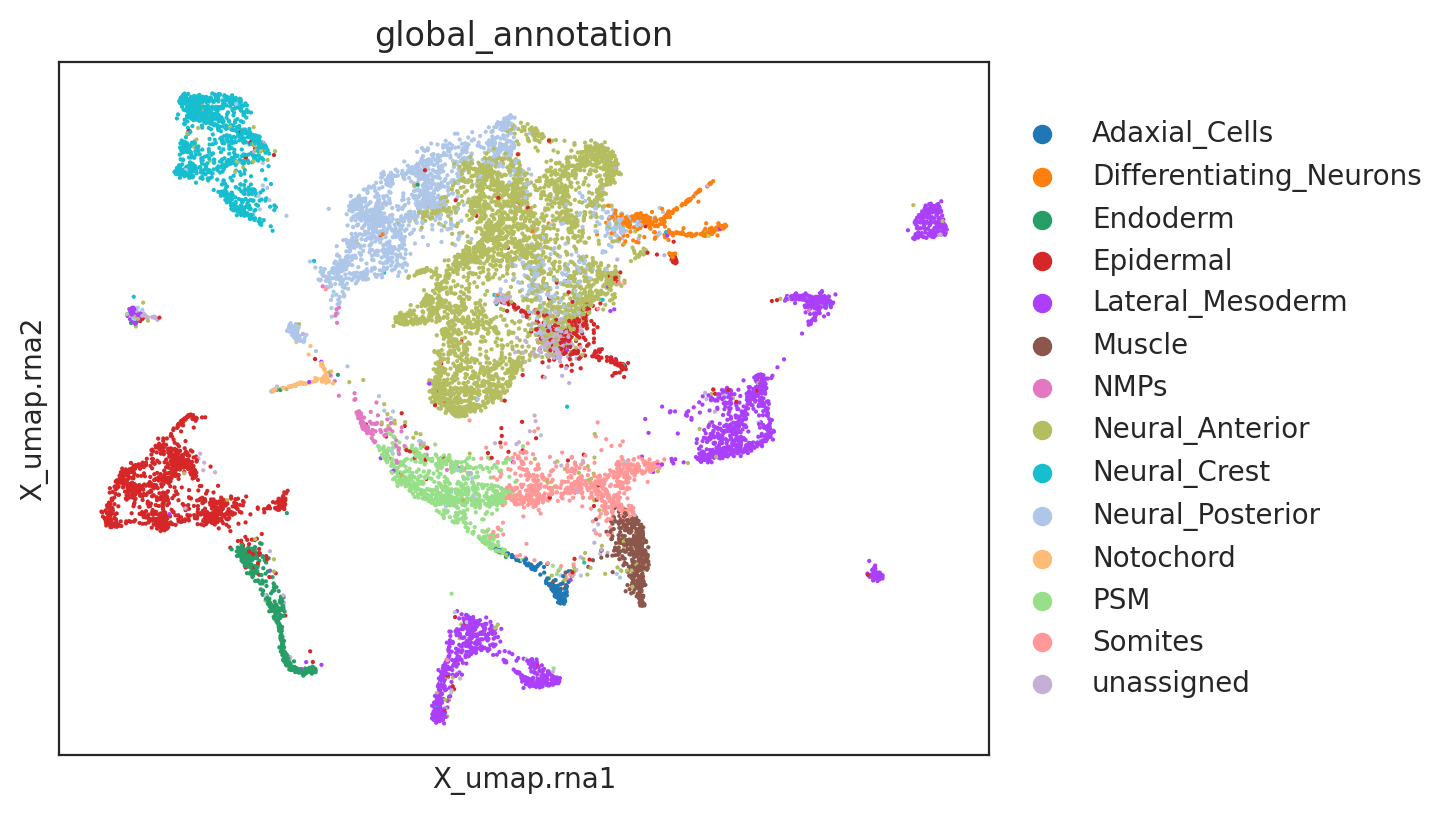

In [78]:
sc.pl.embedding(adata, basis = "X_umap.rna", color=clustering)

## 1.2. Load TF data. 
For the GRN inference, celloracle needs TF information, which contains lists of the regulatory candidate genes. 
There are several ways to make such TF information. We can generate TF information from scATAC-seq data or bulk ATAC-seq data. Please refer to the first step of the tutorial for the details of this process.


If you do not have your scATAC-seq data, you can use some built-in data in celloracle. The built-in TFinfo wqs made using various tissue/cell-types from the mouse ATAC-seq atlas dataset (http://atlas.gs.washington.edu/mouse-atac/).

You can load and use the data with the following command. 

In [32]:
# # Load TF info which was made from our own zebrafish single-cell multiome dataset (15-somite)
TFinfo_df = pd.read_parquet("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/05_TDR119_base_GRN_dataframe.parquet")

# Check data
TFinfo_df.head()

peak_id gene_short_name  A6H8I1_DANRE  CABZ01017151.1  \
0  chr10_10312654_10313520            urm1             0               0   
1  chr10_10318857_10319768        mir219-1             0               0   
2  chr10_10330150_10331040        mir219-1             1               0   
3  chr10_10728430_10729439            swi5             0               0   
4  chr10_10738382_10739233         slc27a4             0               0   

   CABZ01056727.1  CABZ01057488.2  CABZ01066696.1  CABZ01067175.1  \
0               1               0               0               1   
1               1               1               0               1   
2               1               0               0               1   
3               1               1               0               0   
4               0               1               0               1   

   CABZ01079847.1  CABZ01081359.1  ...  znf143b  znf148  znf281a  znf281b  \
0               0               0  ...        0       0        0        0   
1               0               0  ...        0       1        1        1   
2               0               0  ...        0       0        0        0   
3               0               0  ...        0       0        0        0   
4               0               0  ...        0       0        0        0   

   znf652  znf653  znf711  znf740b  znf76  zzz3  
0       0       0       0        0      0     0  
1       0       0       0        0      0     0  
2       0       0       0        0      0     0  
3       0       0       0        0      0     0  
4       0       0       0        0      0     0  

[5 rows x 874 columns]

In [33]:
print("tbxta" in TFinfo_df["gene_short_name"])
print("tbxta" in TFinfo_df.columns)

False
False


# 2. Initiate Oracle object

Celloracle has a custom called Oracle. We can use Oracle for the data preprocessing and GRN inference steps.
The Oracle object stores all of necessary information and does the calculations with its internal functions.
We instantiate an Oracle object, then input the gene expression data (anndata) and a TFinfo into the Oracle object.

In [79]:
# Instantiate Oracle object
oracle = co.Oracle()

## 2.1. load gene expression data into oracle object.

- note that the gene names should be unique.
- Refer to this github issue explaining an error down the road: https://github.com/morris-lab/CellOracle/issues/37

In [35]:
adata.var_names = adata.var_names.str.lower()
adata.var_names_make_unique()
adata.var_names

Index(['ptpn12', 'phtf2', 'phtf2.1', 'cu856344.1', 'si:zfos-932h1.3', 'mansc1',
       'lrp6', 'dusp16', 'crebl2', 'gpr19',
       ...
       'mt-nd4', 'nc-002333.16', 'nc-002333.15', 'nc-002333.8', 'mt-nd5',
       'mt-nd6', 'nc-002333.21', 'mt-cyb', 'nc-002333.22', 'nc-002333.11'],
      dtype='object', length=32057)

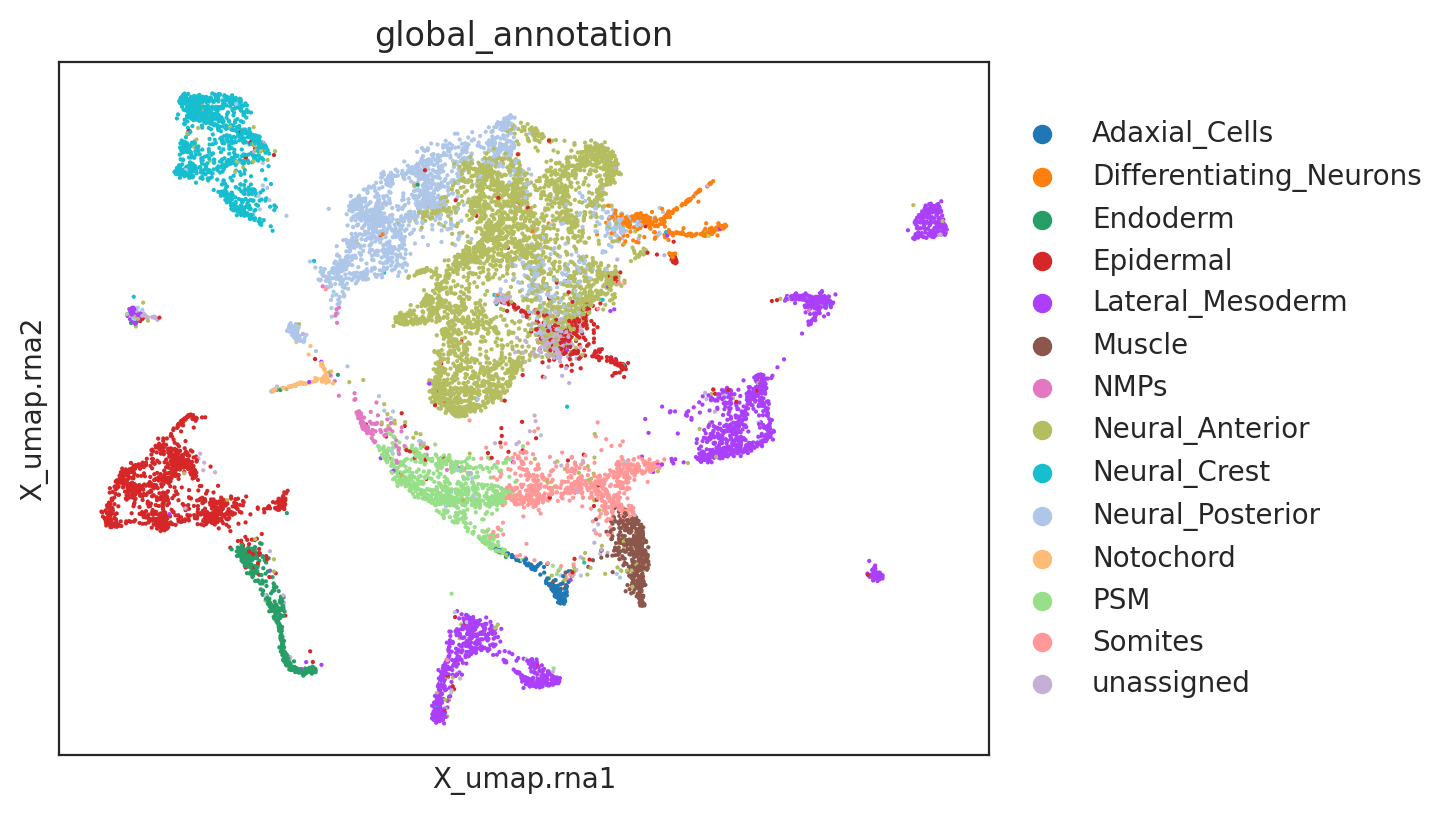

In [80]:
# Instantiate Oracle object.
oracle.import_anndata_as_raw_count(adata=adata_hvg,
                                   cluster_column_name="global_annotation",
                                   embedding_name="X_umap.rna")

## 2.2. Load TFinfo into oracle object

In [81]:
# TFinfo_df["gene_short_name"] = [gene.lower() for gene in TFinfo_df["gene_short_name"]]
# TFinfo_df
# make the base GRN's gene_short_name as well as columns as lowercase
TFinfo_df["gene_short_name"] = TFinfo_df["gene_short_name"].str.lower()
TFinfo_df.columns = TFinfo_df.columns.str.lower()
TFinfo_df

peak_id gene_short_name  a6h8i1_danre  cabz01017151.1  \
0      chr10_10312654_10313520            urm1             0               0   
1      chr10_10318857_10319768        mir219-1             0               0   
2      chr10_10330150_10331040        mir219-1             1               0   
3      chr10_10728430_10729439            swi5             0               0   
4      chr10_10738382_10739233         slc27a4             0               0   
...                        ...             ...           ...             ...   
14473     chr9_9670995_9671898          gsk3ba             0               0   
14474     chr9_9841650_9842440          fstl1b             0               0   
14475     chr9_9960217_9961167           prmt2             0               0   
14476     chr9_9977190_9977958          ugt1a1             0               0   
14477     chr9_9997566_9998393          ugt1a6             0               0   

       cabz01056727.1  cabz01057488.2  cabz01066696.1  cabz01067175.1  \
0                   1               0               0               1   
1                   1               1               0               1   
2                   1               0               0               1   
3                   1               1               0               0   
4                   0               1               0               1   
...               ...             ...             ...             ...   
14473               1               0               0               1   
14474               0               0               0               1   
14475               1               0               0               1   
14476               0               1               1               0   
14477               0               0               0               1   

       cabz01079847.1  cabz01081359.1  ...  znf143b  znf148  znf281a  znf281b  \
0                   0               0  ...        0       0        0        0   
1                   0               0  ...        0       1        1        1   
2                   0               0  ...        0       0        0        0   
3                   0               0  ...        0       0        0        0   
4                   0               0  ...        0       0        0        0   
...               ...             ...  ...      ...     ...      ...      ...   
14473               1               0  ...        0       0        0        0   
14474               0               0  ...        0       0        0        0   
14475               0               0  ...        0       0        0        0   
14476               0               0  ...        0       0        0        0   
14477               0               0  ...        0       0        0        0   

       znf652  znf653  znf711  znf740b  znf76  zzz3  
0           0       0       0        0      0     0  
1           0       0       0        0      0     0  
2           0       0       0        0      0     0  
3           0       0       0        0      0     0  
4           0       0       0        0      0     0  
...       ...     ...     ...      ...    ...   ...  
14473       0       0       0        0      0     0  
14474       0       0       0        0      0     0  
14475       0       0       0        0      0     0  
14476       0       0       0        0      0     0  
14477       0       0       0        0      0     0  

[14478 rows x 874 columns]

In [82]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=TFinfo_df)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

# 3. Knn imputation
Celloracle uses almost the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we need PCA and PC selection first.

## 3.1. PCA

67


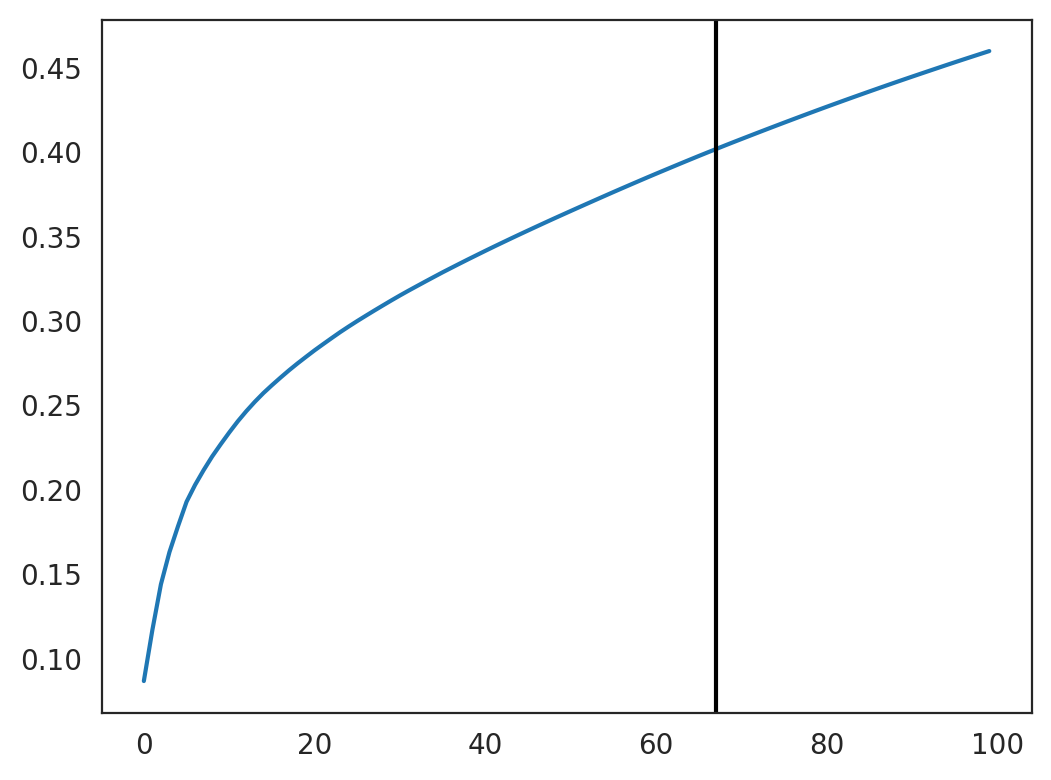

In [83]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
print(n_comps)
n_comps = min(n_comps, 50)

## 3.2. KNN imputation

Estimate the optimal number of nearest neighbors for KNN imputation.

In [84]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :13022


In [85]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :325


In [86]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

# 4. Save and Load.

Celloracle has some custom-classes: Links, Oracle and TFinfo.
You can save such an object using "to_hdf5".

Pleasae use "load_hdf5" function to load the file.


In [28]:
# # Save oracle object.
# output_filepath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/"
# oracle.to_hdf5(output_filepath + "06_TDR119.celloracle.oracle")

In [19]:
# Load file.
#oracle = co.load_hdf5("TDR118.celloracle.oracle")

# 5. GRN calculation
The next step is constructing a cluster-specific GRN for all clusters.

You can calculate  GRNs with the "get_links" function, and the function returns GRNs as a Links object.
The Links object stores inferred GRNs and the corresponding metadata. You can do network analysis with the Links object.

The GRN will be calculated for each cluster/sub-group.
In the example below, we construct GRN for each unit of the "louvain_annot" clustering.

The GRNs can be calculated at any arbitrary unit as long as the clustering information is stored in anndata.

In [30]:
# adata.uns["draw_graph"] = adata.obsm['X_umap']

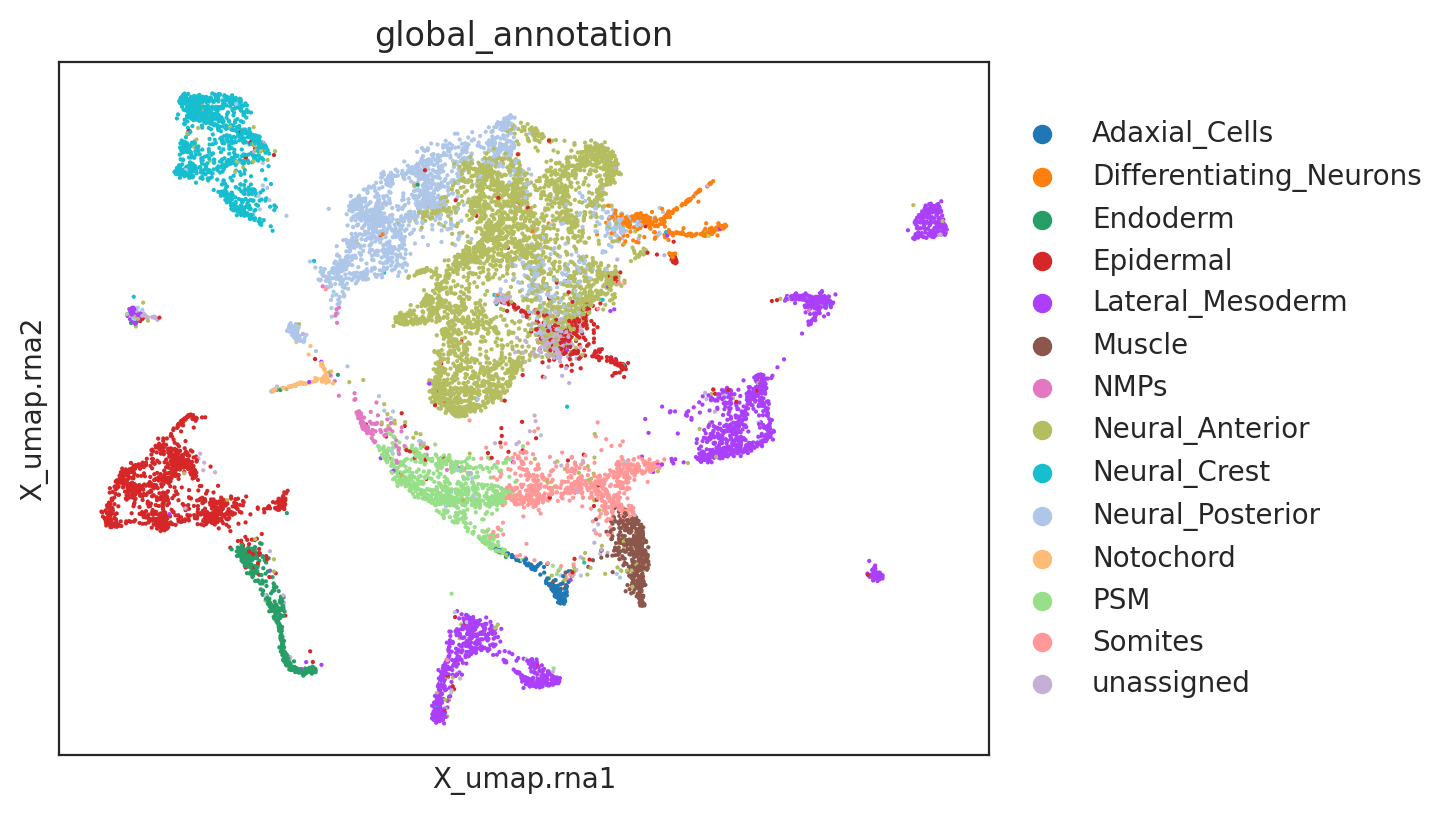

In [87]:
# check data
# sc.pl.draw_graph(oracle.adata, color="predicted.id")
sc.pl.embedding(oracle.adata, basis="X_umap.rna", color="global_annotation")

## 5.1. Get GRNs

`n_jobs` parameter in `get_links` function controls number of jobs to run in parallel. -1 means using all processors. !!This `n_jobs` parameter is only available on celloracle >= 0.9.1.

In [49]:
TFinfo_df[~TFinfo_df["gene_short_name"].isin(adata.var_names)]

peak_id   gene_short_name  a6h8i1_danre  \
1      chr10_10318857_10319768          mir219-1             0   
2      chr10_10330150_10331040          mir219-1             1   
33     chr10_13396232_13397129         loc556326             0   
57     chr10_15954086_15955000            mir23b             0   
58     chr10_15954086_15955000            mir27d             0   
...                        ...               ...           ...   
14426     chr9_6617580_6618458  si:dkeyp-118h3.6             0   
14450     chr9_7611026_7611864           mir153c             0   
14451     chr9_7612035_7612953           mir153c             0   
14464       chr9_903743_904608        zgc:101851             0   
14477     chr9_9997566_9998393            ugt1a6             0   

       cabz01017151.1  cabz01056727.1  cabz01057488.2  cabz01066696.1  \
1                   0               1               1               0   
2                   0               1               0               0   
33                  0               0               0               0   
57                  0               1               1               0   
58                  0               1               1               0   
...               ...             ...             ...             ...   
14426               0               0               0               0   
14450               0               1               0               0   
14451               0               1               0               0   
14464               0               0               0               0   
14477               0               0               0               0   

       cabz01067175.1  cabz01079847.1  cabz01081359.1  ...  znf143b  znf148  \
1                   1               0               0  ...        0       1   
2                   1               0               0  ...        0       0   
33                  0               0               0  ...        0       0   
57                  1               0               0  ...        0       0   
58                  1               0               0  ...        0       0   
...               ...             ...             ...  ...      ...     ...   
14426               1               1               0  ...        0       0   
14450               1               0               0  ...        0       0   
14451               0               1               0  ...        0       0   
14464               0               0               0  ...        1       0   
14477               1               0               0  ...        0       0   

       znf281a  znf281b  znf652  znf653  znf711  znf740b  znf76  zzz3  
1            1        1       0       0       0        0      0     0  
2            0        0       0       0       0        0      0     0  
33           0        0       0       0       0        0      0     0  
57           0        0       0       0       0        0      0     0  
58           0        0       0       0       0        0      0     0  
...        ...      ...     ...     ...     ...      ...    ...   ...  
14426        0        0       0       0       0        0      0     0  
14450        0        0       0       0       0        1      0     0  
14451        0        0       0       0       0        0      0     0  
14464        0        0       0       0       0        0      1     0  
14477        0        0       0       0       0        0      0     0  

[683 rows x 874 columns]

In [31]:
# info = oracle._generate_meta_data()
# info

{'celloracle version used for instantiation': '0.14.0',
 'n_cells': 13022,
 'n_genes': 3000,
 'status - Gene expression matrix': 'Ready',
 'cluster_name': 'predicted.id',
 'dimensional_reduction_name': 'X_umap',
 'n_target_genes_in_TFdict': '12674 genes',
 'n_regulatory_in_TFdict': '863 genes',
 'n_regulatory_in_both_TFdict_and_scRNA-seq': '316 genes',
 'n_target_genes_both_TFdict_and_scRNA-seq': '1637 genes',
 'status - BaseGRN': 'Ready',
 'status - PCA calculation': 'Done',
 'status - Knn imputation': 'Done',
 'k_for_knn_imputation': 325,
 'status - GRN calculation for simulation': 'Not finished'}

In [88]:
info = oracle._generate_meta_data()
info

{'celloracle version used for instantiation': '0.14.0',
 'n_cells': 13022,
 'n_genes': 3000,
 'status - Gene expression matrix': 'Ready',
 'cluster_name': 'global_annotation',
 'dimensional_reduction_name': 'X_umap.rna',
 'n_target_genes_in_TFdict': '12674 genes',
 'n_regulatory_in_TFdict': '868 genes',
 'n_regulatory_in_both_TFdict_and_scRNA-seq': '318 genes',
 'n_target_genes_both_TFdict_and_scRNA-seq': '1637 genes',
 'status - BaseGRN': 'Ready',
 'status - PCA calculation': 'Done',
 'status - Knn imputation': 'Done',
 'k_for_knn_imputation': 325,
 'status - GRN calculation for simulation': 'Not finished'}

In [89]:
%%time
# Calculate GRN for each population in "global_annotation" clustering unit.
# This step may take long time.
links = oracle.get_links(cluster_name_for_GRN_unit="global_annotation", alpha=10,
                         verbose_level=10, test_mode=False, n_jobs=-1)

  0%|          | 0/14 [00:00<?, ?it/s]

Inferring GRN for Adaxial_Cells...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for Differentiating_Neurons...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for Endoderm...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for Epidermal...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for Lateral_Mesoderm...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for Muscle...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for NMPs...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for Neural_Anterior...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for Neural_Crest...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for Neural_Posterior...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for Notochord...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for PSM...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for Somites...


  0%|          | 0/1637 [00:00<?, ?it/s]

Inferring GRN for unassigned...


  0%|          | 0/1637 [00:00<?, ?it/s]

CPU times: user 27min 36s, sys: 15.9 s, total: 27min 52s
Wall time: 41min 21s


In [90]:
links

## 5.2. (Optional) Export GRNs

Although celloracle has many functions for network analysis, you can analyze GRNs by hand if you choose.
The raw GRN data is stored in the attribute of "links_dict".

For example, you can get the GRN for the "NMPs" cluster with the following commands.

In [53]:
links.links_dict.keys()

dict_keys(['Adaxial_Cells', 'Differentiating_Neurons', 'Endoderm', 'Epidermal', 'Lateral_Mesoderm', 'Muscle', 'NMPs', 'Neural_Anterior', 'Neural_Crest', 'Neural_Posterior', 'Notochord', 'PSM', 'Somites', 'unassigned'])

In [91]:
links.links_dict["NMPs"]

source   target  coef_mean  coef_abs             p      -logp
0       tfap2a  abi3bpb  -0.000031  0.000031  3.519608e-02   1.453506
1         emx3  abi3bpb   0.000062  0.000062  1.972534e-04   3.704975
2        pax7b  abi3bpb   0.000171  0.000171  1.231443e-11  10.909586
3         gsx1  abi3bpb  -0.000080  0.000080  2.172656e-03   2.663009
4         evx2  abi3bpb   0.000288  0.000288  6.162301e-05   4.210257
...        ...      ...        ...       ...           ...        ...
208917  tfap2c      zwi   0.000124  0.000124  1.385341e-06   5.858443
208918   nr2e1      zwi   0.000307  0.000307  1.153935e-09   8.937819
208919   ebf3b      zwi  -0.000321  0.000321  2.986874e-05   4.524783
208920  sox21a      zwi   0.000167  0.000167  2.232218e-04   3.651263
208921   meox1      zwi  -0.000531  0.000531  6.764758e-08   7.169748

[208922 rows x 6 columns]

In [92]:
NMP_target_TFs = links.links_dict["NMPs"].target.unique()
NMP_target_TFs
len(NMP_target_TFs)

1637

You can export the file as follows.

In [93]:
# make a directory to save the cell-type specific GRNs
GRN_output_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/"
save_folder = "07_TDR119_celloracle_GRN"
os.makedirs(GRN_output_path + save_folder, exist_ok=True)

In [44]:
# Set cluster name
cluster = "NMPs"

# Save as csv
links.links_dict[cluster].to_csv(GRN_output_path + save_folder + "/" + f"raw_GRN_for_{cluster}.csv")

In [114]:
links.links_dict.keys()

dict_keys(['Adaxial_Cells', 'Differentiating_Neurons', 'Endoderm', 'Epidermal', 'Lateral_Mesoderm', 'Muscle', 'NMPs', 'Neural_Anterior', 'Neural_Crest', 'Neural_Posterior', 'Notochord', 'PSM', 'Somites', 'unassigned'])

In [94]:
for cluster in links.links_dict.keys():
    # Set cluster name
    cluster = cluster

    # Save as csv
    links.links_dict[cluster].to_csv(GRN_output_path + save_folder + "/" + f"raw_GRN_for_{cluster}.csv")

## 5.3. (Optional) Change order

The links object has a color information in an attribute, "palette".
This information is used for the visualization

The sample will be visualized in that order. 
Here we can change the order.

In [116]:
# # Show the contents of pallete
# links.palette

palette
Adaxial_Cells            #1F77B4
Differentiating_Neurons  #FF7F0E
Endoderm                 #279E68
Epidermal                #D62728
Lateral_Mesoderm         #AA40FC
Muscle                   #8C564B
NMPs                     #E377C2
Neural_Anterior          #B5BD61
Neural_Crest             #17BECF
Neural_Posterior         #AEC7E8
Notochord                #FFBB78
PSM                      #98DF8A
Somites                  #FF9896
unassigned               #C5B0D5

In [76]:
# # Change the order of pallete
# order = ['MEP_0', 'Mk_0','Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5',
#          'Ery_6', 'Ery_7', 'Ery_8', 'Ery_9','GMP_0', 'GMP_1',
#          'GMPl_0', 'Mo_0', 'Mo_1', 'Gran_0', 'Gran_1', 'Gran_2']
# links.palette = links.palette.loc[order]
# links.palette

palette
MEP_0   #0FCFC0
Mk_0    #9CDED6
Ery_0   #7D87B9
Ery_1   #BEC1D4
Ery_2   #D6BCC0
Ery_3   #BB7784
Ery_4   #8E063B
Ery_5   #4A6FE3
Ery_6   #8595E1
Ery_7   #B5BBE3
Ery_8   #E6AFB9
Ery_9   #E07B91
GMP_0   #D33F6A
GMP_1   #11C638
GMPl_0  #8DD593
Mo_0    #D5EAE7
Mo_1    #F3E1EB
Gran_0  #C6DEC7
Gran_1  #EAD3C6
Gran_2  #F0B98D

# 6. Network preprocessing

## 6.1. Filter network edges 
Celloracle utilizes bagging ridge or Bayesian ridge regression to infer gene regulatory networks. 
These methods provide a network edge strength as a distribution rather than a point value. 
We can use the distribution to know the certainness of the connection.

We filter the network edges as follows.

 (1) Remove uncertain network edges based on the p-value.
 
 (2) Remove weak network edge. In this tutorial, we pick up the top 2000 edges in terms of network strength.


The raw network data is stored as an attribute, **"links_dict,"** while filtered network data is stored in **"filtered_links."** 
Thus the filtering function keeps raw network information rather than overwriting the data. You can come back to the filtering process to filter the data with different parameters if you want.

In [95]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

## 6.2. Degree distribution 
In the first step, we examine the network degree distribution.
Network degree, which is the number of edges for each node, is one of the important metrics used to investigate the network structure (https://en.wikipedia.org/wiki/Degree_distribution).

Please keep in mind that the degree distribution may change depending on the filtering threshold.

In [96]:
plt.rcParams["figure.figsize"] = [9, 4.5]

Adaxial_Cells


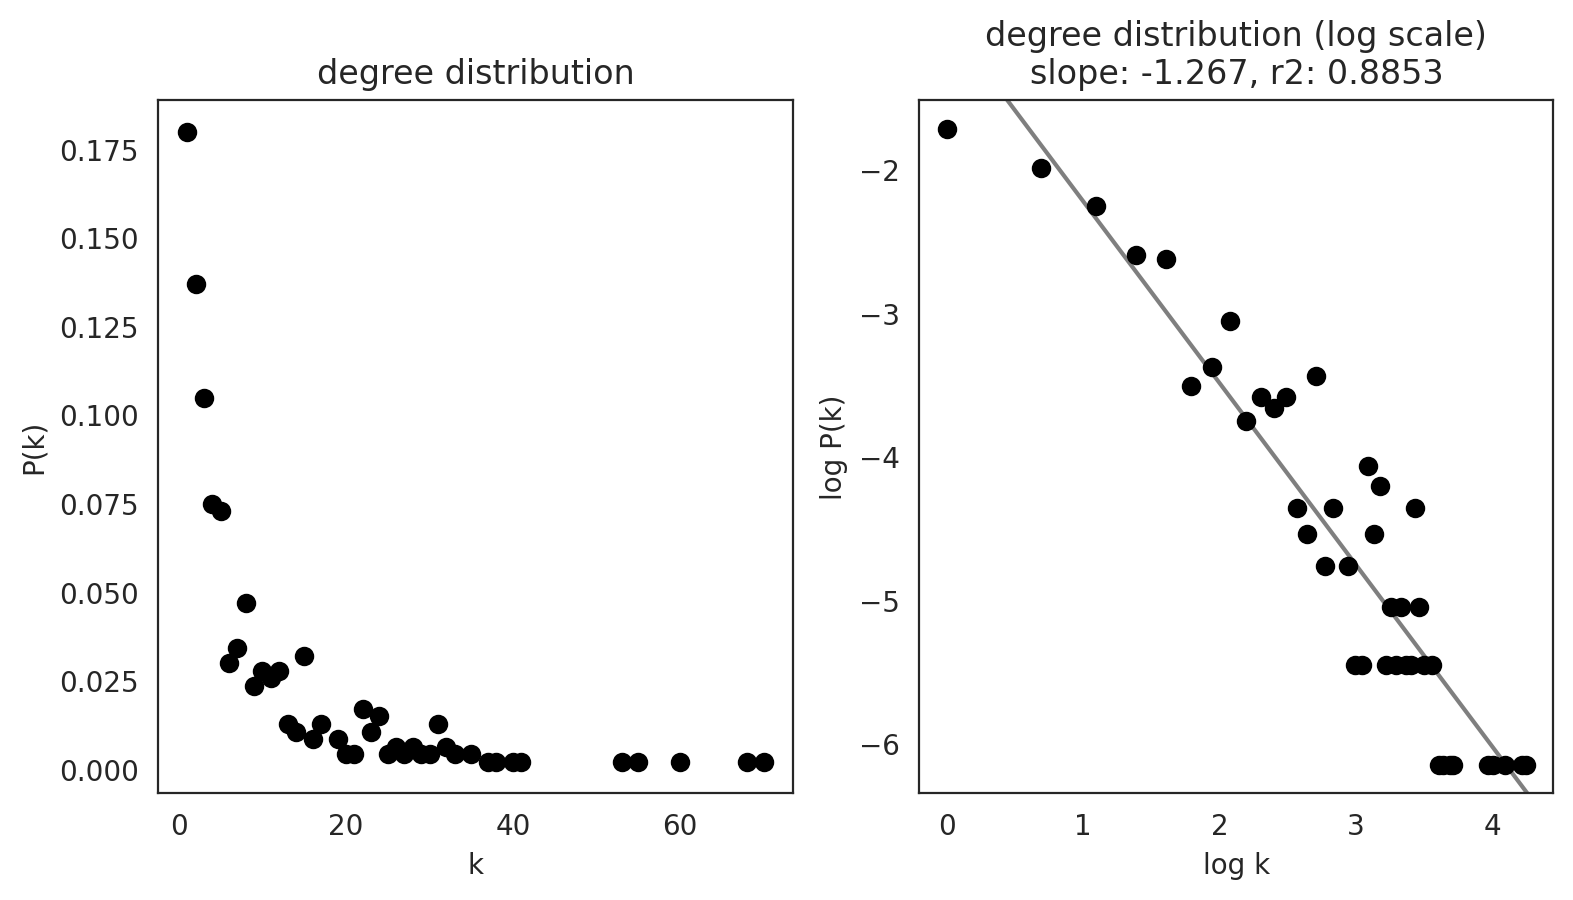

Differentiating_Neurons


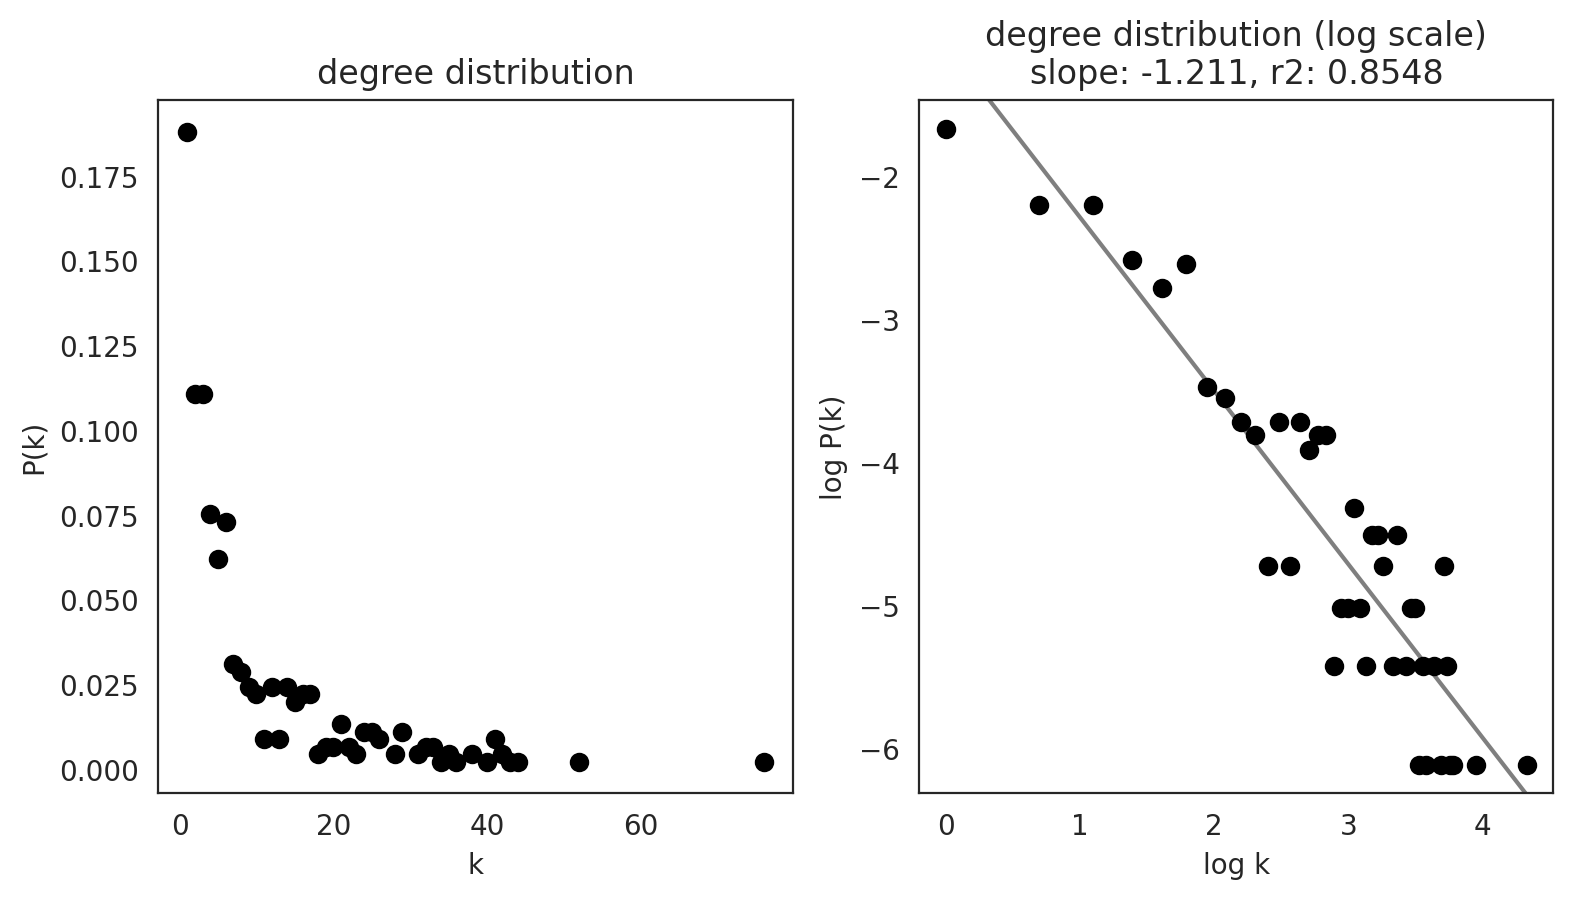

Endoderm


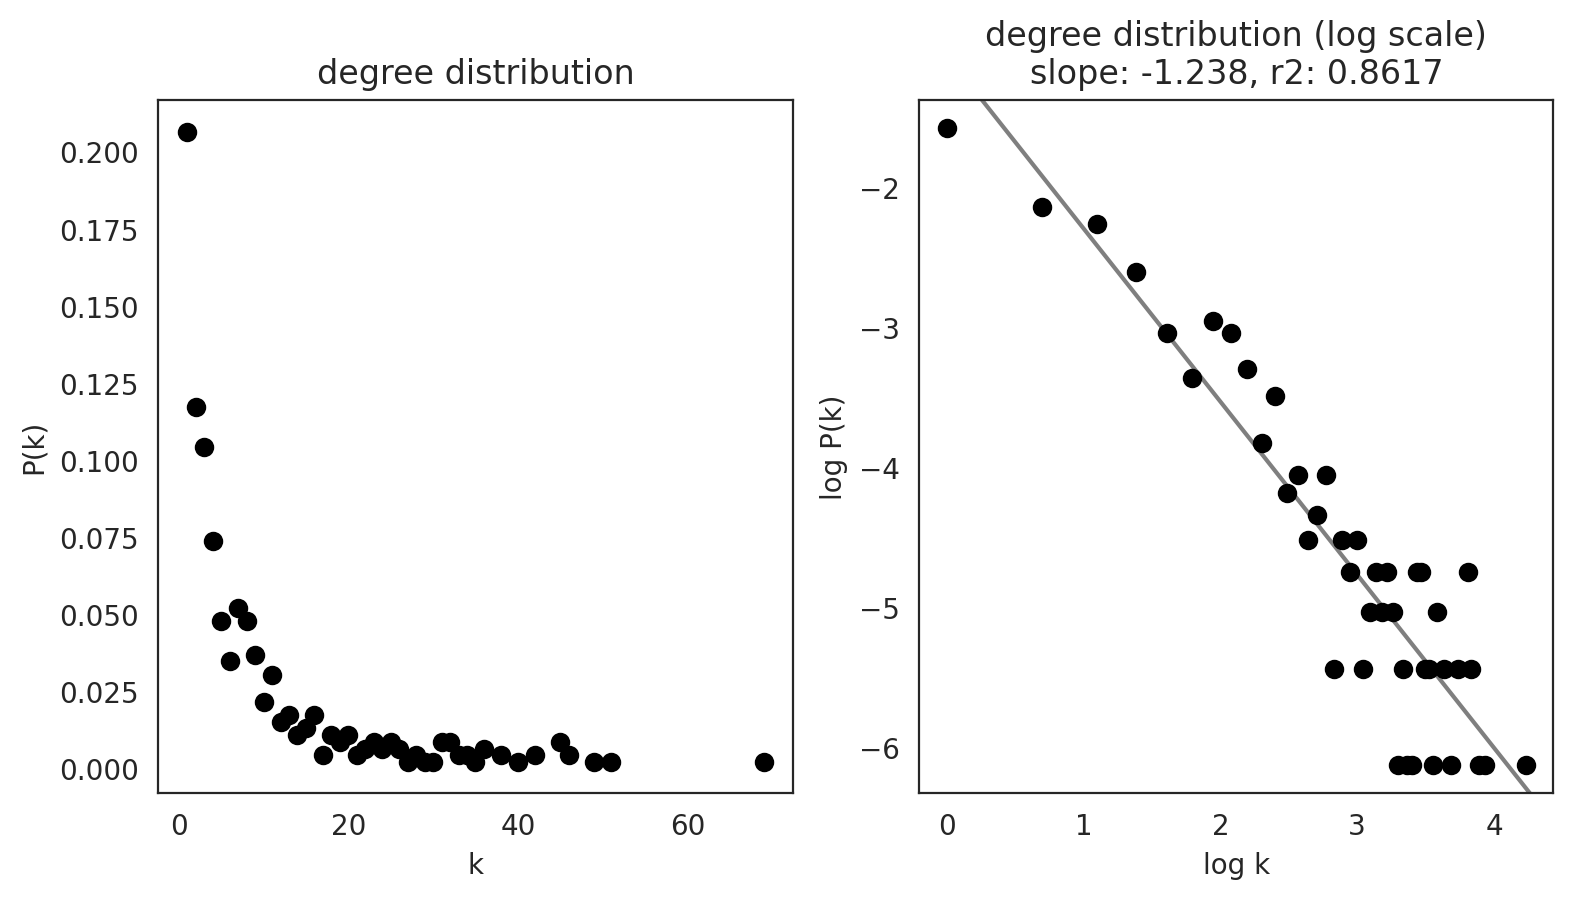

Epidermal


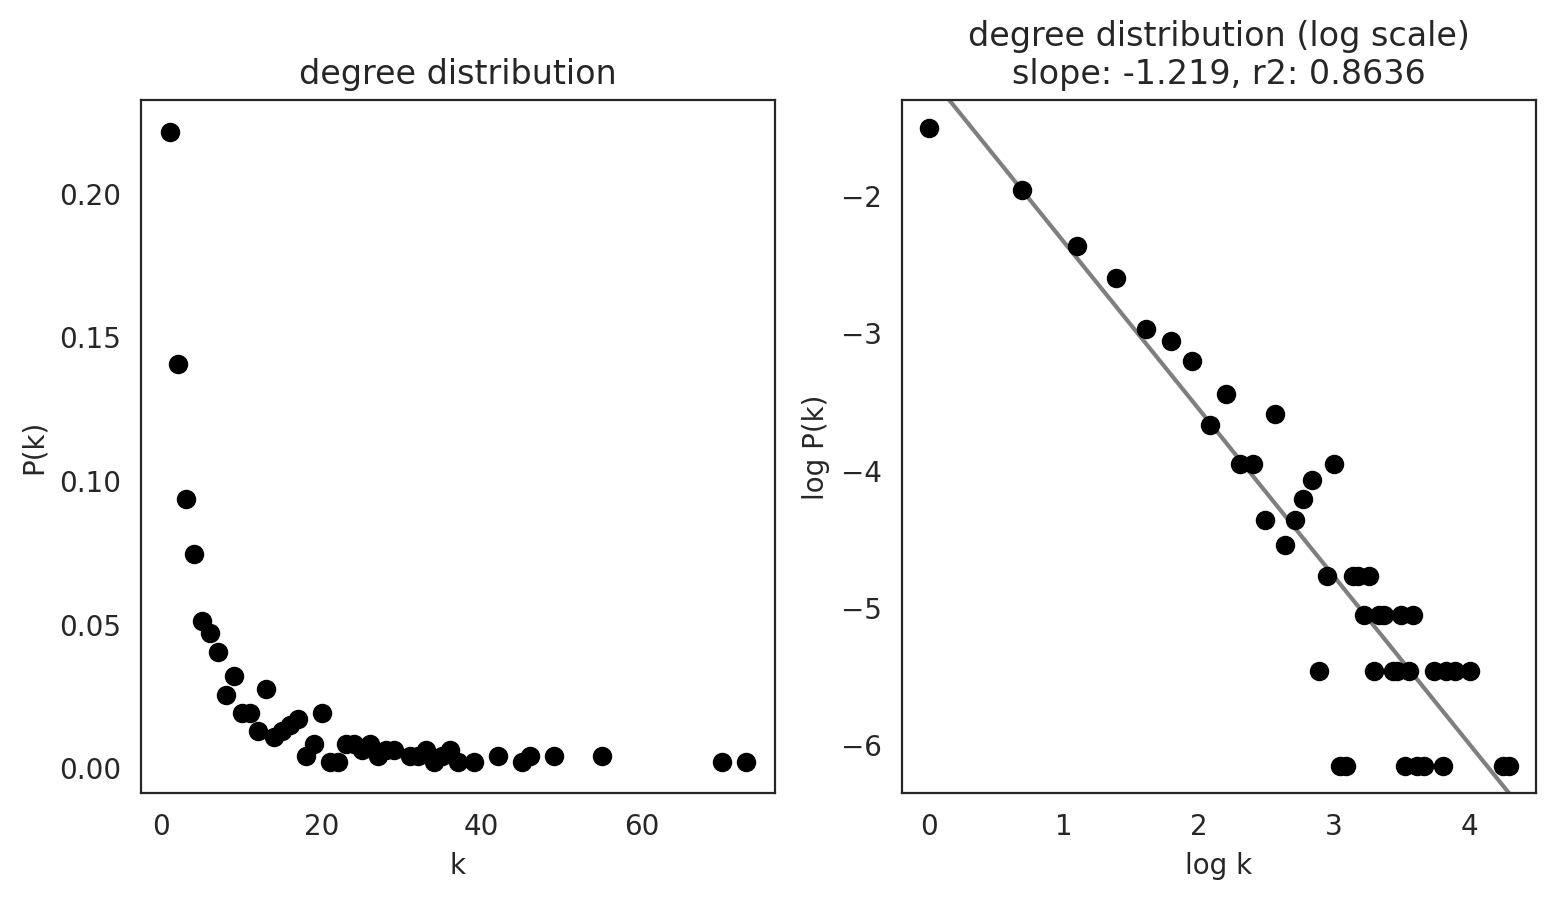

Lateral_Mesoderm


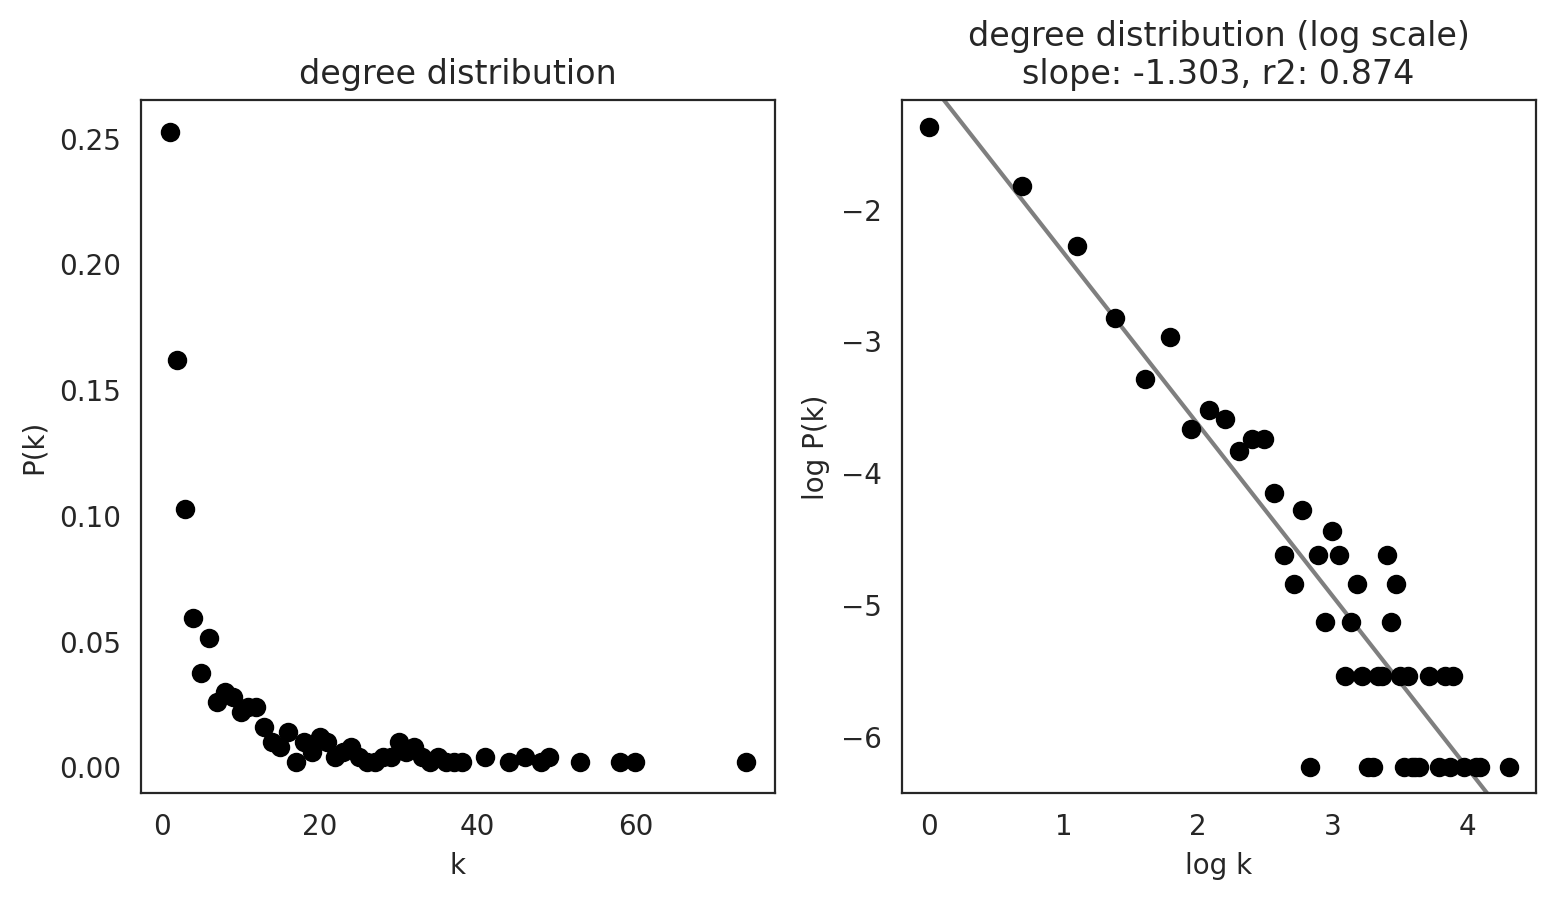

Muscle


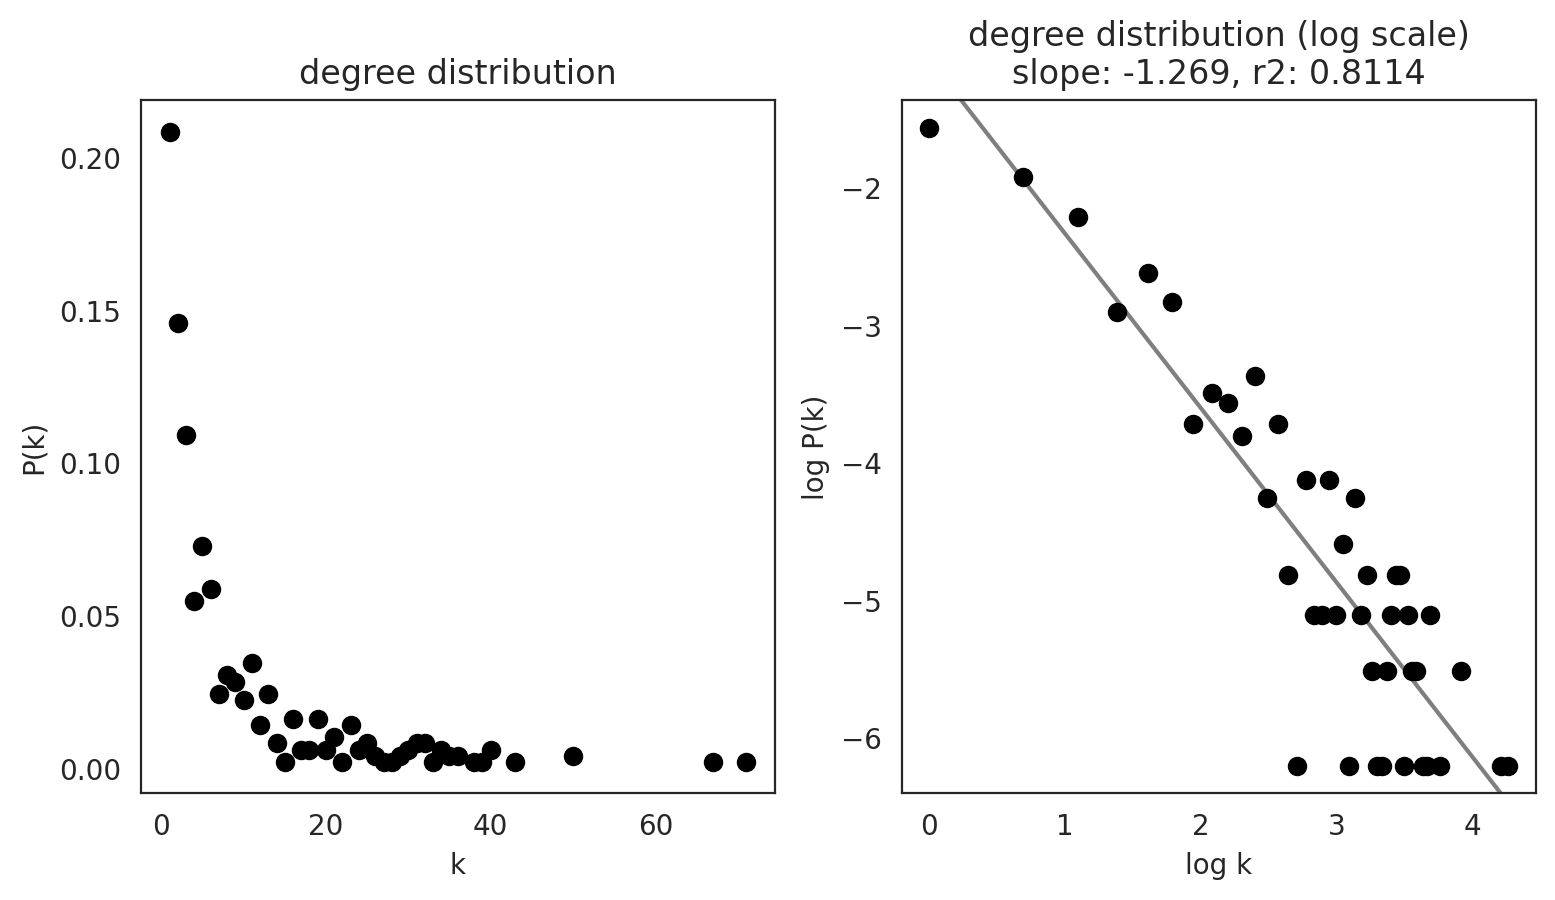

NMPs


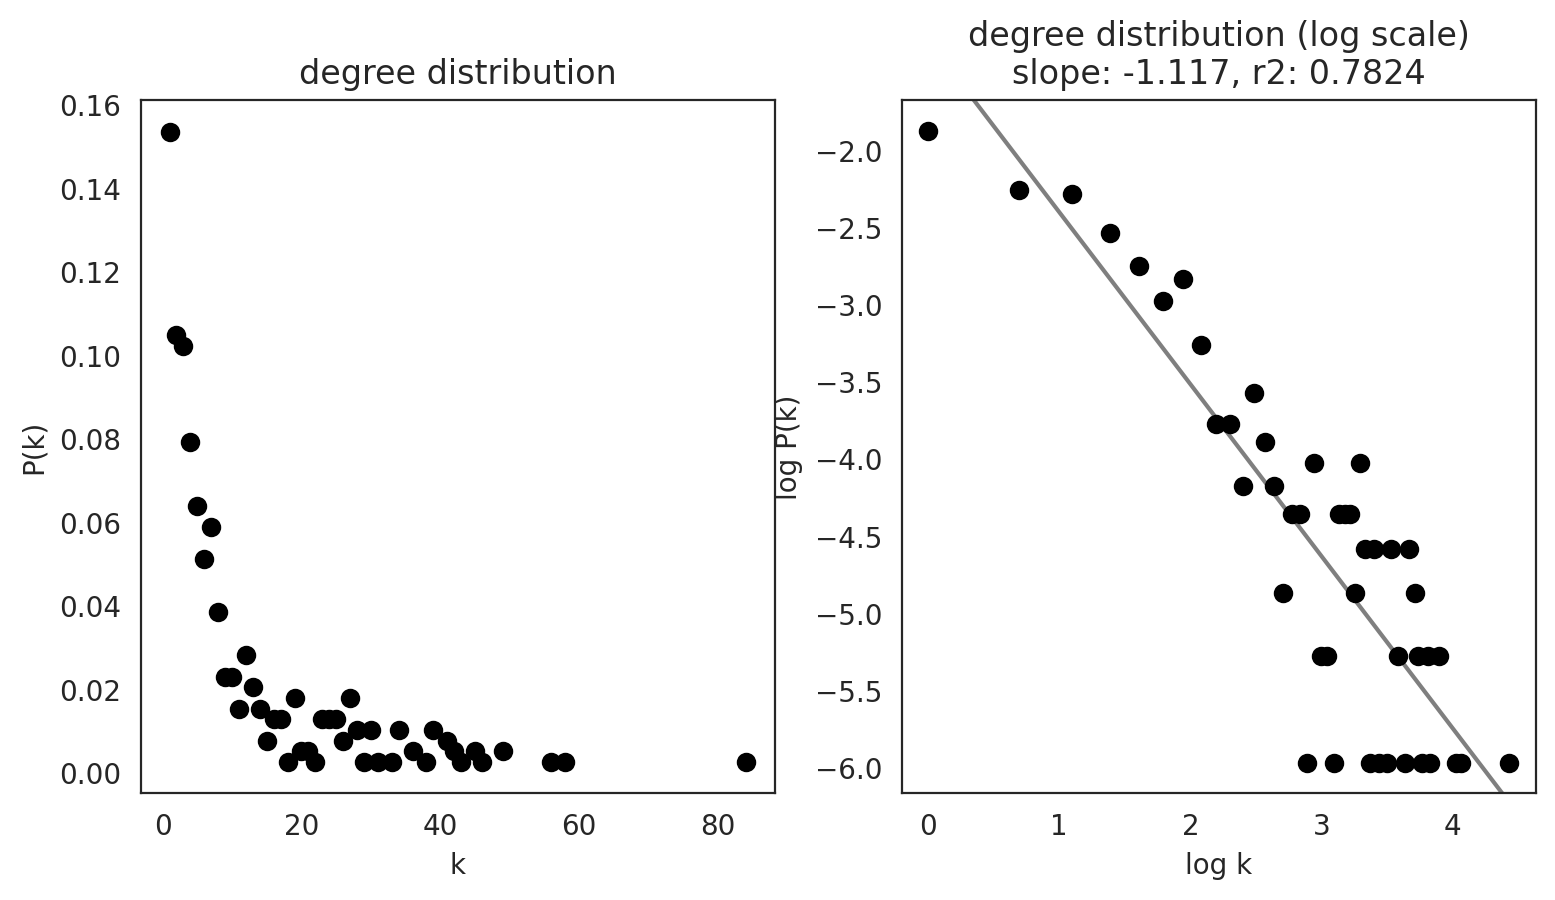

Neural_Anterior


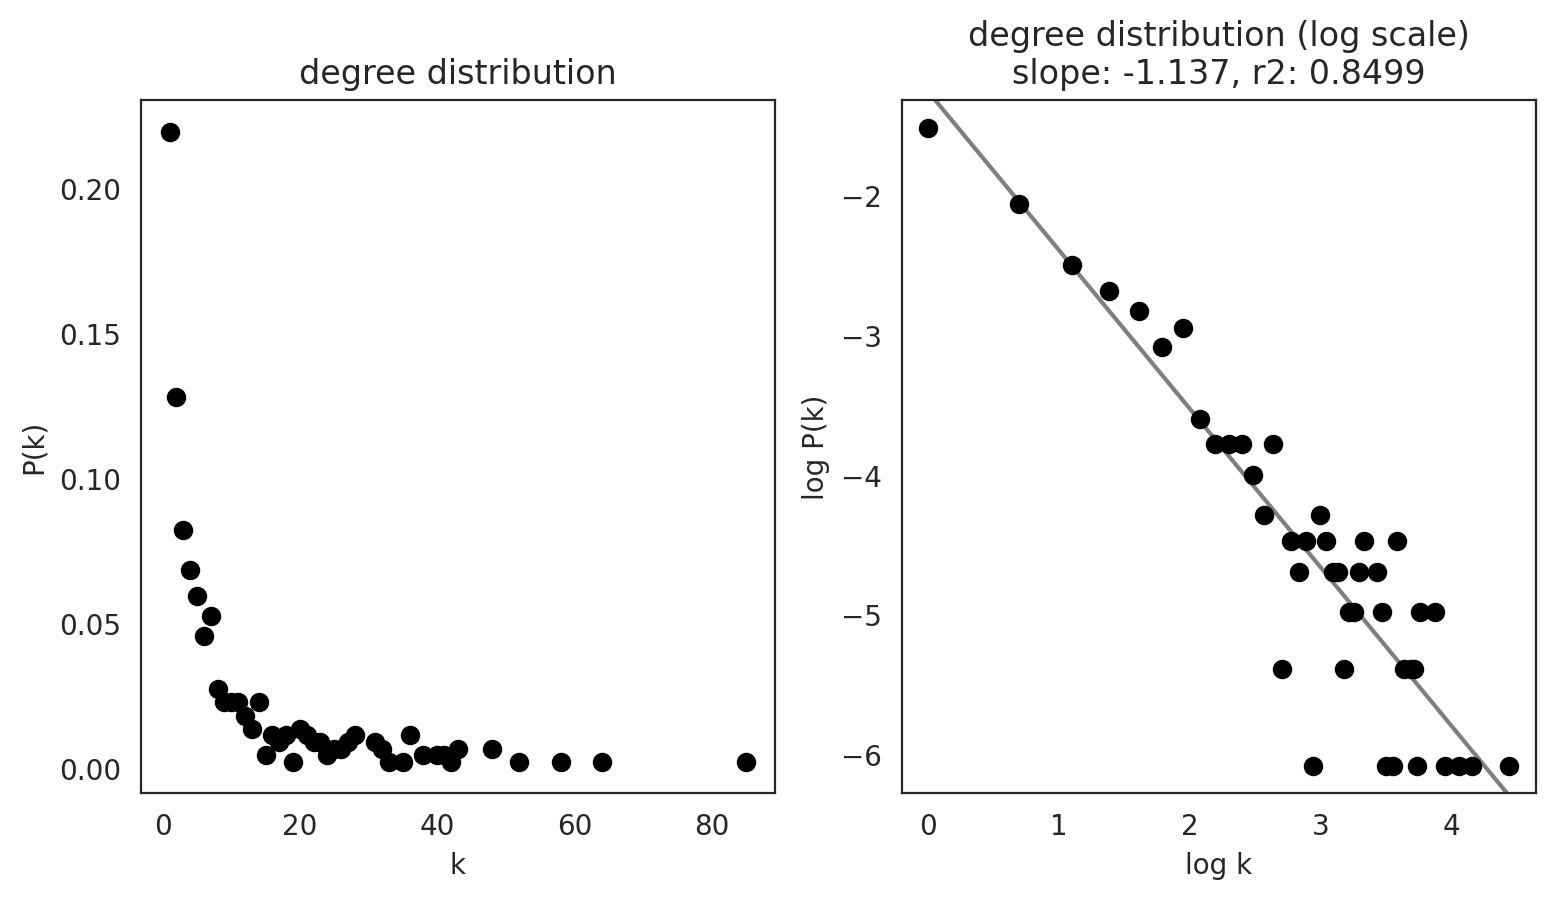

Neural_Crest


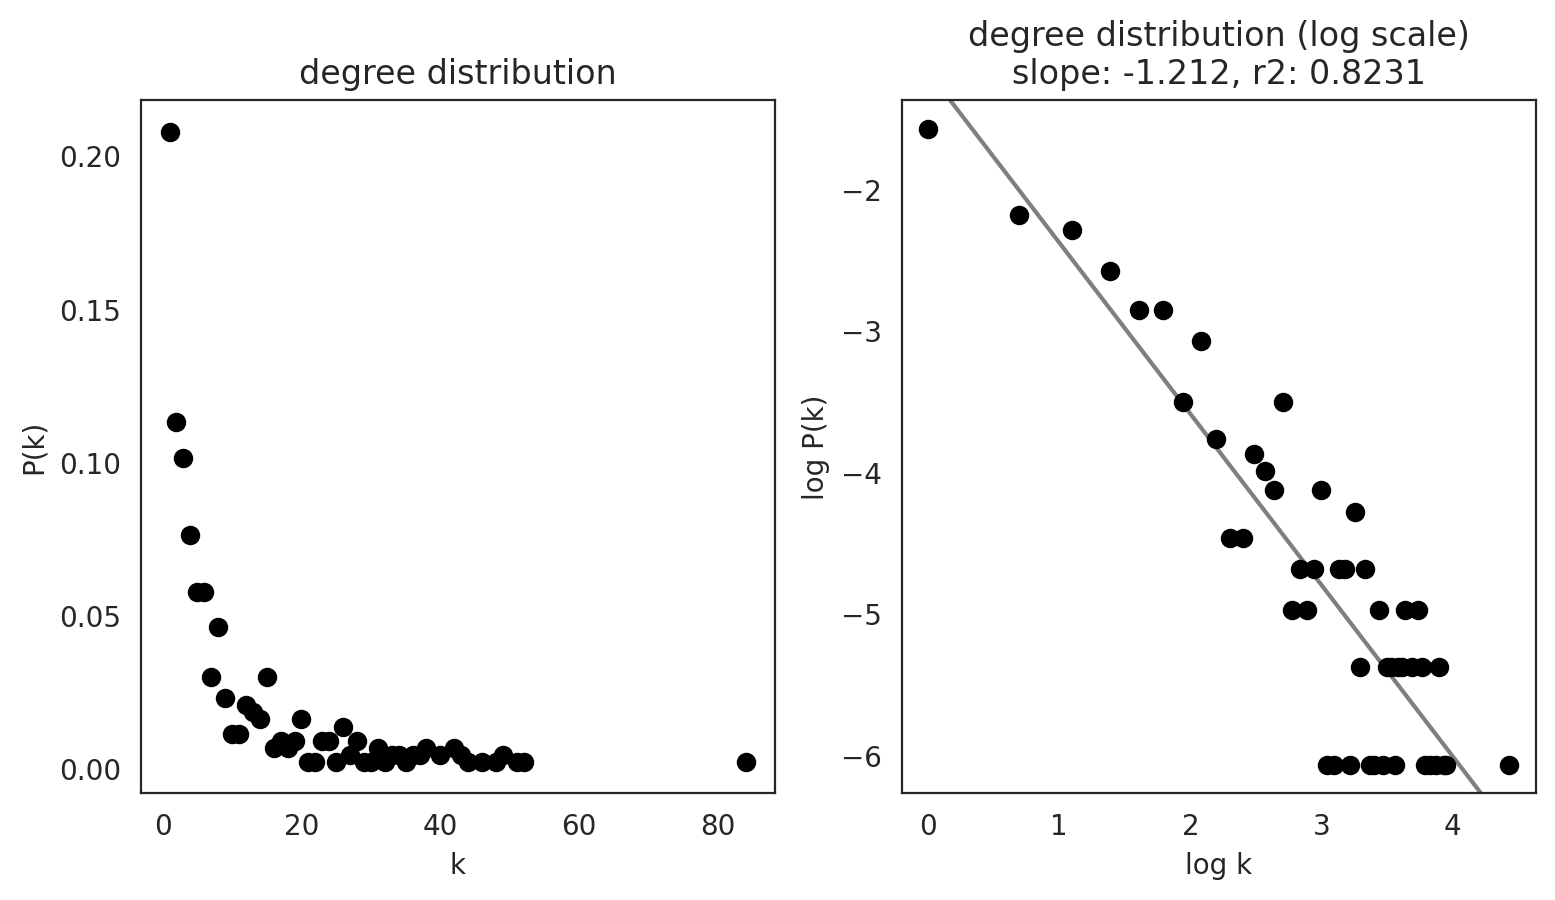

Neural_Posterior


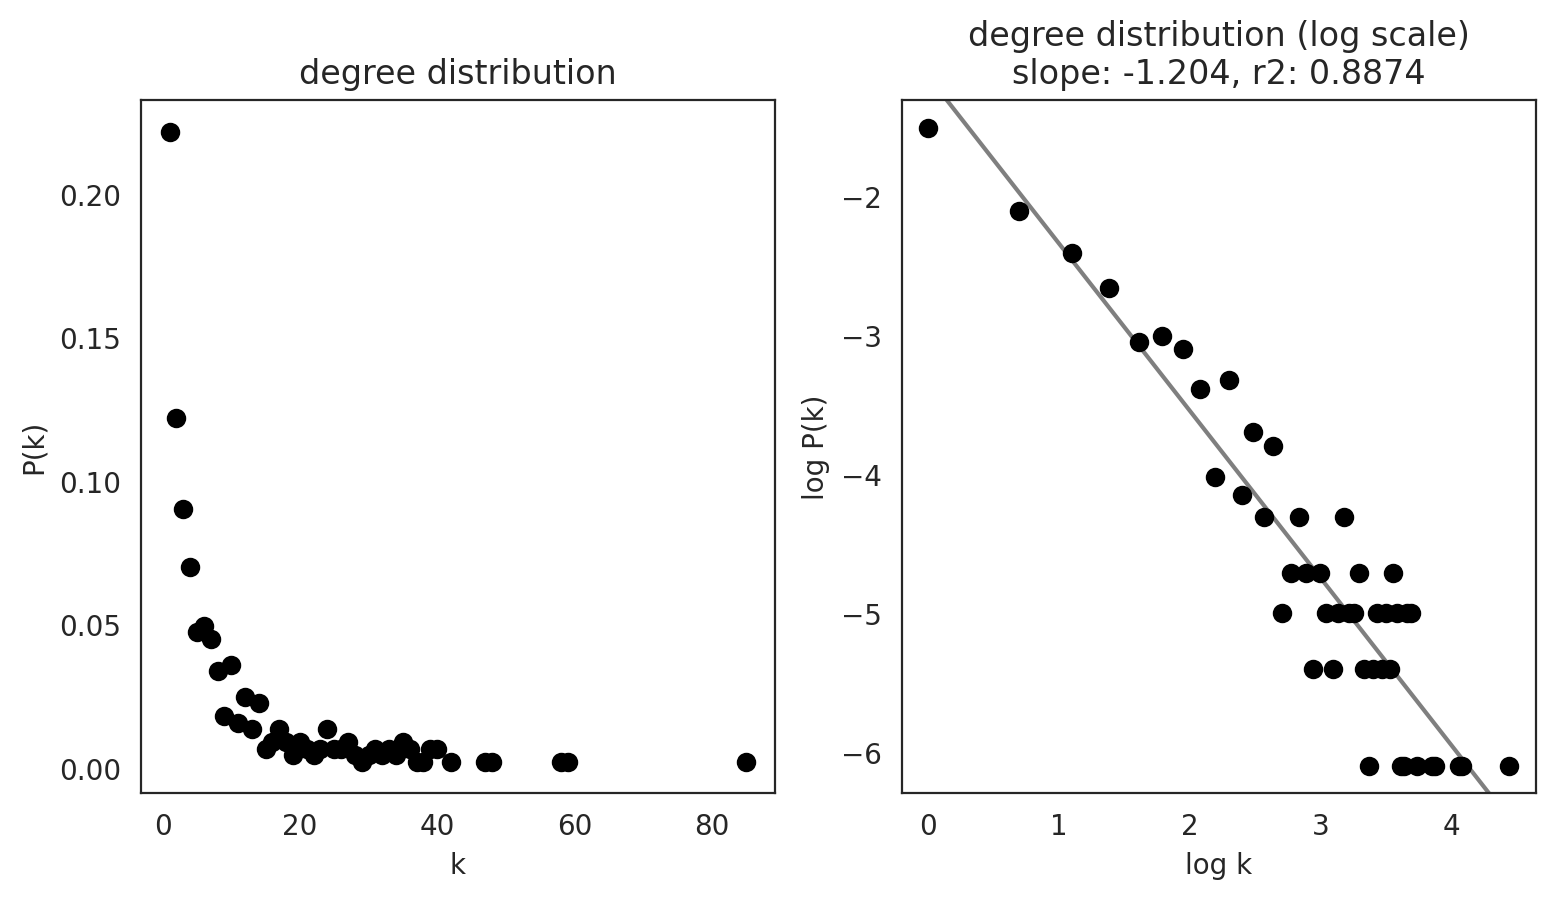

Notochord


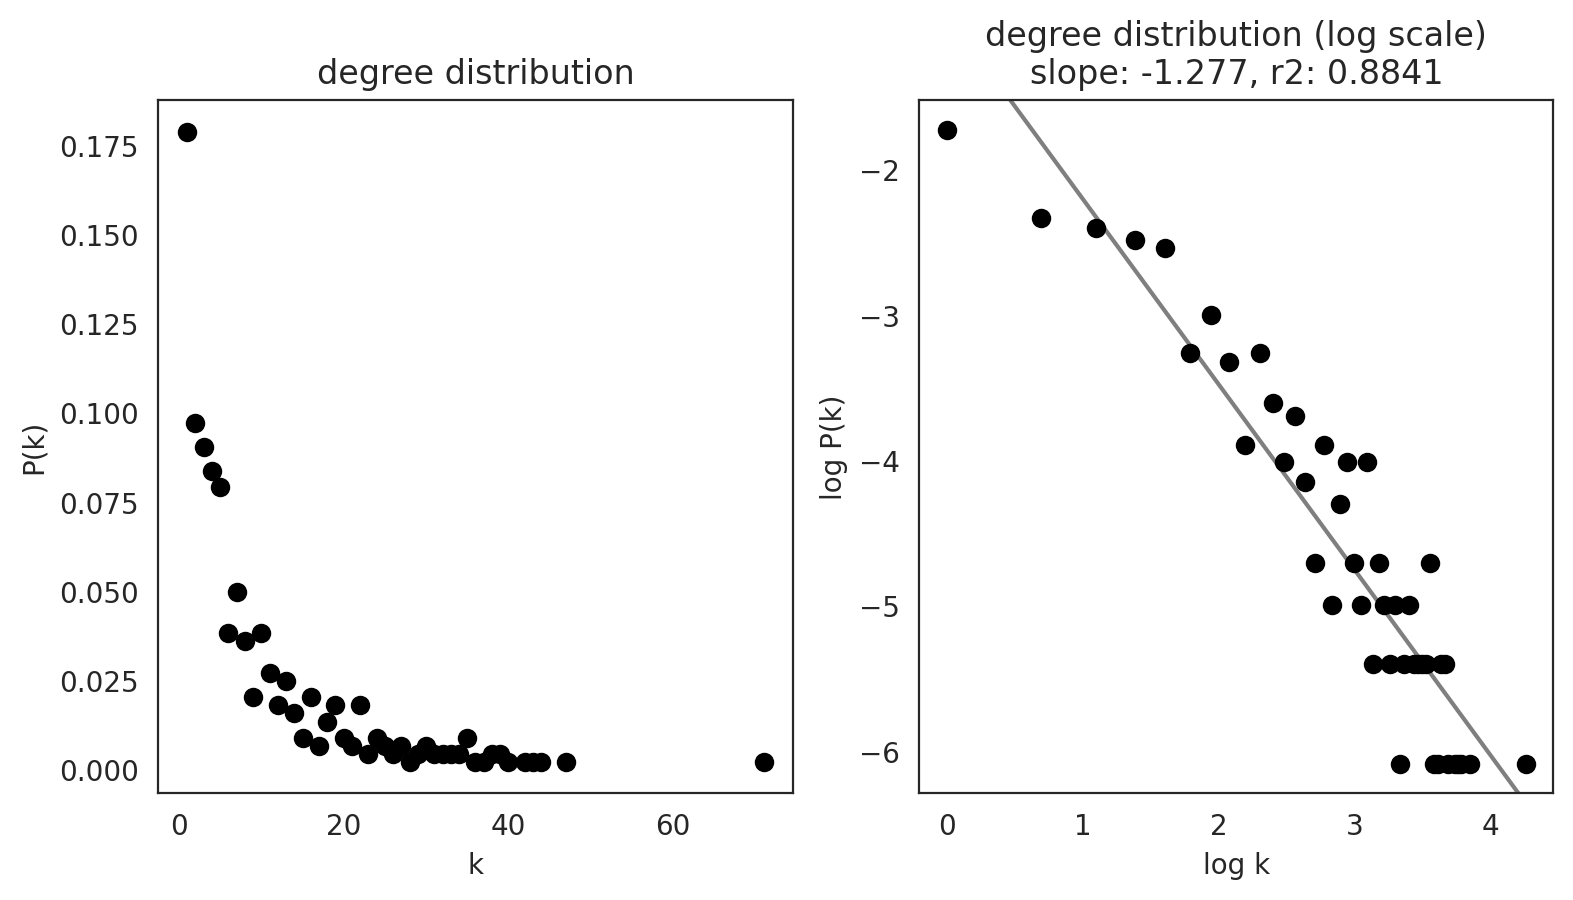

PSM


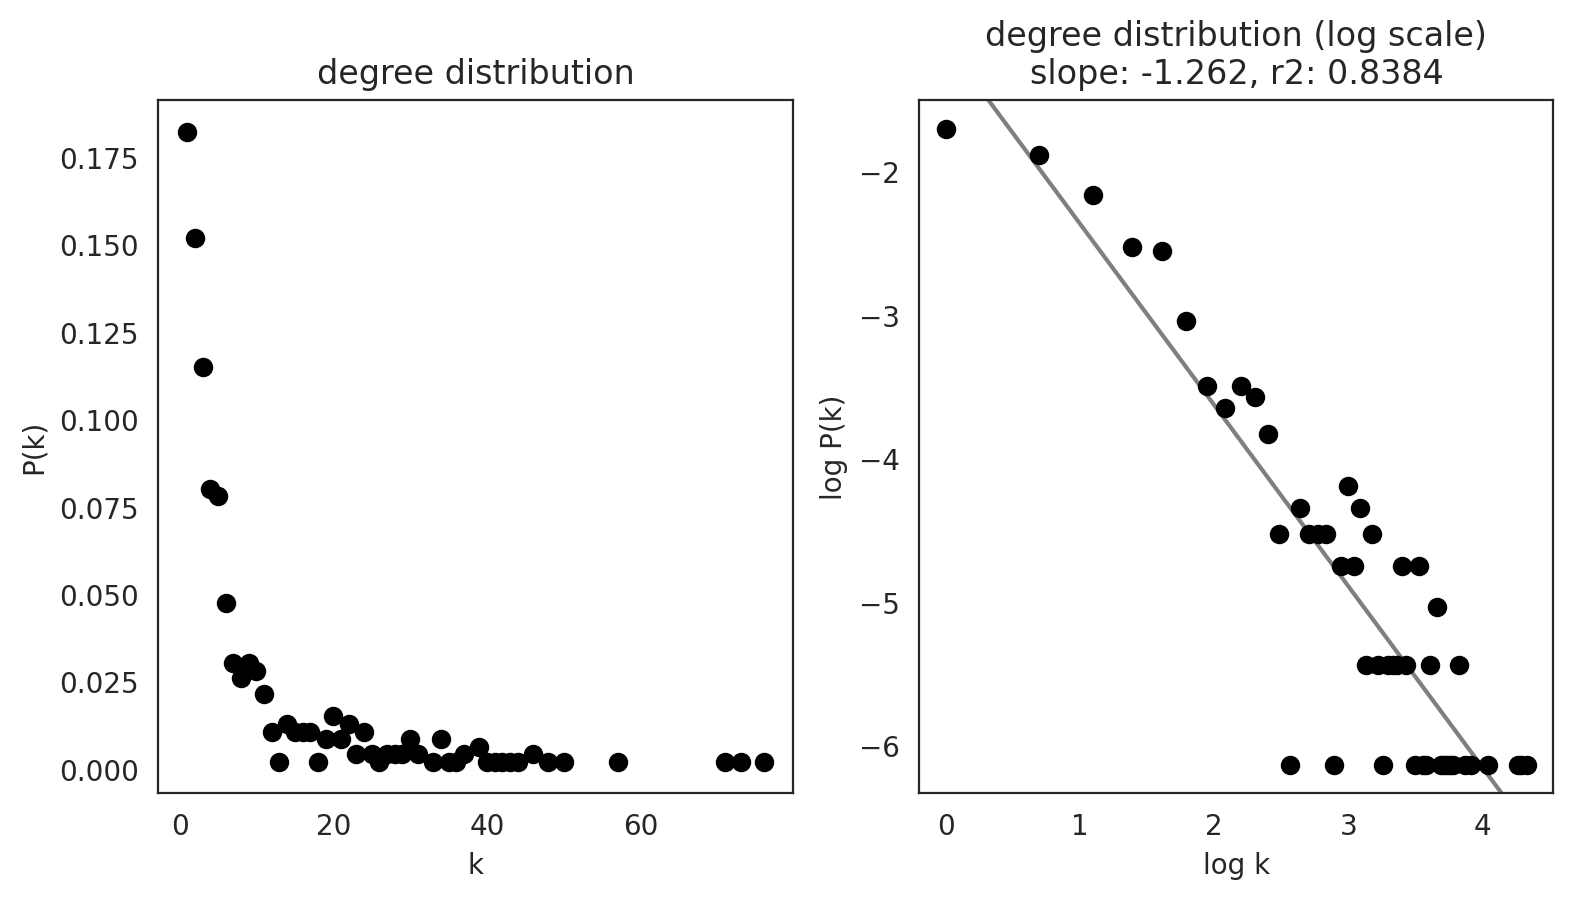

Somites


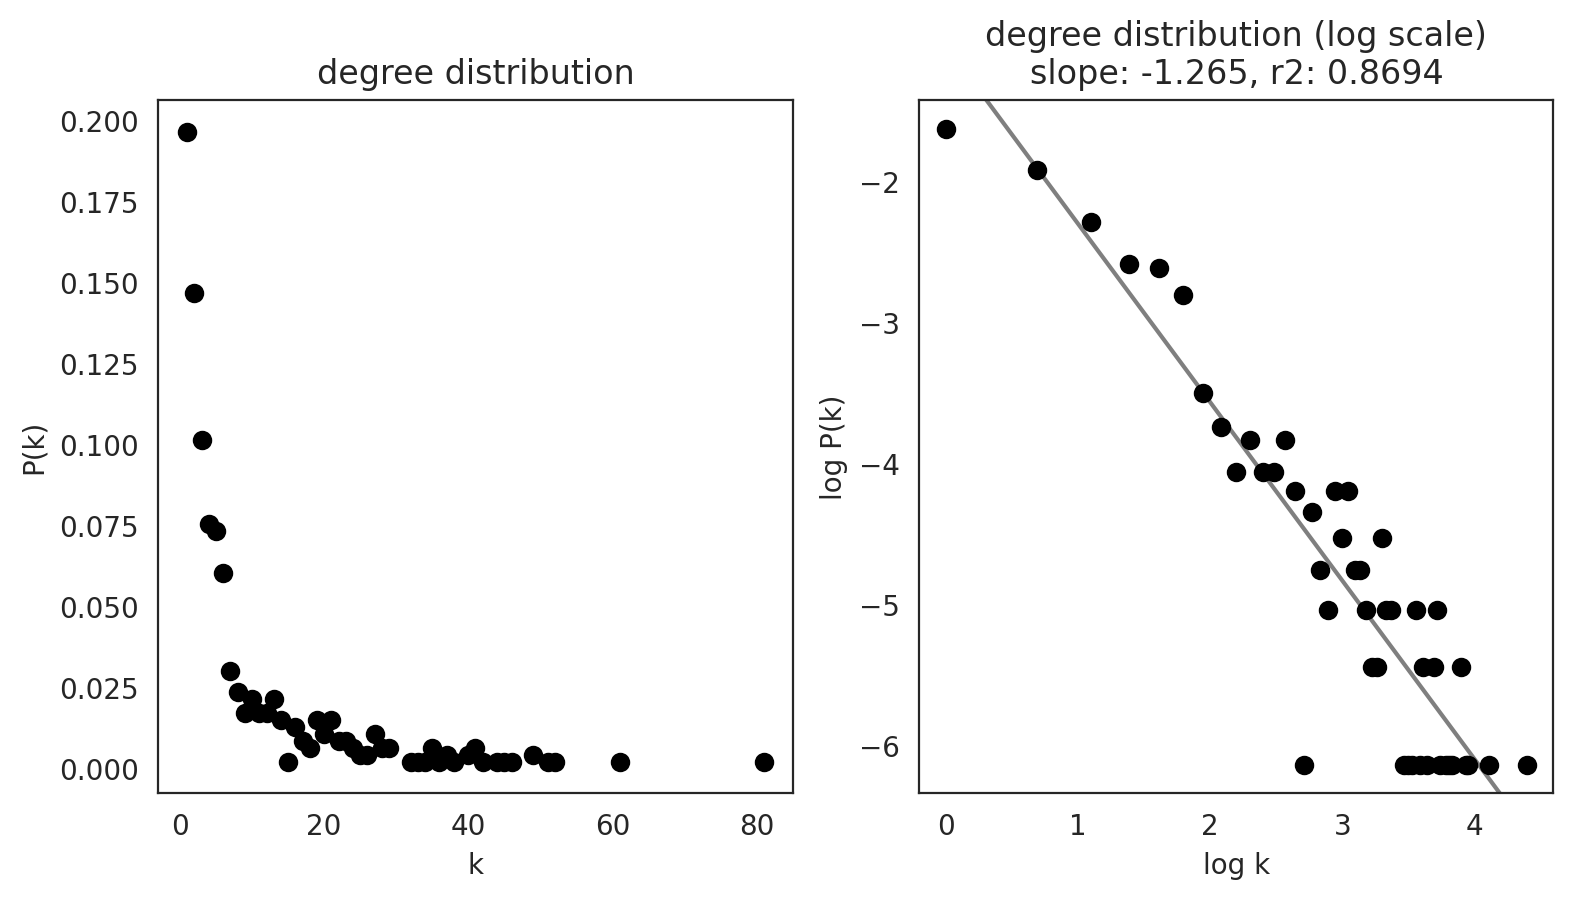

unassigned


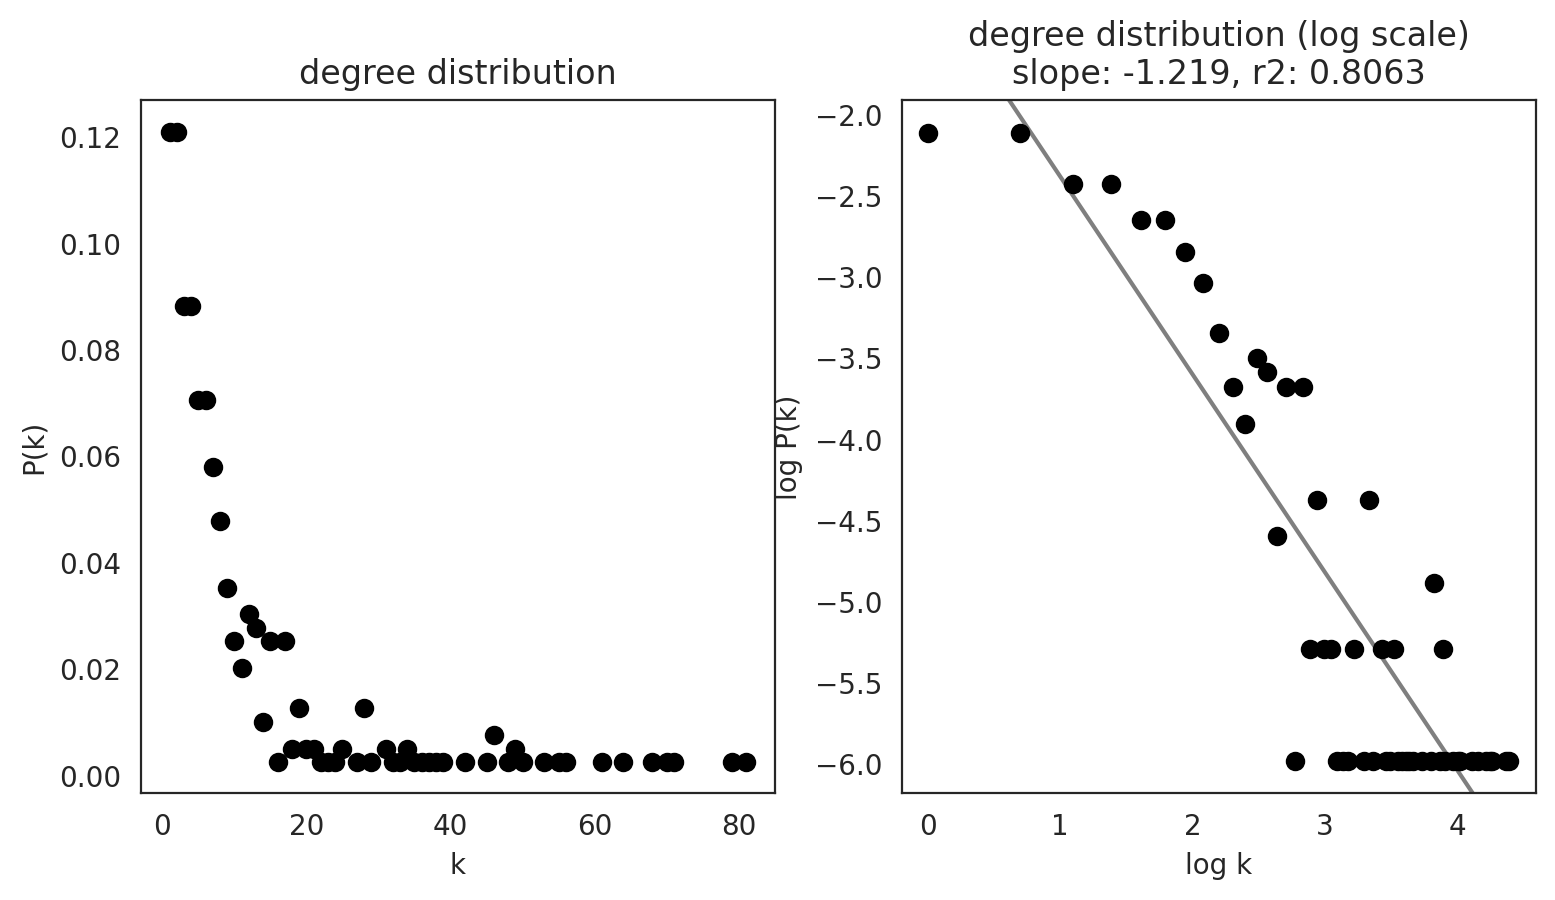

In [97]:
links.plot_degree_distributions(plot_model=True, 
                                               #save=f"{save_folder}/degree_distribution/",
                                               )

In [98]:
plt.rcParams["figure.figsize"] = [6, 4.5]

## 5.3. Calculate netowrk score

Next, we calculate several network score using some R libraries.
Please make sure that R libraries are installed in your PC before running the command below.

`n_jobs` parameter in `get_score` function controls number of jobs to run in parallel. -1 means using all processors. !!This parameter is only available on celloracle >= 0.9.1.

In [99]:
# Calculate network scores. It takes several minutes.
links.get_score(n_jobs=-1)

R path: /hpc/apps/x86_64/r/4.2/bin/R



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



checking R library installation: igraph -> OK


Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Welcome to linkcomm version 1.0-14

For a step-by-step guide to using linkcomm functions:
   > vignette(topic = "linkcomm", package = "linkcomm")
To run an interactive demo:
   > demo(topic = "linkcomm", package = "linkcomm")
To cite, see:
   > citation("linkcomm")
NOTE: To use linkcomm, you require read and write permissions in the current directory (see: help("getwd"), help("setwd"))



checking R library installation: linkcomm -> OK
checking R library installation: rnetcarto -> OK
processing... batch 1/1



Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Welcome to linkcomm version 1.0-14

For a step-by-step guide to using linkcomm functions:
   > vignette(topic = "linkcomm", package = "linkcomm")
To run an interactive demo:
   > demo(topic = "linkcomm", package = "linkcomm")
To cite, see:
   > citation("linkcomm")
NOTE: To use linkcomm, you require read and write permissions in the current directory (see: help("getwd"), help("setwd"))


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: RColorBrewer

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loadin

Adaxial_Cells: finished.


finished
finished
finished
finished
finished
finished
finished
finished


Differentiating_Neurons: finished.
Endoderm: finished.
Epidermal: finished.
Lateral_Mesoderm: finished.


finished
finished


Muscle: finished.
NMPs: finished.
Neural_Anterior: finished.
Neural_Crest: finished.
Neural_Posterior: finished.
Notochord: finished.
PSM: finished.
Somites: finished.
unassigned: finished.


finished


The score is stored as a attribute called "merged_score", and the score will also be saved in a folder in your computer.

In [100]:
links.merged_score.head()

degree_all  degree_in  degree_out  clustering_coefficient  \
hmga1a          61         41          20                0.094915   
sox13           25          6          19                0.108696   
fezf1            2          0           2                0.000000   
rfx4            11          0          11                0.054545   
sp5l            12          0          12                0.045455   

        clustering_coefficient_weighted  degree_centrality_all  \
hmga1a                         0.122667               0.130901   
sox13                          0.113753               0.053648   
fezf1                          0.000000               0.004292   
rfx4                           0.068102               0.023605   
sp5l                           0.049345               0.025751   

        degree_centrality_in  degree_centrality_out  betweenness_centrality  \
hmga1a              0.087983               0.042918                    4615   
sox13               0.012876               0.040773                     258   
fezf1               0.000000               0.004292                       0   
rfx4                0.000000               0.023605                       0   
sp5l                0.000000               0.025751                       0   

        closeness_centrality  eigenvector_centrality  page_rank  \
hmga1a              0.165763                1.000000   0.008392   
sox13               1.499493                0.118024   0.001878   
fezf1              11.432788                0.017219   0.001399   
rfx4                1.092157                0.092277   0.001399   
sp5l                0.121828                0.293099   0.001399   

        assortative_coefficient  average_path_length  community_random_walk  \
hmga1a                -0.193573             0.055859                      5   
sox13                 -0.193573             0.055859                      2   
fezf1                 -0.193573             0.055859                     14   
rfx4                  -0.193573             0.055859                      2   
sp5l                  -0.193573             0.055859                      8   

        module  connectivity  participation           role        cluster  
hmga1a       3      5.016178       0.351111  Connector Hub  Adaxial_Cells  
sox13        2      3.026928       0.229167  Connector Hub  Adaxial_Cells  
fezf1        0     -0.949736       0.500000     Peripheral  Adaxial_Cells  
rfx4         2      0.899051       0.165289     Peripheral  Adaxial_Cells  
sp5l         3      0.019928       0.416667     Peripheral  Adaxial_Cells

## 6.4. Save

Save processed GRN. We use this file in the next notebook; "in silico perturbation with GRNs". 

In [101]:
output_filepath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/"

In [102]:
# Save Links object.
links.to_hdf5(file_path=output_filepath + "08_TDR119_celltype_GRNs.celloracle.links")

In [32]:
# # You can load files with the following command.
# links = co.load_hdf5(file_path=output_filepath + "08_TDR118_celltype_GRNs.celloracle.links")

In [103]:
links.filtered_links

{'Adaxial_Cells':         source            target  coef_mean  coef_abs             p      -logp
 165686  hmga1a  si:ch73-281n10.2   0.102975  0.102975  9.175591e-13  12.037366
 153976  hmga1a             rpl7a   0.098991  0.098991  1.182754e-13  12.927106
 203625   sox13           zbtb16a   0.075005  0.075005  1.322159e-12  11.878716
 171219   fezf1             slit3   0.070528  0.070528  2.155617e-13  12.666428
 203617    rfx4           zbtb16a   0.069373  0.069373  2.059796e-09   8.686176
 ...        ...               ...        ...       ...           ...        ...
 24224     hic1              cdon   0.010628  0.010628  2.232914e-07   6.651128
 161965    nfic              sgcd   0.010628  0.010628  2.360342e-16  15.627025
 40773    pax6a              dag1   0.010626  0.010626  1.499975e-09   8.823916
 136221  hoxb7a             pcdh8   0.010625  0.010625  2.345336e-11  10.629795
 105613   smad1             mafbb   0.010621  0.010621  2.877151e-11  10.541037
 
 [2000 rows x 6 colum

# 7. Network analysis; Network score for each gene
The Links class has many functions to visualize network score.
See the documentation for the details of the functions.

## 7.1. Network score in each cluster


We have calculated several network scores using different centrality metrics.
We can use the centrality score to identify key regulatory genes because centrality is one of the important indicators of network structure (https://en.wikipedia.org/wiki/Centrality). 

Let's visualize genes with high network centrality.


In [69]:
oracle.adata.var_names

Index(['msgn1', 'BX649468.1', 'ripply2', 'chrm2a', 'FAR2', 'phlda1', 'pde3a',
       'CU928073.1', 'cd9b', 'ntf3',
       ...
       'fibina', 'rbl2', 'irx5b', 'irx3b', 'urahb', 'igl4v10', 'NC-002333.17',
       'mt-co2', 'mt-atp6', 'mt-co3'],
      dtype='object', length=3000)

In [64]:
# Check cluster name
links.cluster

['Adaxial_Cells',
 'Differentiating_Neurons',
 'Endoderm',
 'Epidermal',
 'Lateral_Mesoderm',
 'Muscle',
 'NMPs',
 'Neural_Anterior',
 'Neural_Crest',
 'Neural_Posterior',
 'Notochord',
 'PSM',
 'Somites',
 'unassigned']

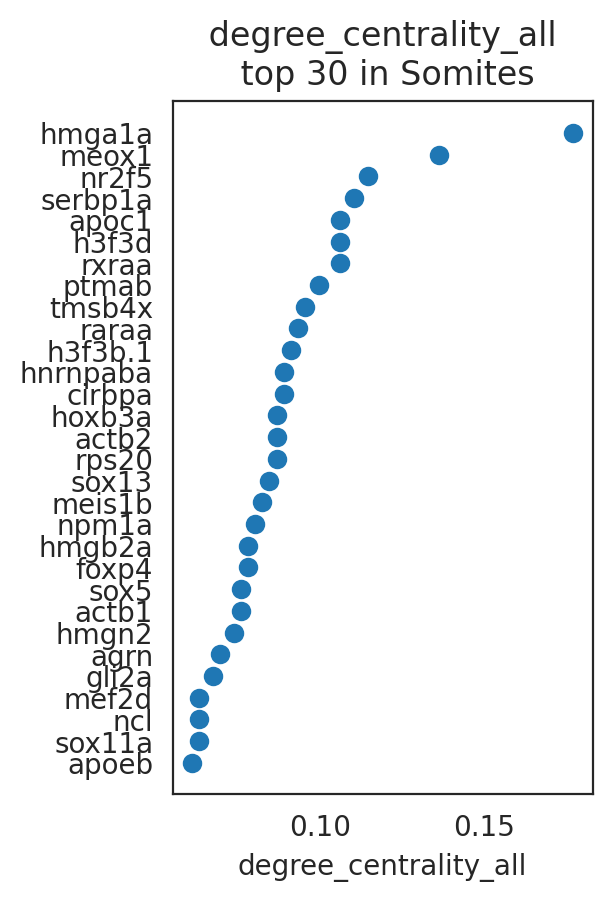

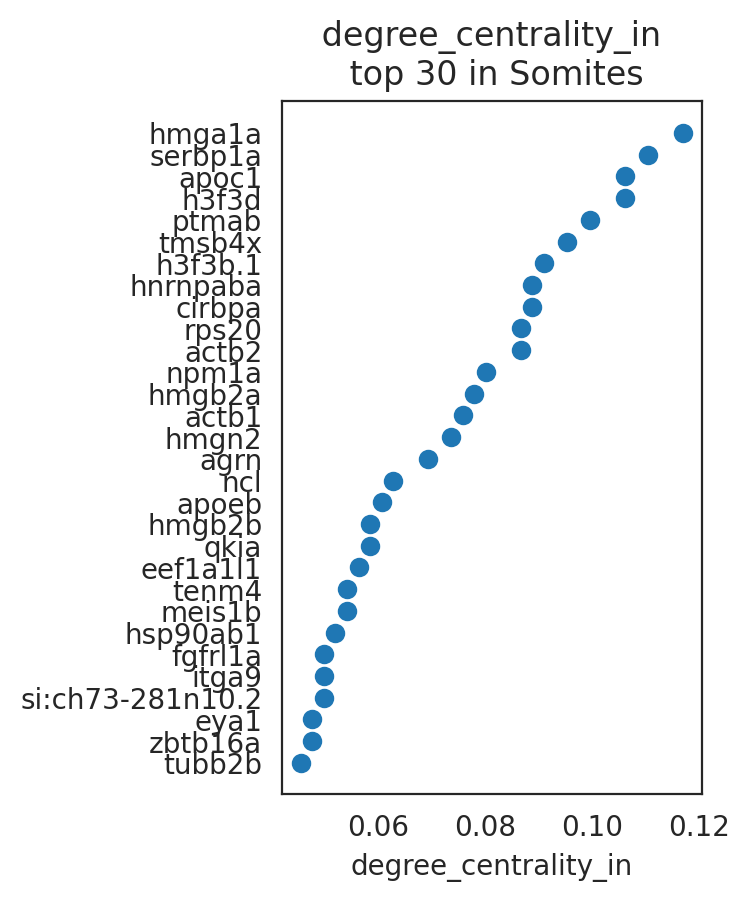

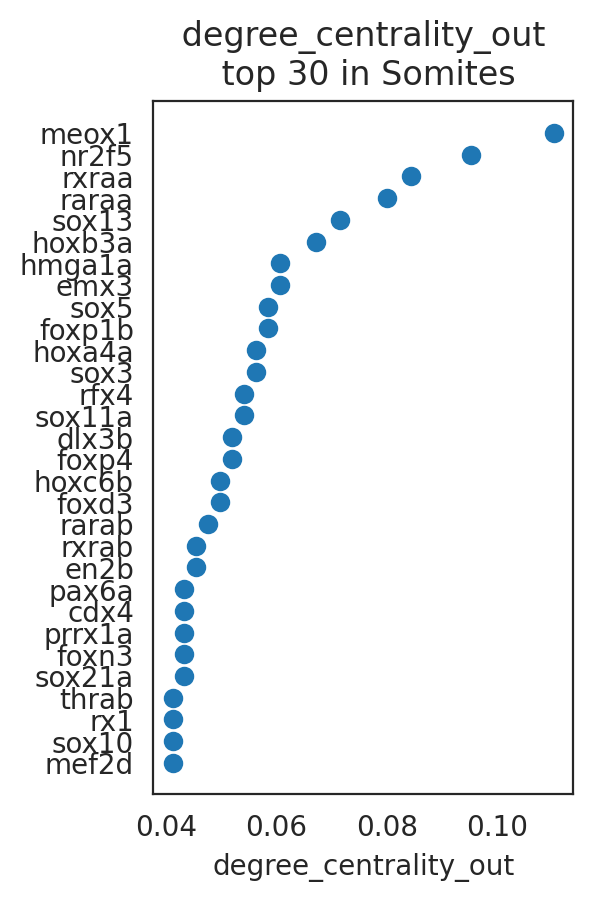

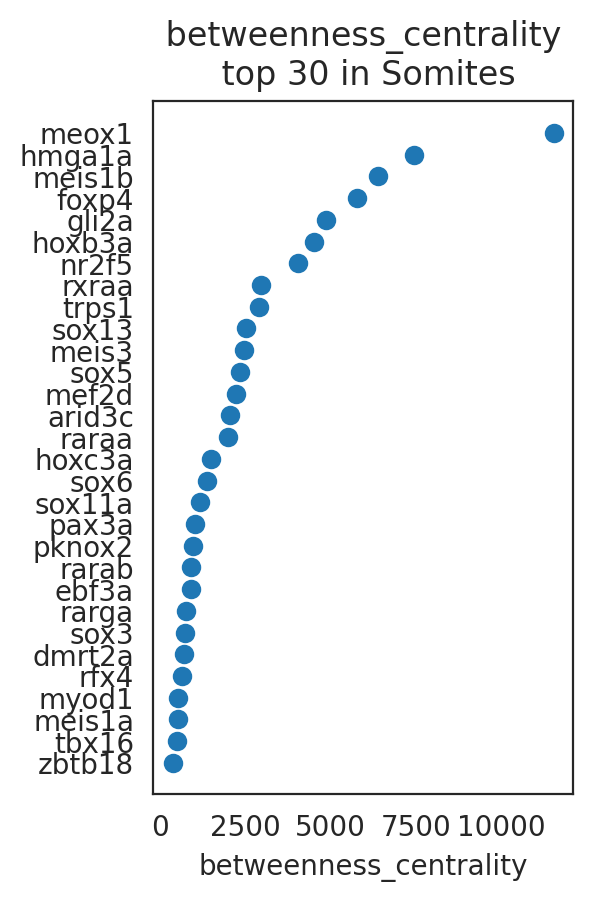

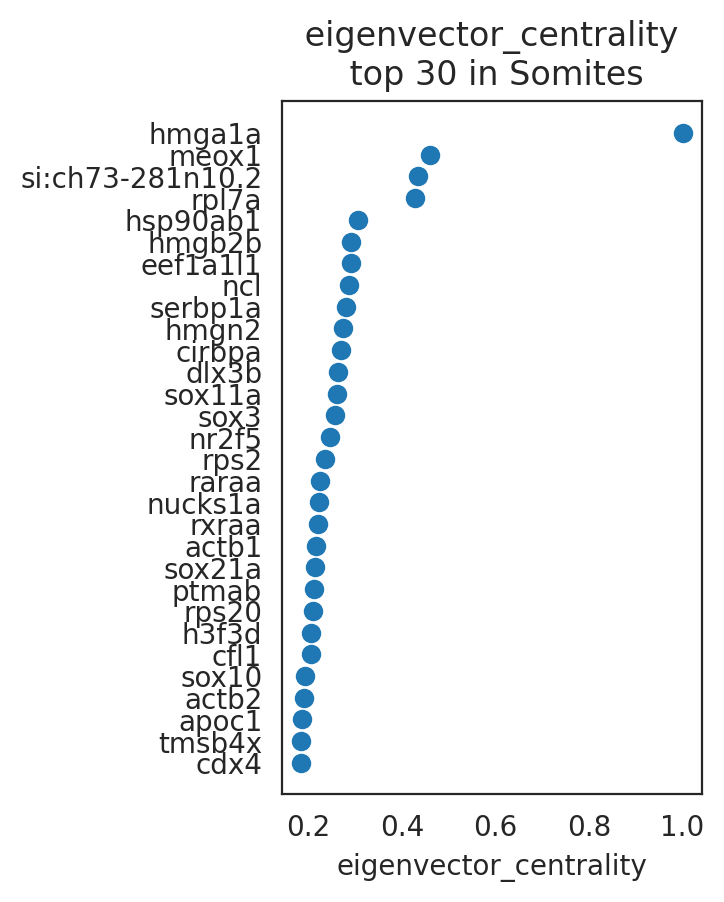

In [104]:
# Visualize top n-th genes that have high scores.
links.plot_scores_as_rank(cluster="Somites", n_gene=30)#, 
                          #save="TDR118_15somite_GRN_coarse_celltypes/ranked_score")

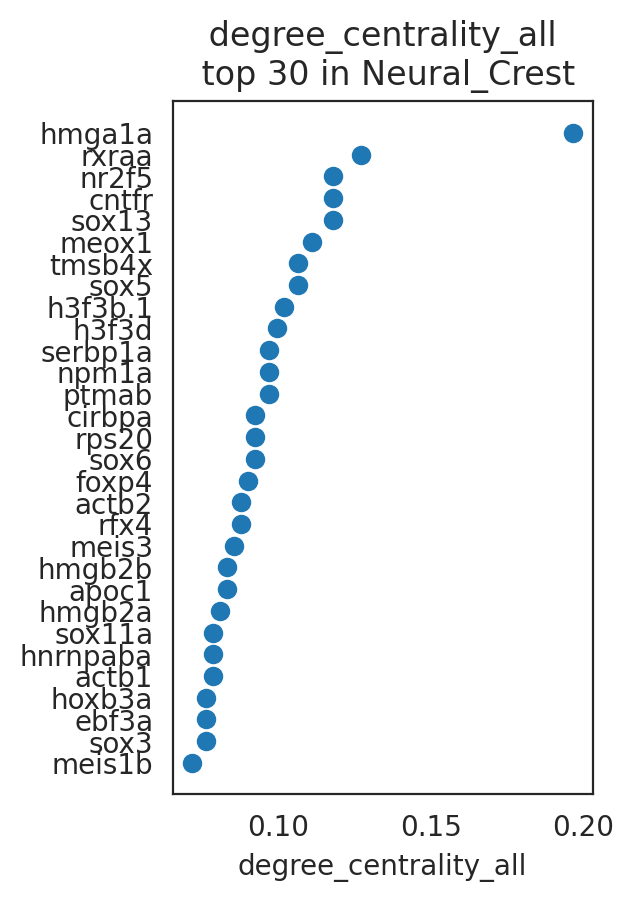

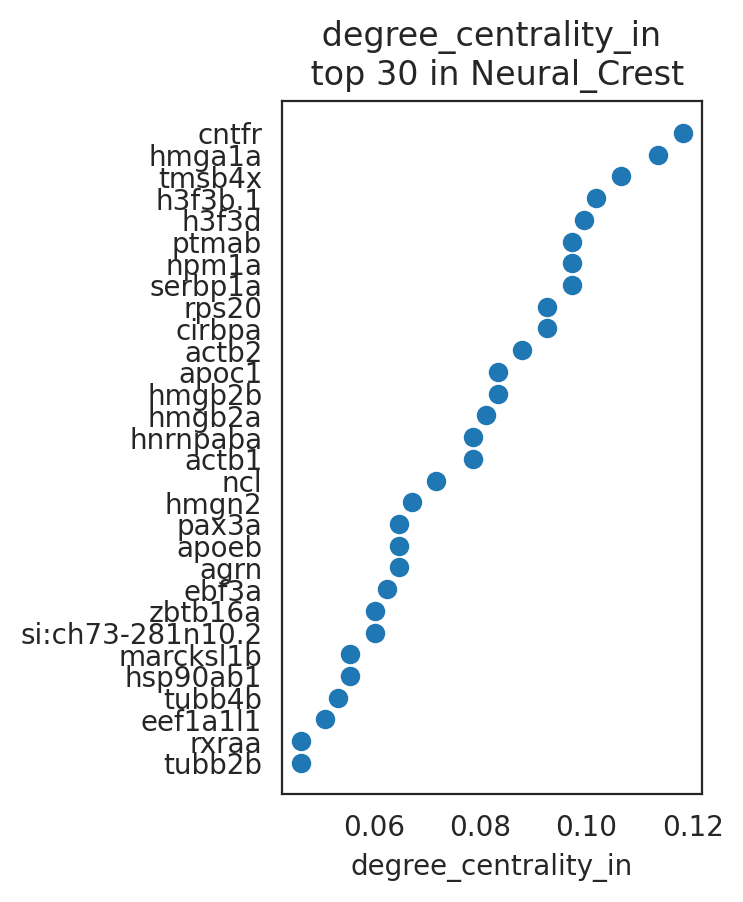

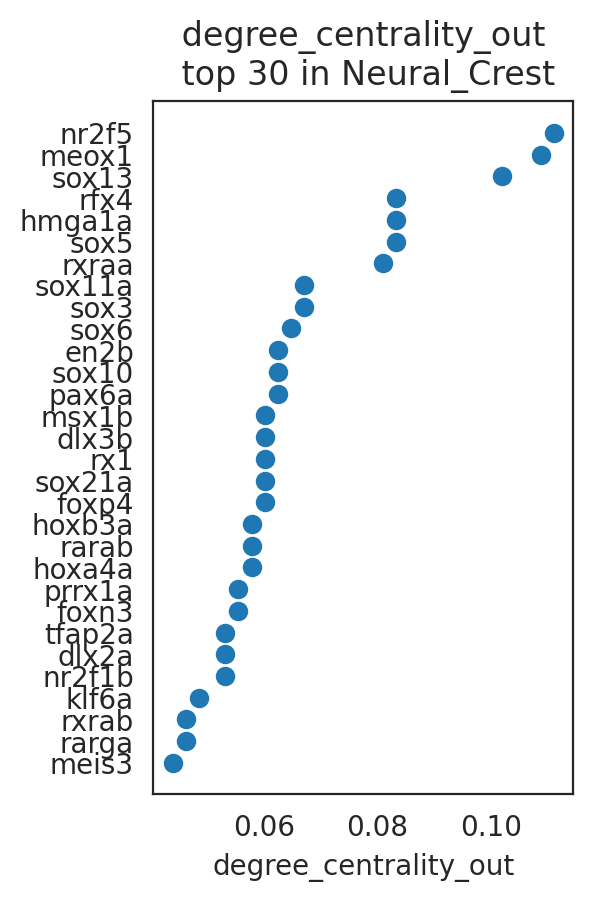

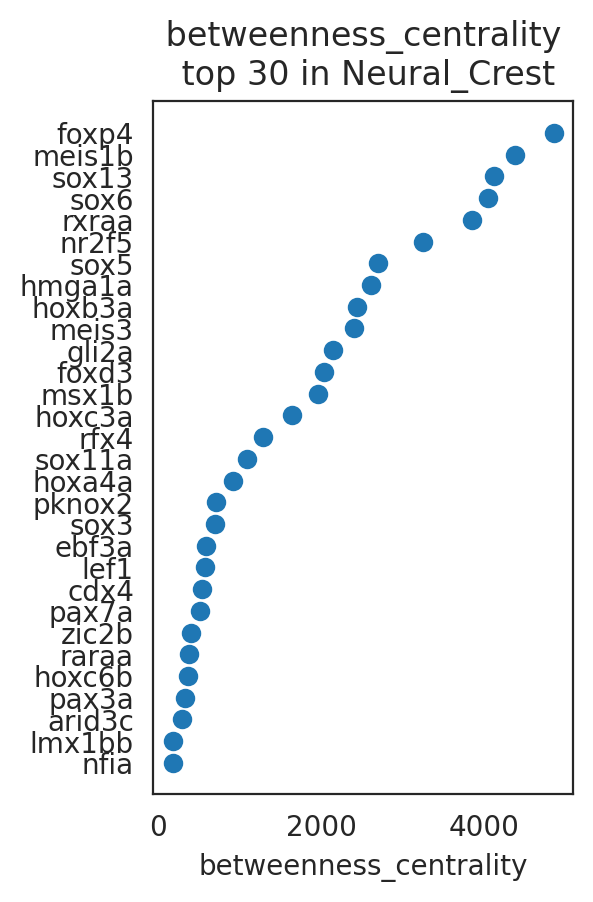

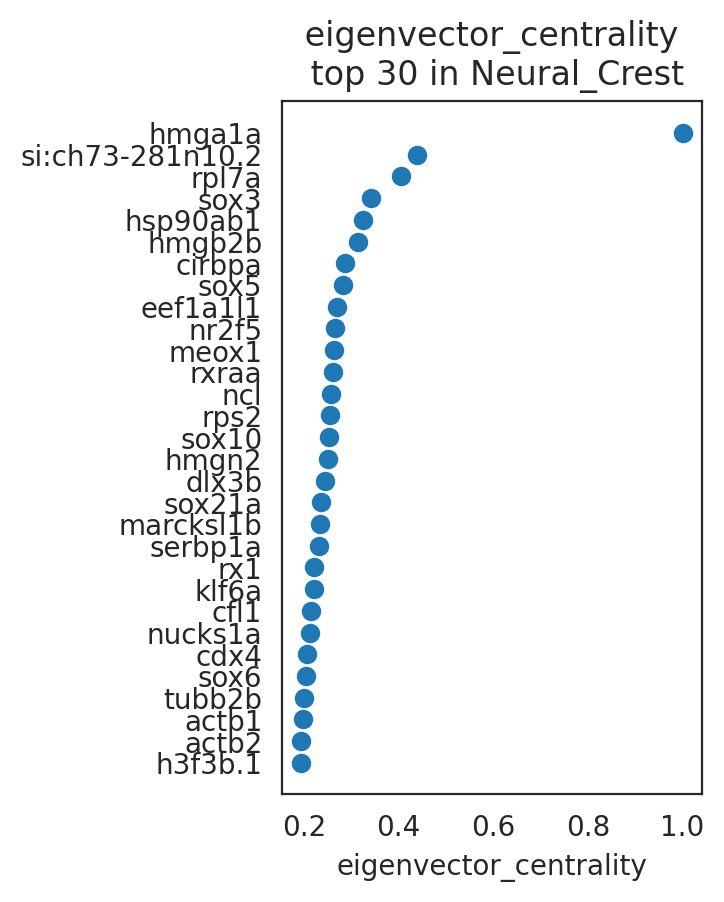

In [109]:
# Visualize top n-th genes that have high scores.
links.plot_scores_as_rank(cluster="Neural_Crest", n_gene=30)#, 
                          #save="TDR118_15somite_GRN_coarse_celltypes/ranked_score")

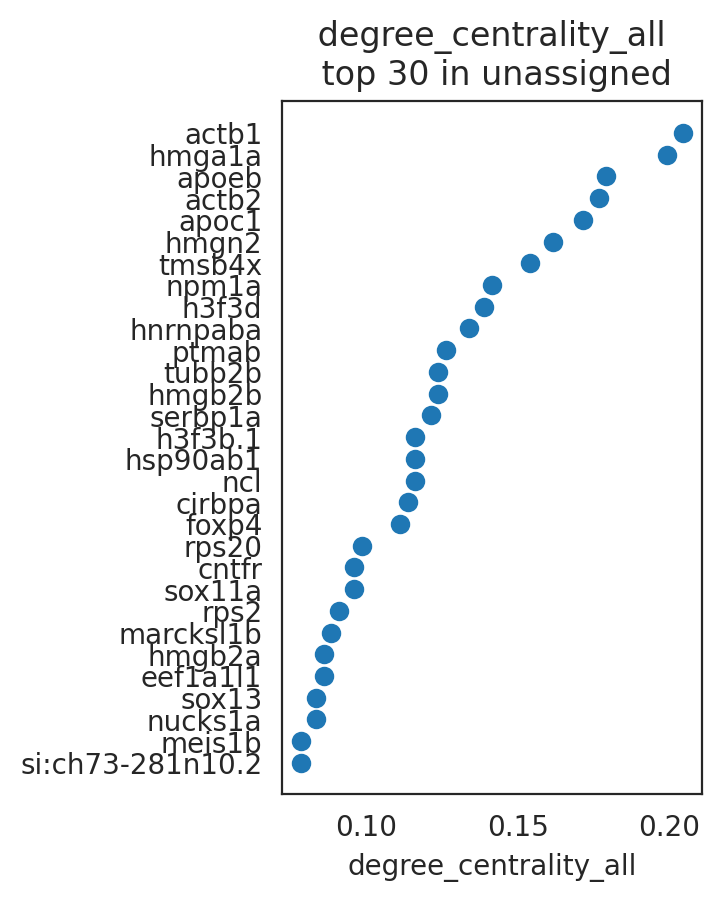

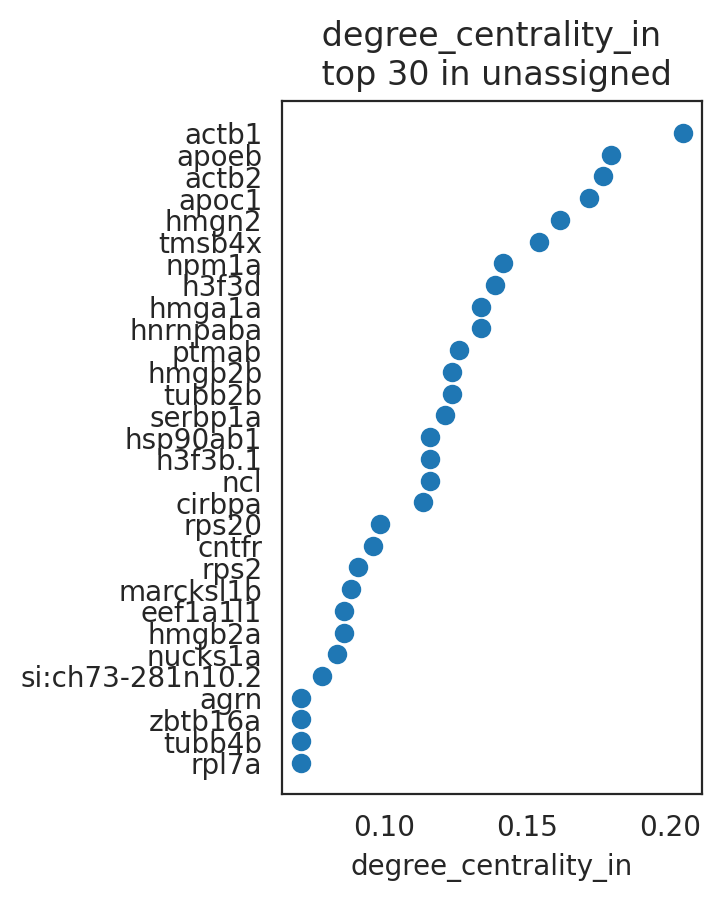

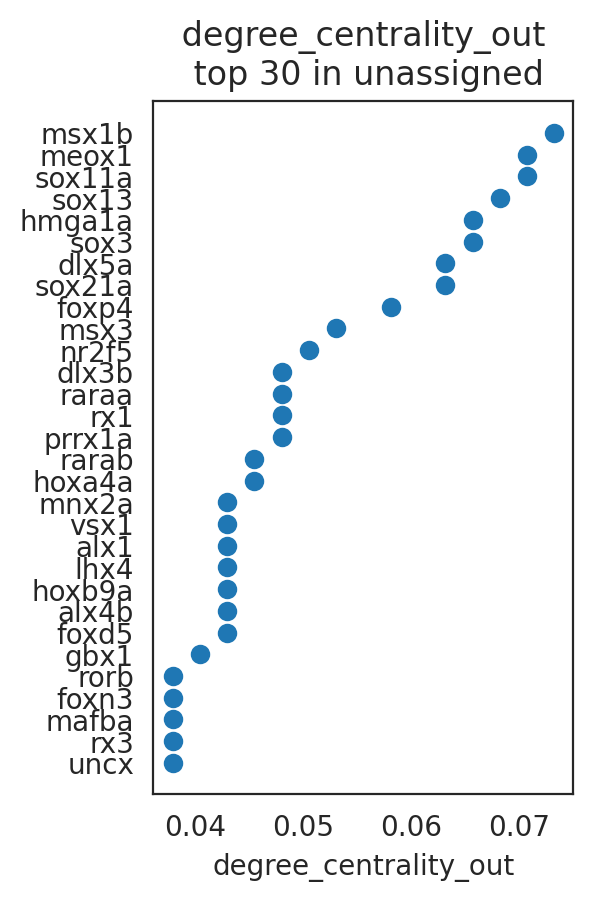

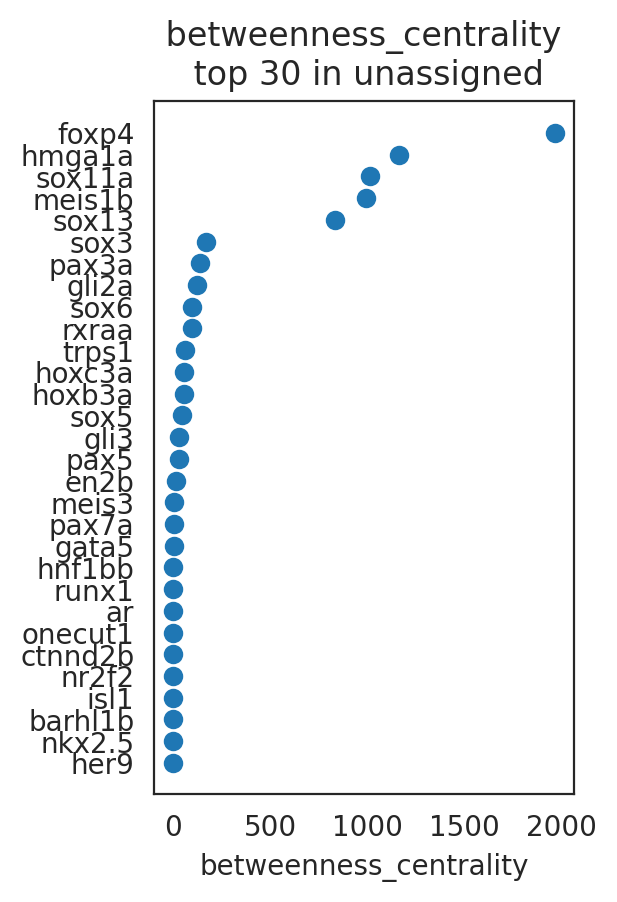

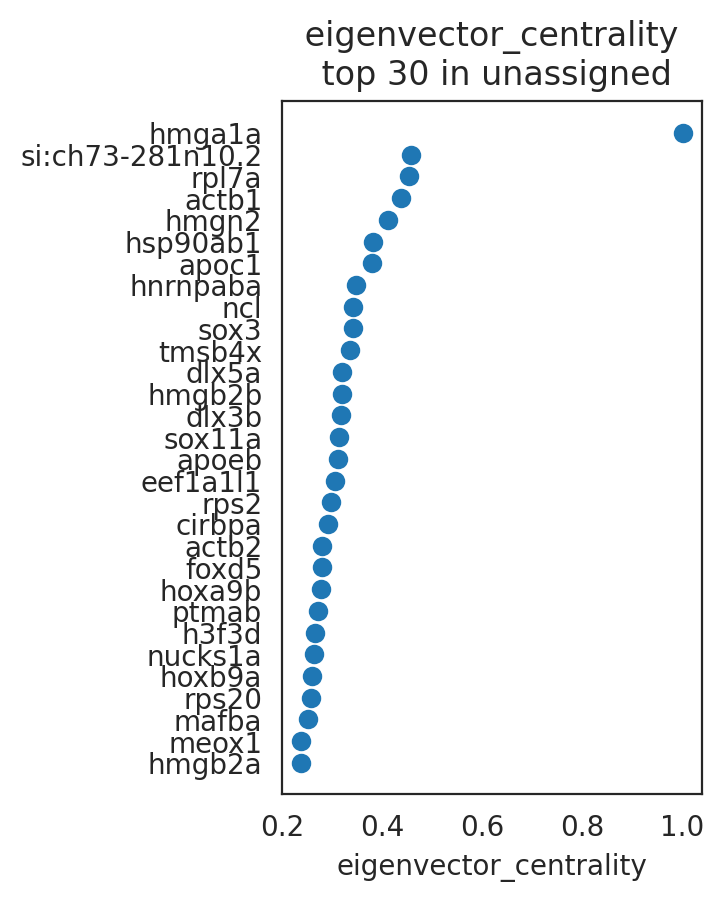

In [114]:
# Visualize top n-th genes that have high scores.
links.plot_scores_as_rank(cluster="unassigned", n_gene=30)#, 
                          #save="TDR118_15somite_GRN_coarse_celltypes/ranked_score")

## 7.2. Network score comparison between two clusters


By comparing network scores between two clusters, we can analyze differences in GRN structure.

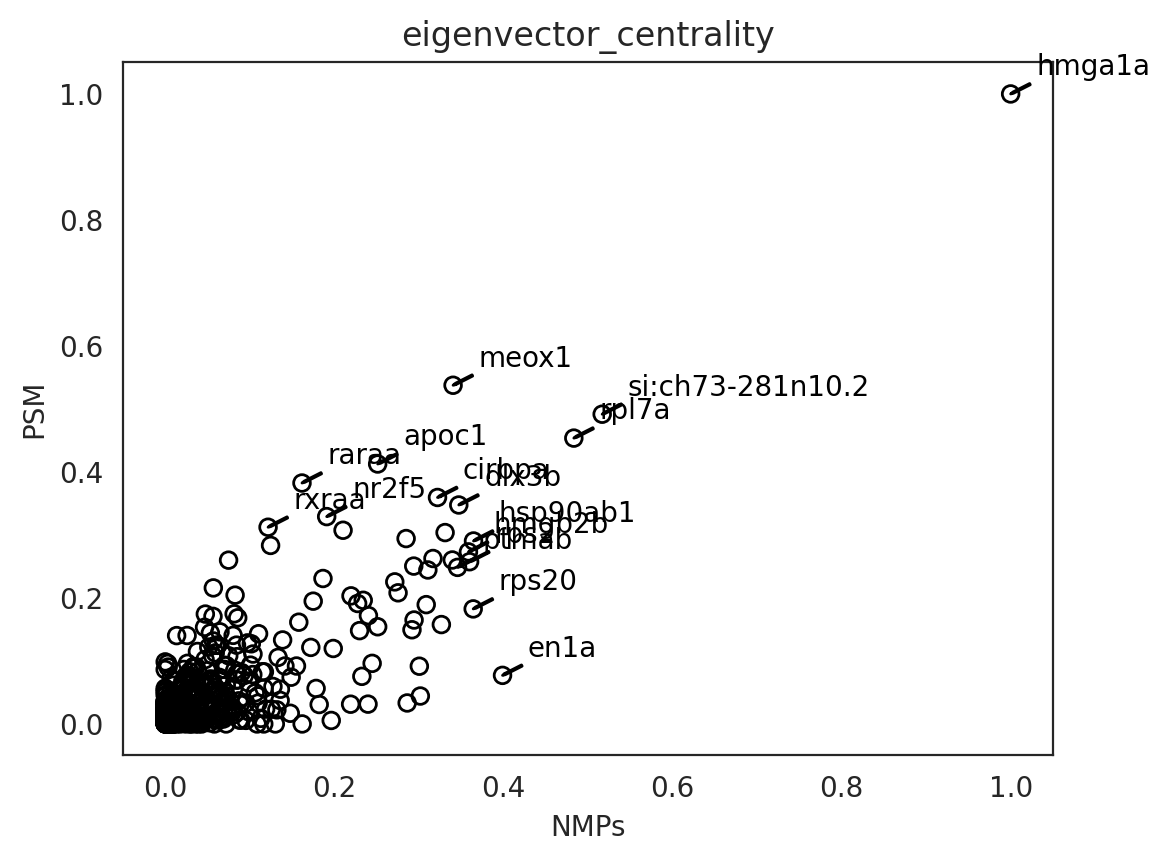

In [72]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="eigenvector_centrality",
                               cluster1="NMPs", cluster2="PSM", 
                               percentile=98) #, save="TDR118_15somite_GRN_coarse_celltypes/score_comparison")

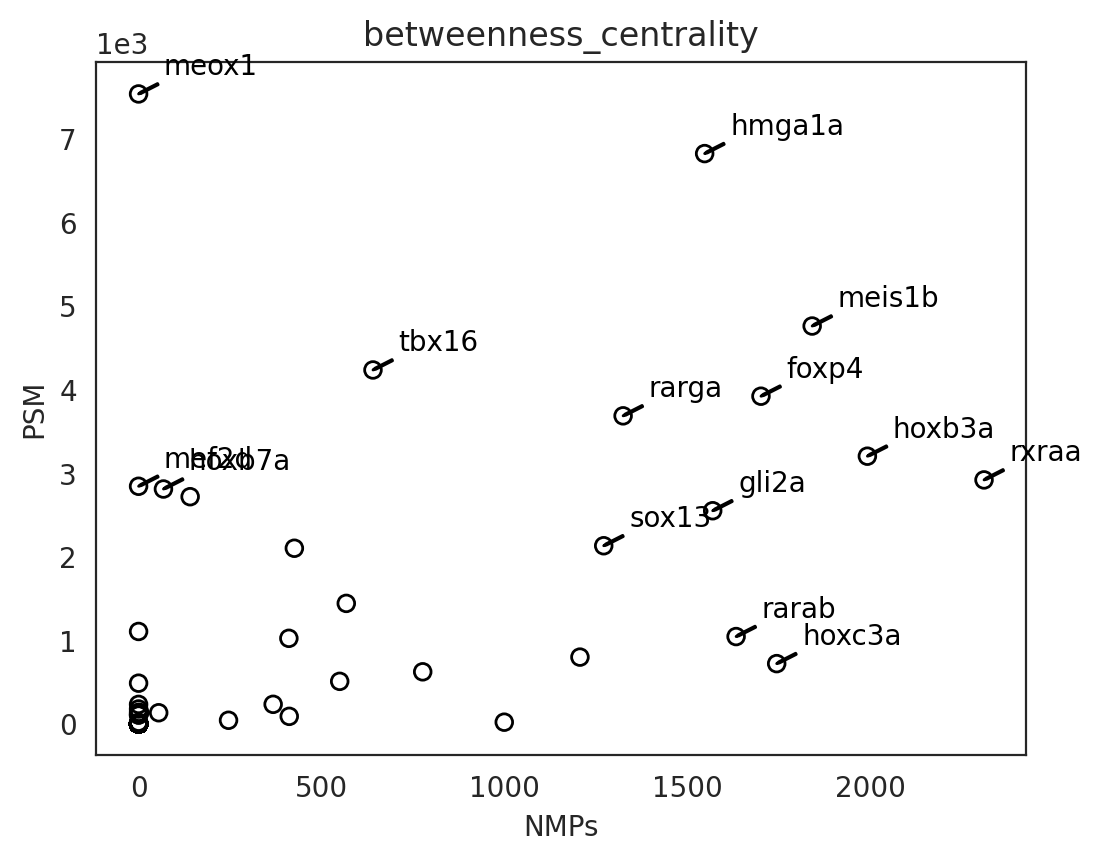

In [73]:

plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="betweenness_centrality",
                               cluster1="NMPs", cluster2="PSM", 
                               percentile=98) #, save="TDR118_15somite_GRN_coarse_celltypes/score_comparison")

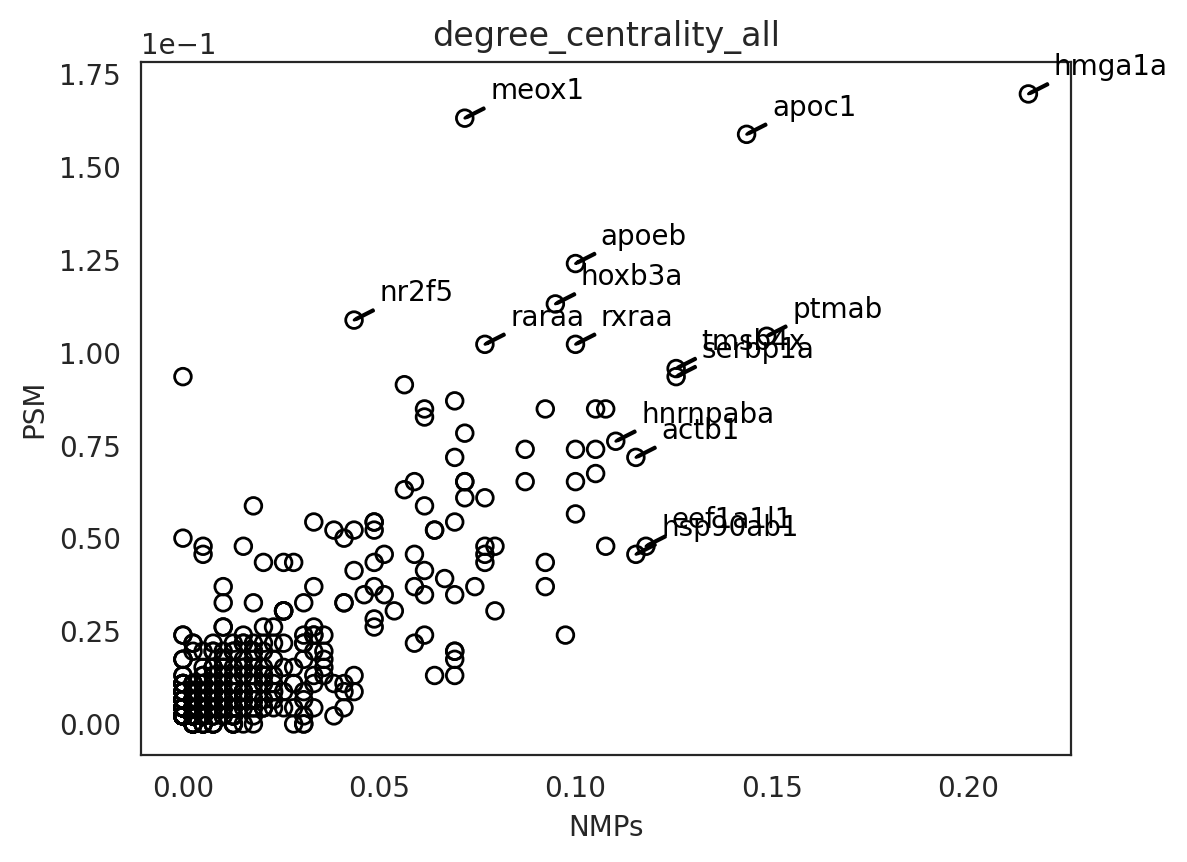

In [105]:
plt.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1="NMPs", cluster2="PSM", 
                               percentile=98) #, save="TDR118_15somite_GRN_coarse_celltypes/score_comparison")

## 7.3. Network score dynamics
In the following session, we focus on how a gene's network score changes during the differentiation.

Using Gata2, we will demonstrate how you can visualize networks scores for a single gene.

Gata2 is known to play an essential role in the early MEP and GMP populations. .

meox1


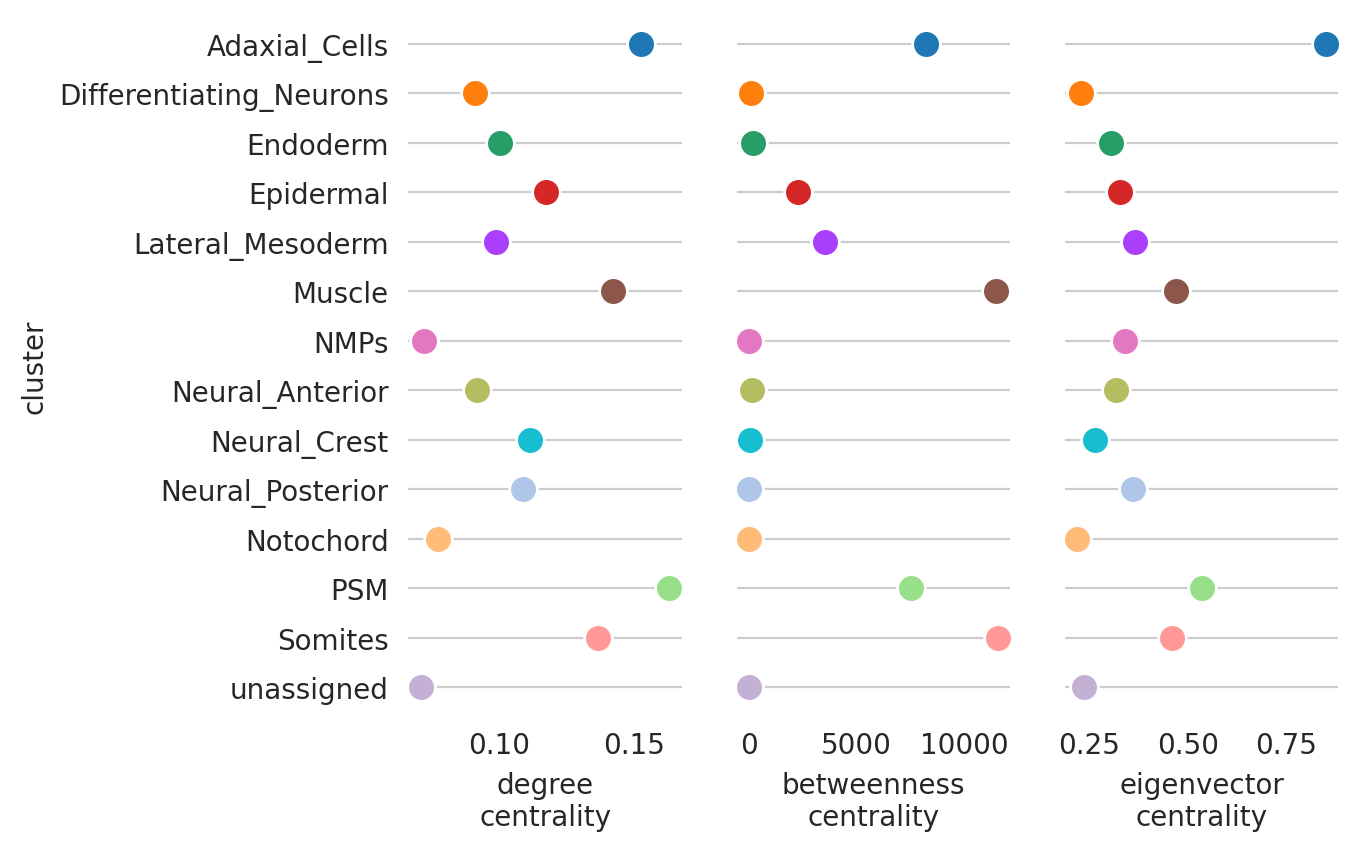

In [106]:
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="meox1")#, save="TDR118_15somite_GRN_coarse_celltypes/network_score_per_gene/")

If a gene have no connections in a cluster, it is impossible to calculate network degree scores.
Thus the scores will not be shown.
For example, Cebpa have no connection in the erythloids clusters, and there is no degree scores for Cebpa in these clusters as follows.

pax6a


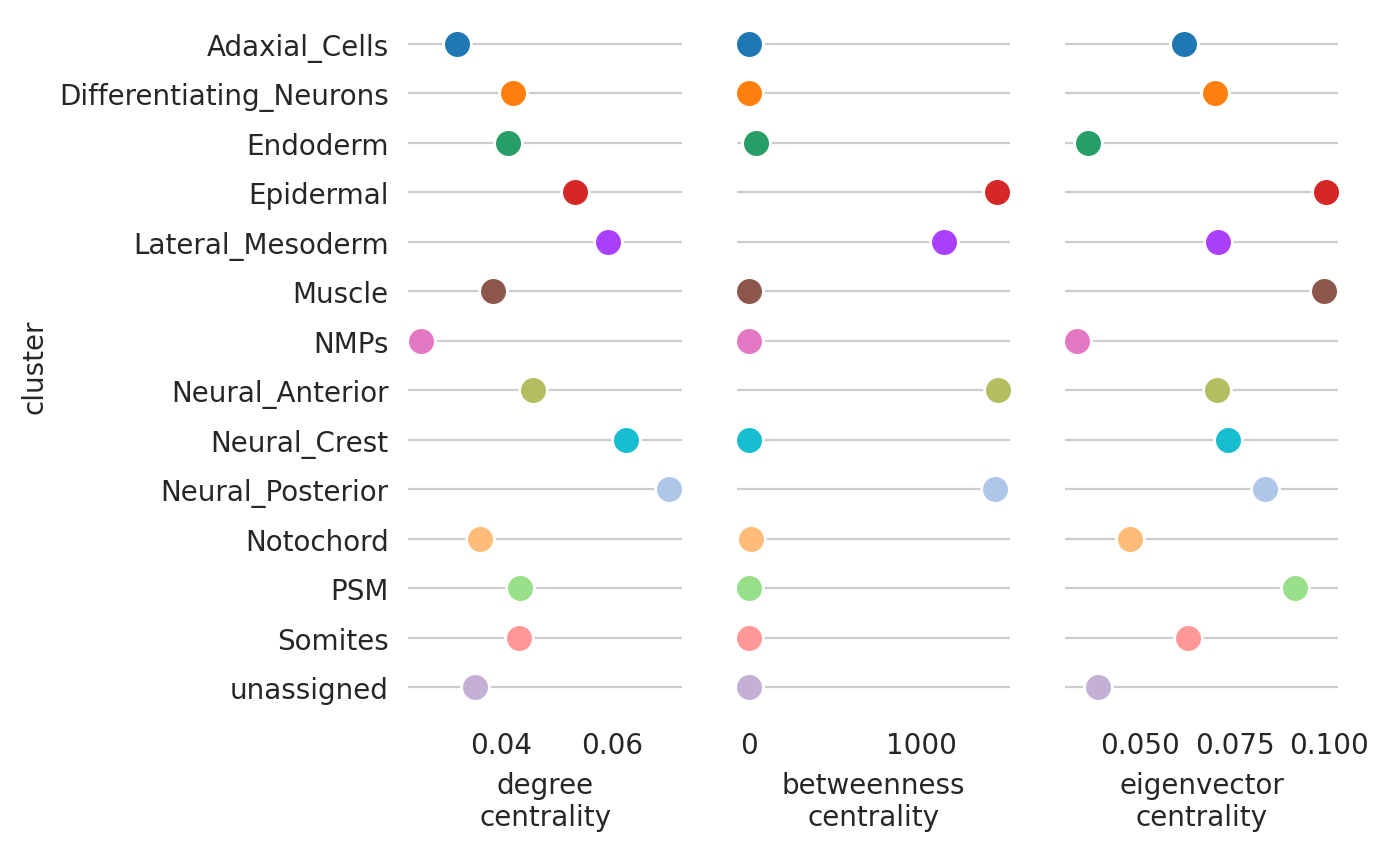

In [107]:
links.plot_score_per_cluster(goi="pax6a")

You can check filtered network edge as follows.

In [76]:
cluster_name = "NMPs"
filtered_links_df = links.filtered_links[cluster_name]
filtered_links_df.head()

source            target  coef_mean  coef_abs             p      -logp
171664  nfatc1             slit3   0.167520  0.167520  6.099314e-13  12.214719
166079  hmga1a  si:ch73-281n10.2   0.134133  0.134133  8.328944e-17  16.079410
171665  creb5b             slit3   0.118250  0.118250  2.857576e-08   7.544002
27748     her9            cirbpa   0.109563  0.109563  5.209617e-10   9.283194
154387   mafbb             rpl7a   0.091194  0.091194  7.477311e-13  12.126255

(array([  4.,   6.,  19., 238.,   0., 479., 963., 190.,  63.,  16.,  10.,
          5.,   2.,   1.,   1.,   1.,   1.,   0.,   0.,   1.]),
 array([-0.05427987, -0.04318989, -0.03209991, -0.02100993, -0.00991995,
         0.00117003,  0.01226001,  0.02334999,  0.03443997,  0.04552995,
         0.05661993,  0.06770991,  0.07879989,  0.08988987,  0.10097985,
         0.11206983,  0.12315981,  0.13424979,  0.14533977,  0.15642975,
         0.16751973], dtype=float32),
 <BarContainer object of 20 artists>)

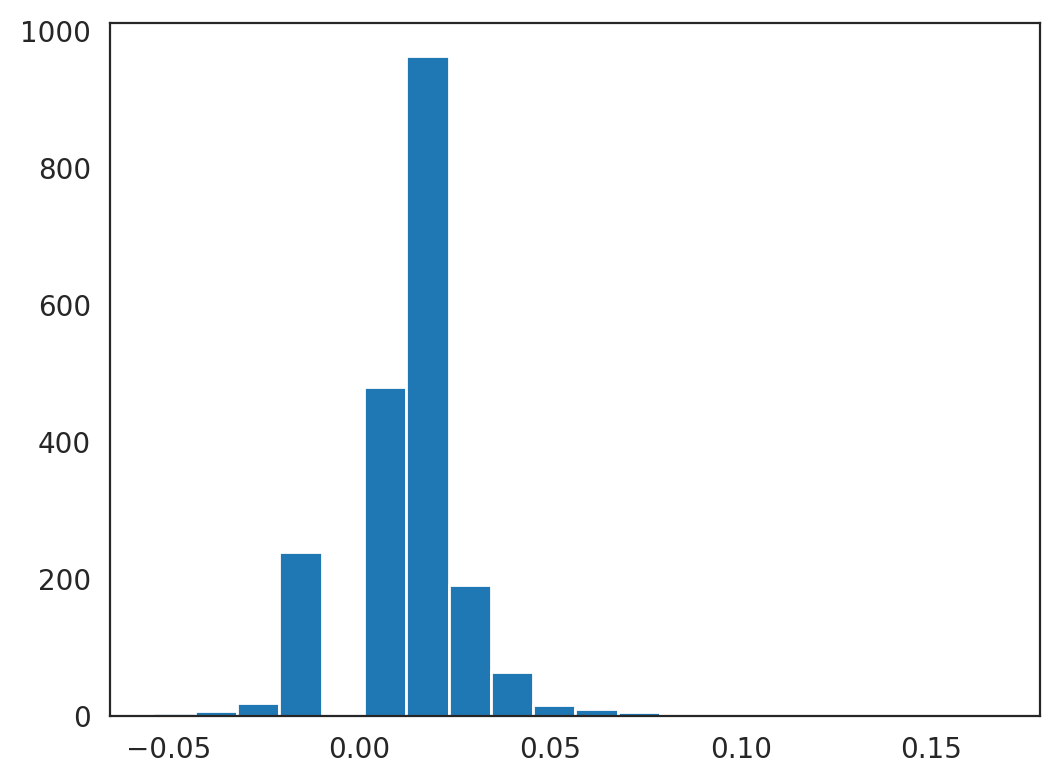

In [79]:
plt.hist(filtered_links_df.coef_mean, bins=20)

## data exploration - with Alejandro on 7/20/2023

In [77]:
filtered_links_df.value_counts()

source  target   coef_mean  coef_abs  p             -logp    
alx4b   actb2     0.011972  0.011972  4.668636e-10  9.330810     1
pax6b   ctnnd2b   0.019362  0.019362  1.399752e-12  11.853949    1
        nova2     0.016700  0.016700  9.239955e-11  10.034330    1
        ncam1b    0.010852  0.010852  7.104874e-07  6.148444     1
        meis1b    0.016022  0.016022  2.720623e-08  7.565332     1
                                                                ..
hoxb3a  notch1a   0.018449  0.018449  2.894996e-13  12.538352    1
        mllt3     0.021569  0.021569  1.653957e-15  14.781476    1
        mki67    -0.010584  0.010584  3.219369e-15  14.492229    1
        lpar1     0.011386  0.011386  4.113130e-11  10.385828    1
zic2b   npm1a     0.016218  0.016218  2.209796e-10  9.655648     1
Name: count, Length: 2000, dtype: int64

In [164]:
links.filtered_links.keys()

dict_keys(['Adaxial_Cells', 'Differentiating_Neurons', 'Endoderm', 'Epidermal', 'Lateral_Mesoderm', 'Muscle', 'NMPs', 'Neural_Anterior', 'Neural_Crest', 'Neural_Posterior', 'Notochord', 'PSM', 'Somites', 'unassigned'])

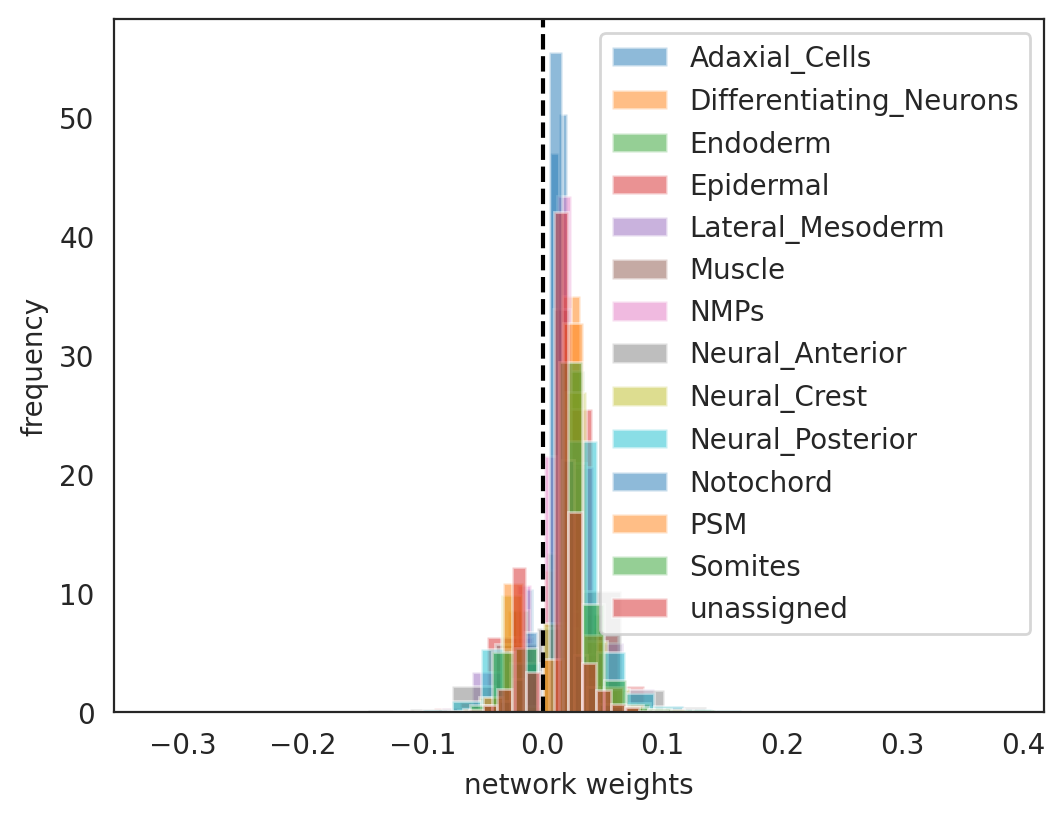

In [80]:
celltypes = links.filtered_links.keys()

plt.figure()

for celltype in celltypes:
    filtered_links_df = links.filtered_links[celltype]
    plt.hist(filtered_links_df["coef_mean"], bins=20, density=True, alpha=0.5, label=celltype)
# Draw a vertical line along the y-axis at x=0
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel("network weights")
plt.ylabel("frequency")
plt.legend()
plt.show()


Text(0, 0.5, 'occurences')

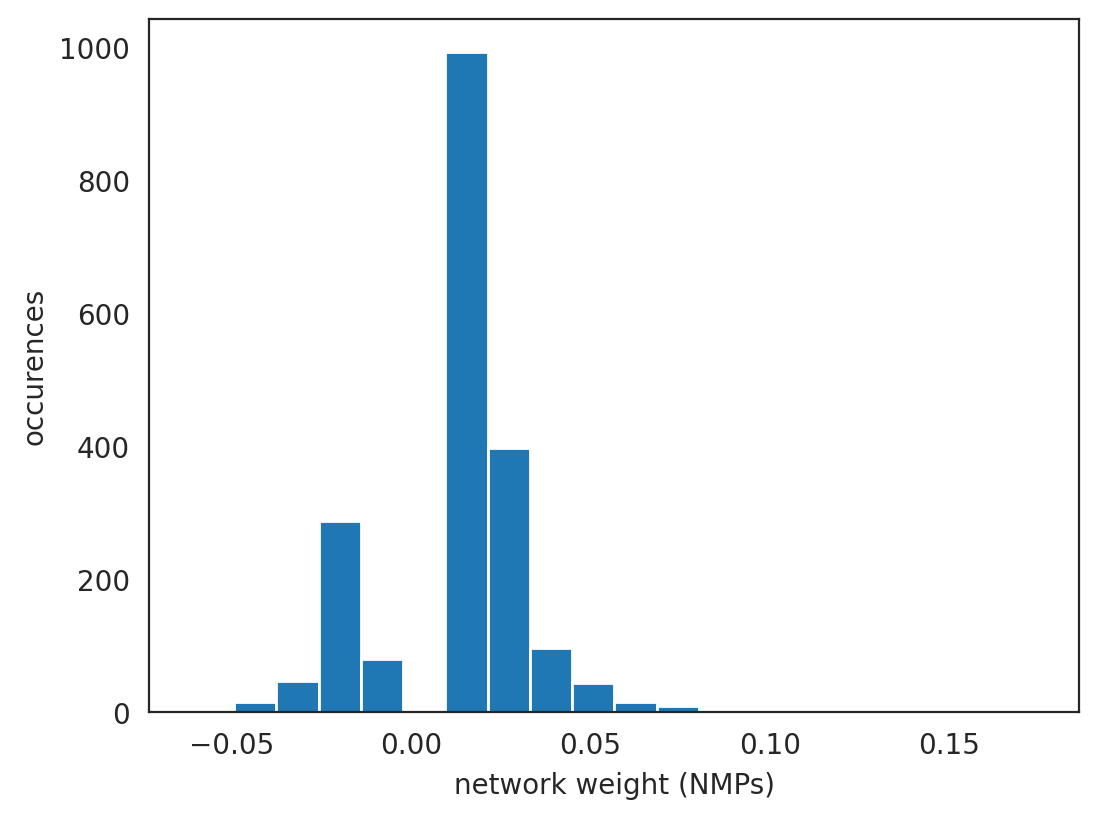

In [81]:
plt.hist(filtered_links_df["coef_mean"], bins=20)
plt.xlabel("network weight (NMPs)")
plt.ylabel("occurences")

Text(0, 0.5, '-log (p_value)')

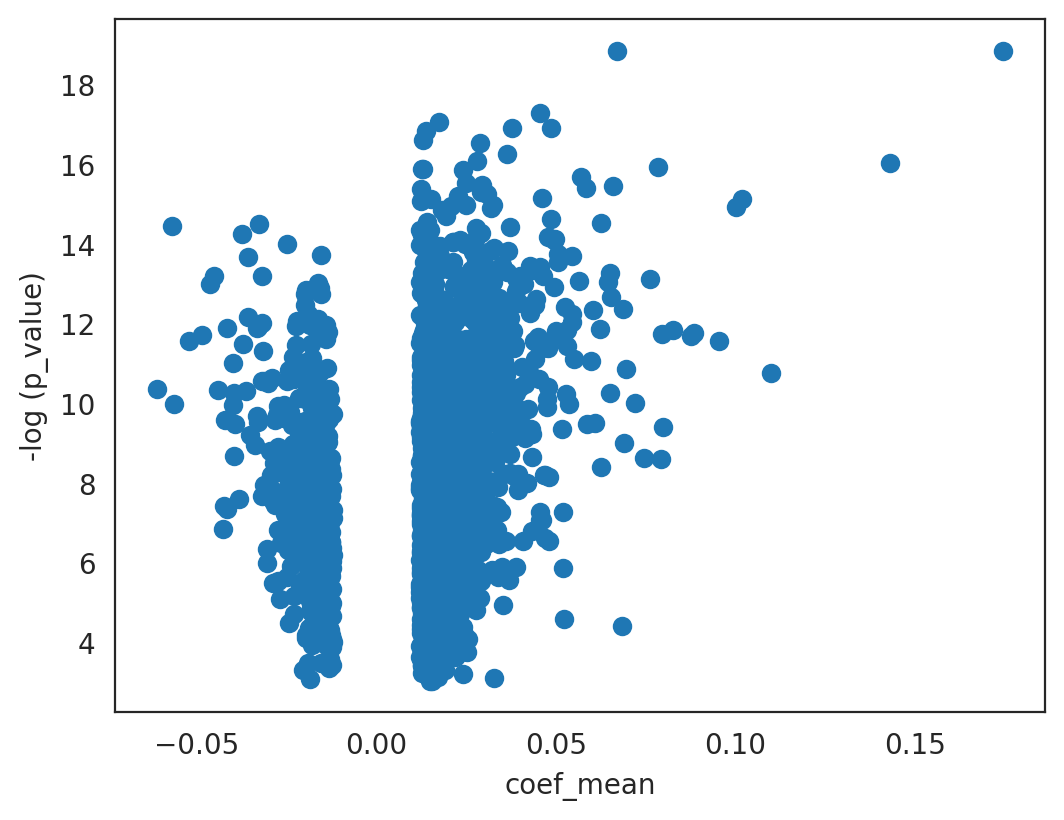

In [82]:
# scatter plot for coef_mean and -log p_value
plt.scatter(filtered_links_df["coef_mean"], filtered_links_df["-logp"])
plt.xlabel("coef_mean")
plt.ylabel("-log (p_value)")

In [85]:
filtered_links_df.sort_values("coef_mean", ascending=False)

source            target  coef_mean  coef_abs             p  \
166079   hmga1a  si:ch73-281n10.2   0.174446  0.174446  1.425083e-19   
154390    mafba             rpl7a   0.142932  0.142932  8.987917e-17   
27799      sox3            cirbpa   0.109816  0.109816  1.673962e-11   
204008   tcf7l2           zbtb16a   0.101832  0.101832  7.442027e-16   
80057    hoxa9b            hmgb2a   0.100233  0.100233  1.158218e-15   
...         ...               ...        ...       ...           ...   
902        etv4             actb1  -0.048603  0.048603  1.953311e-12   
80046   twist1a            hmgb2a  -0.052350  0.052350  2.649423e-12   
8599       mnx1             apoc1  -0.056478  0.056478  1.026318e-10   
8598       gbx2             apoc1  -0.057092  0.057092  3.540801e-15   
161790    six1b           serbp1a  -0.061112  0.061112  4.334704e-11   

            -logp  
166079  18.846160  
154390  16.046341  
27799   10.776255  
204008  15.128309  
80057   14.936210  
...           ...  
902     11.709229  
80046   11.576849  
8599     9.988718  
8598    14.450898  
161790  10.363041  

[2000 rows x 6 columns]

You can confirm that there is no Cebpa connection in Ery_0 cluster.

In [86]:
filtered_links_df[filtered_links_df.source == "sox3"]

source            target  coef_mean  coef_abs             p      -logp
27799    sox3            cirbpa   0.109816  0.109816  1.673962e-11  10.776255
166096   sox3  si:ch73-281n10.2   0.068364  0.068364  3.746339e-05   4.426393
80389    sox3             hmgn2   0.049725  0.049725  7.330988e-15  14.134838
161827   sox3           serbp1a   0.047821  0.047821  4.091331e-12  11.388135
81372    sox3          hnrnpaba   0.042871  0.042871  5.391655e-13  12.268278
85201    sox3          hsp90ab1   0.037212  0.037212  3.727392e-15  14.428595
146434   sox3             ptmab   0.034544  0.034544  4.295737e-13  12.366962
204015   sox3           zbtb16a   0.033184  0.033184  8.822935e-09   8.054387
154624   sox3             rps20   0.030775  0.030775  5.454068e-16  15.263279
26163    sox3              cfl1   0.024636  0.024636  1.006169e-14  13.997329
31827    sox3          col18a1a   0.022645  0.022645  7.340447e-14  13.134278
190637   sox3            tmsb4x   0.022561  0.022561  1.601648e-08   7.795433
124481   sox3             nova2   0.021925  0.021925  5.309203e-14  13.274971
196346   sox3            tubb2b   0.021374  0.021374  1.370980e-11  10.862969
196469   sox3            tubb4b   0.021003  0.021003  1.573776e-08   7.803057
48827    sox3          eef1a1l1   0.019921  0.019921  3.846947e-12  11.414884
1117     sox3             actb2   0.019167  0.019167  4.060796e-10   9.391389
946      sox3             actb1  -0.018842  0.018842  1.260648e-07   6.899406
107721   sox3              mdka   0.017026  0.017026  7.101908e-09   8.148625
174695   sox3             sox13   0.016018  0.016018  2.727081e-11  10.564302
40775    sox3              dag1   0.015530  0.015530  1.455586e-14  13.836962
123540   sox3             nop58   0.015262  0.015262  1.021965e-11  10.990564
195694   sox3            tuba1a   0.013486  0.013486  4.394860e-14  13.357055
57705    sox3             fabp3   0.013426  0.013426  1.482984e-10   9.828864
65079    sox3             foxp4   0.013239  0.013239  3.548933e-08   7.449902

## 7.4. Gene cartography analysis

Gene cartography is a method for gene network analysis.
The method classifies gene into several groups using the network module structure and connections.
It provides us an insight about the role and regulatory mechanism for each gene. 
For more information on gene cartography, please refer to the following paper (https://www.nature.com/articles/nature03288).

The gene cartography will be calculated for the GRN in each cluster.
Thus we can know how the gene cartography change by comparing the the score between clusters.

Adaxial_Cells


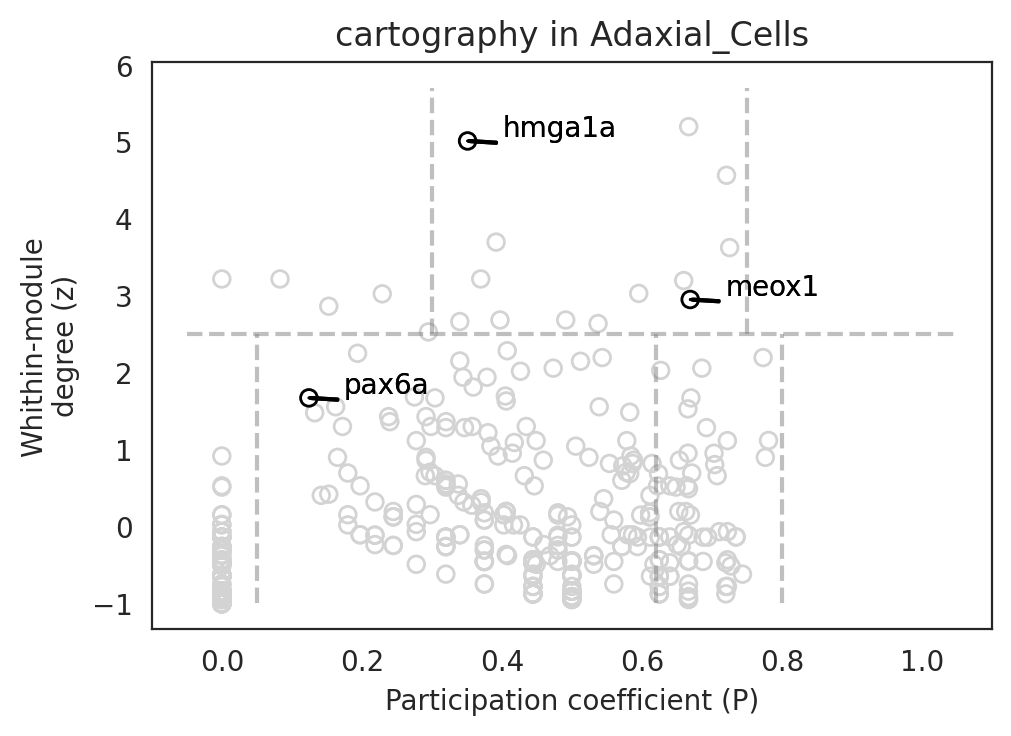

Differentiating_Neurons


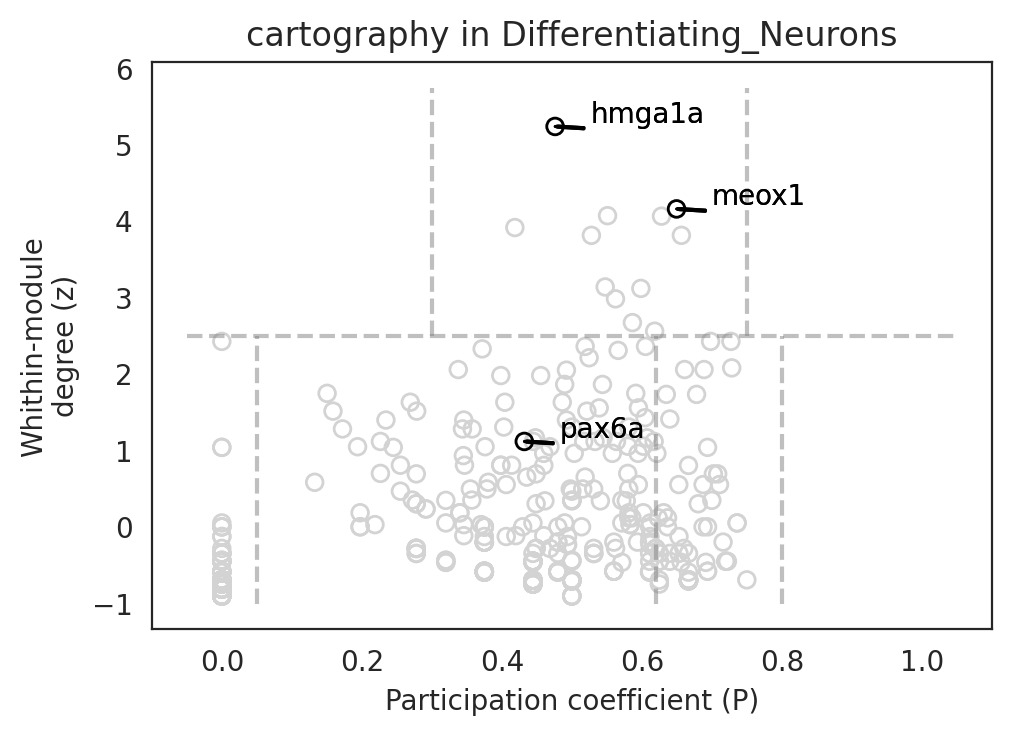

Endoderm


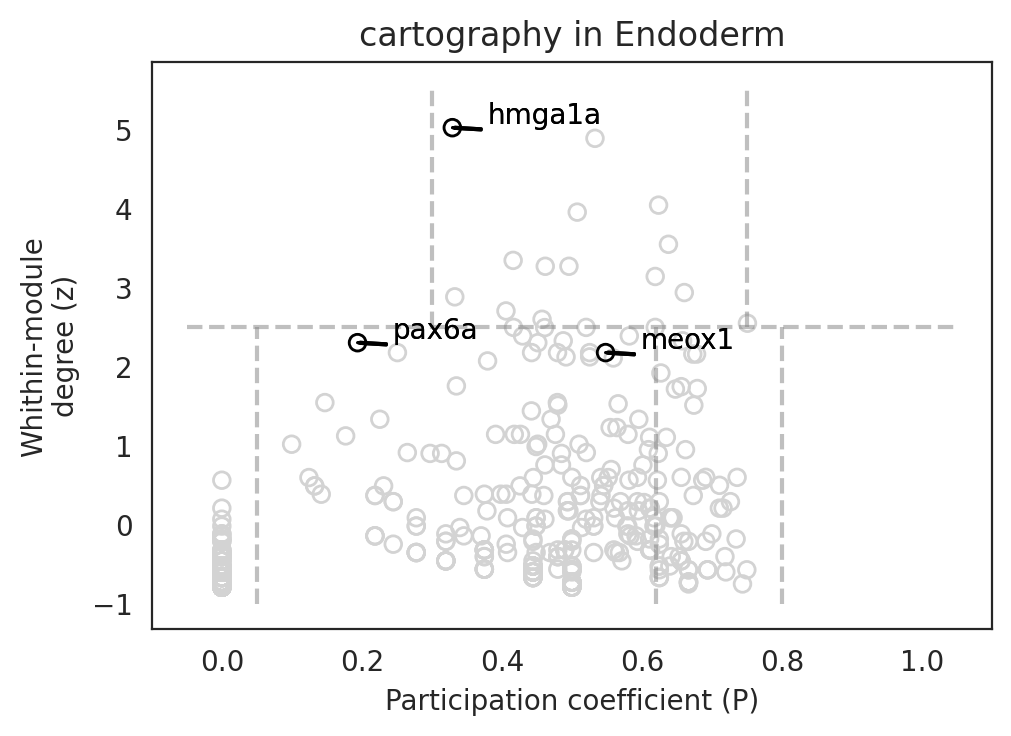

Epidermal


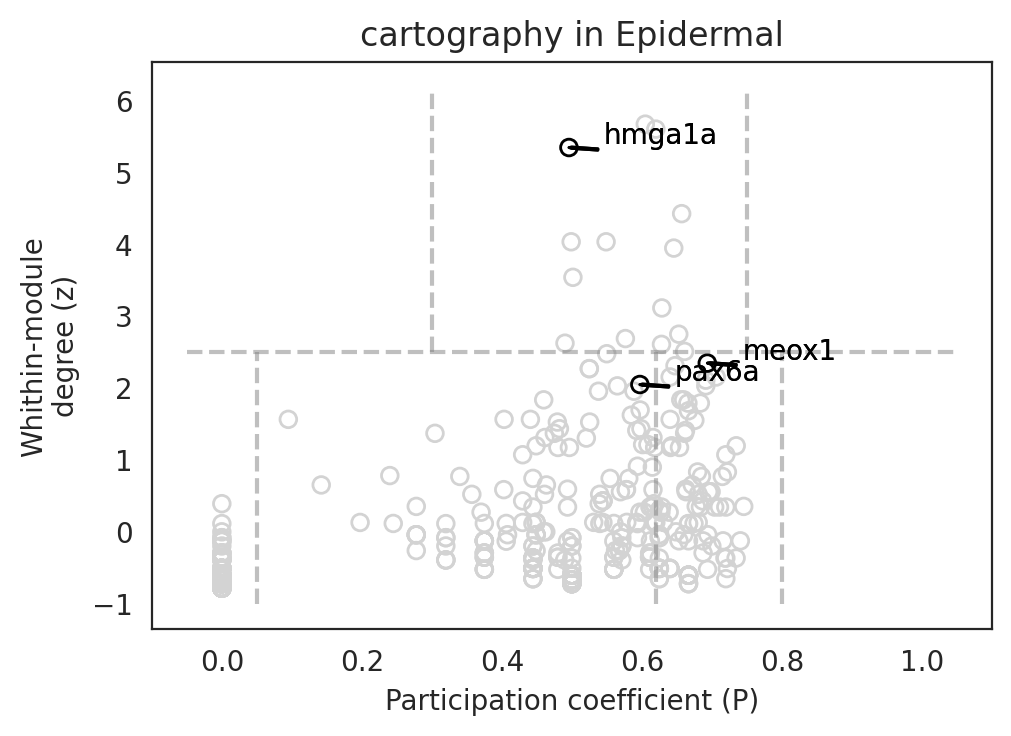

Lateral_Mesoderm


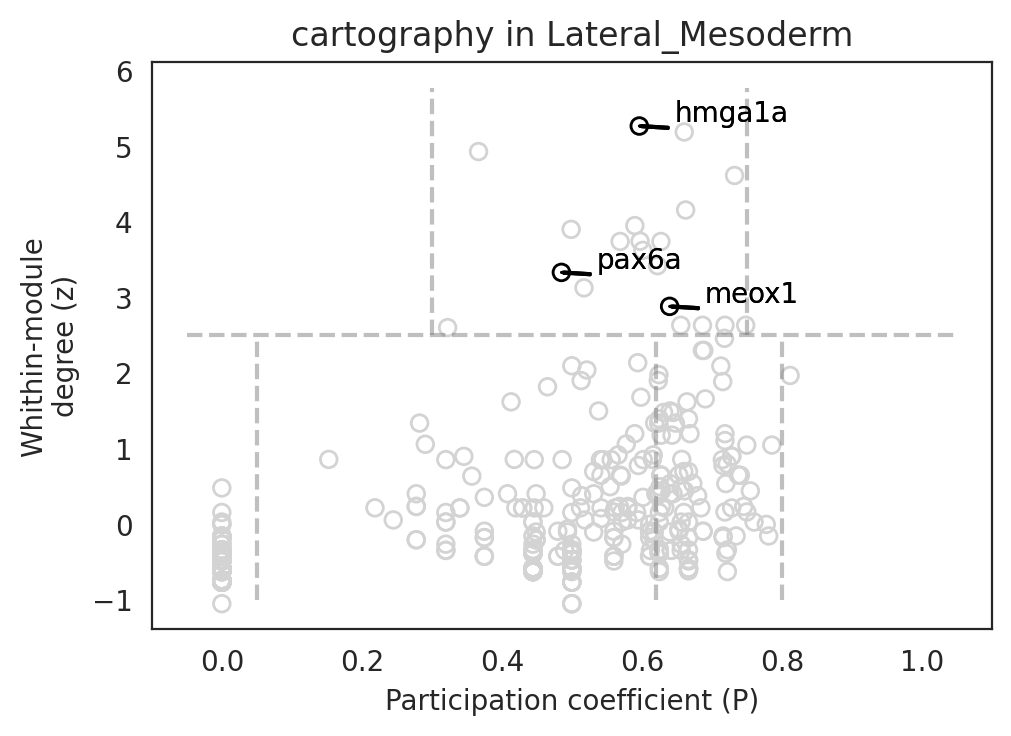

Muscle


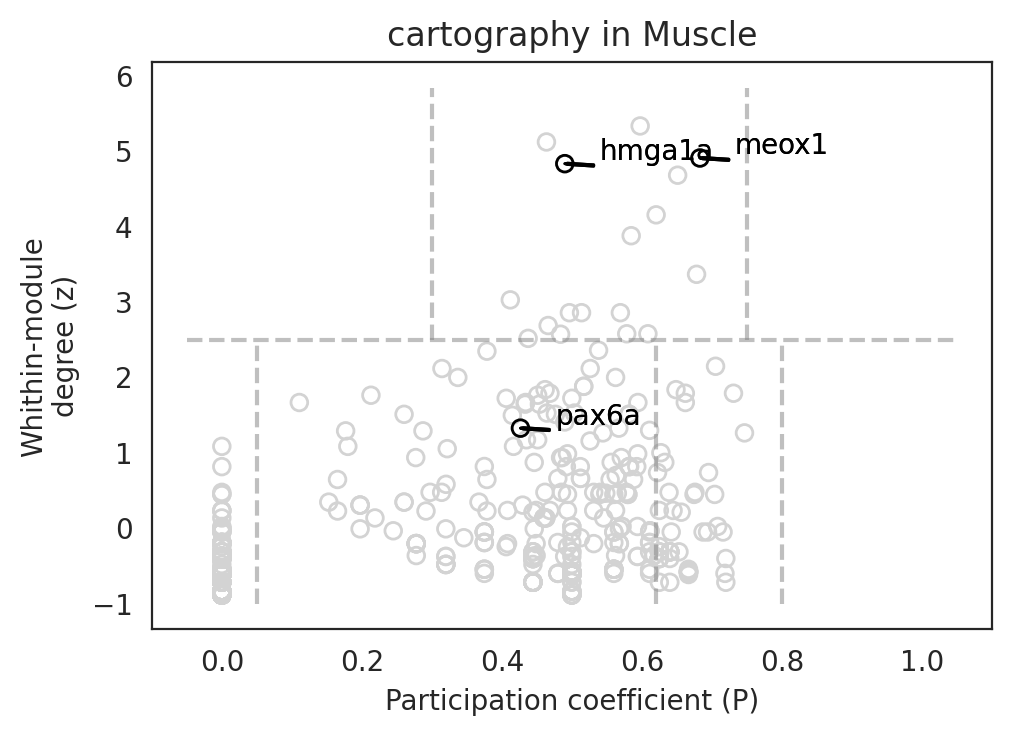

NMPs


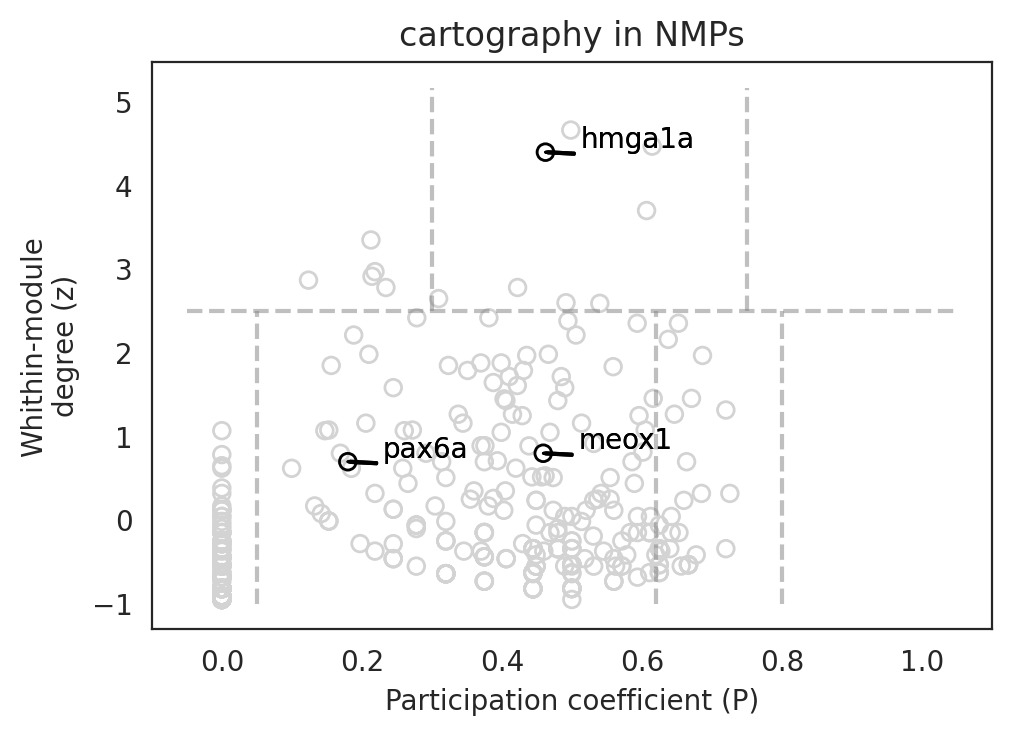

Neural_Anterior


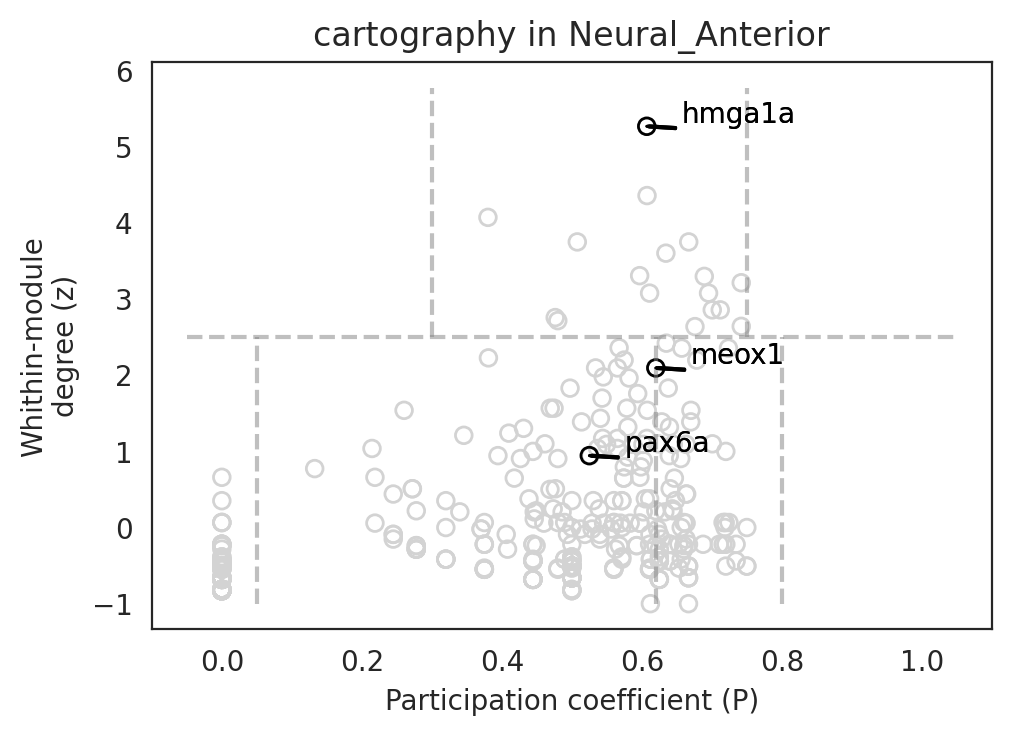

Neural_Crest


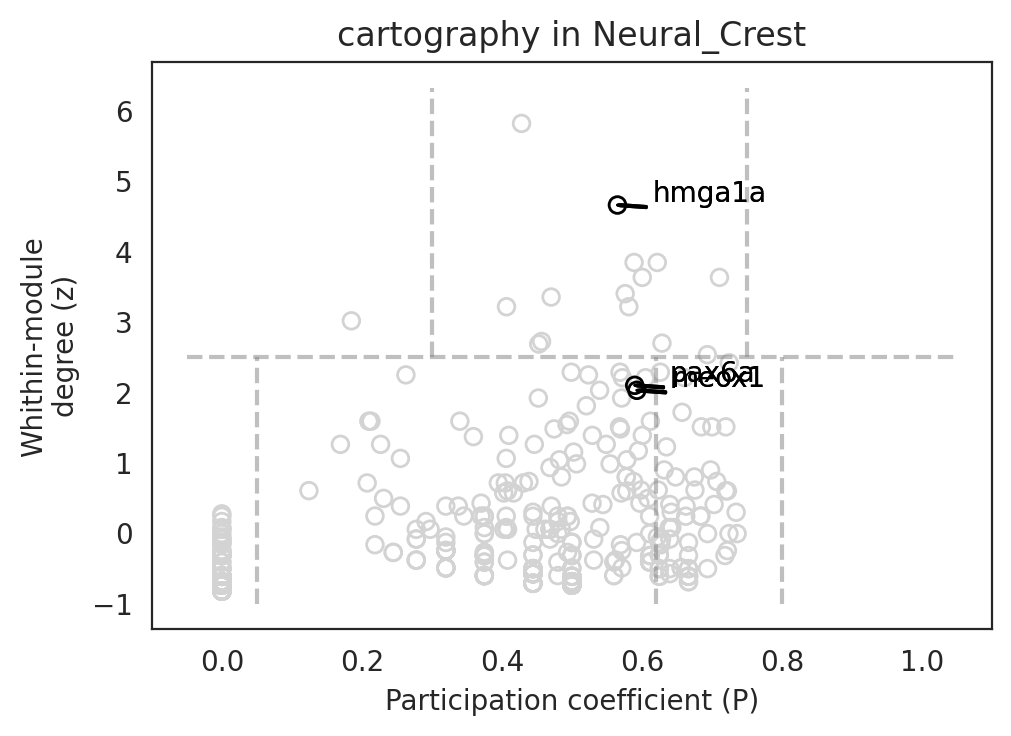

Neural_Posterior


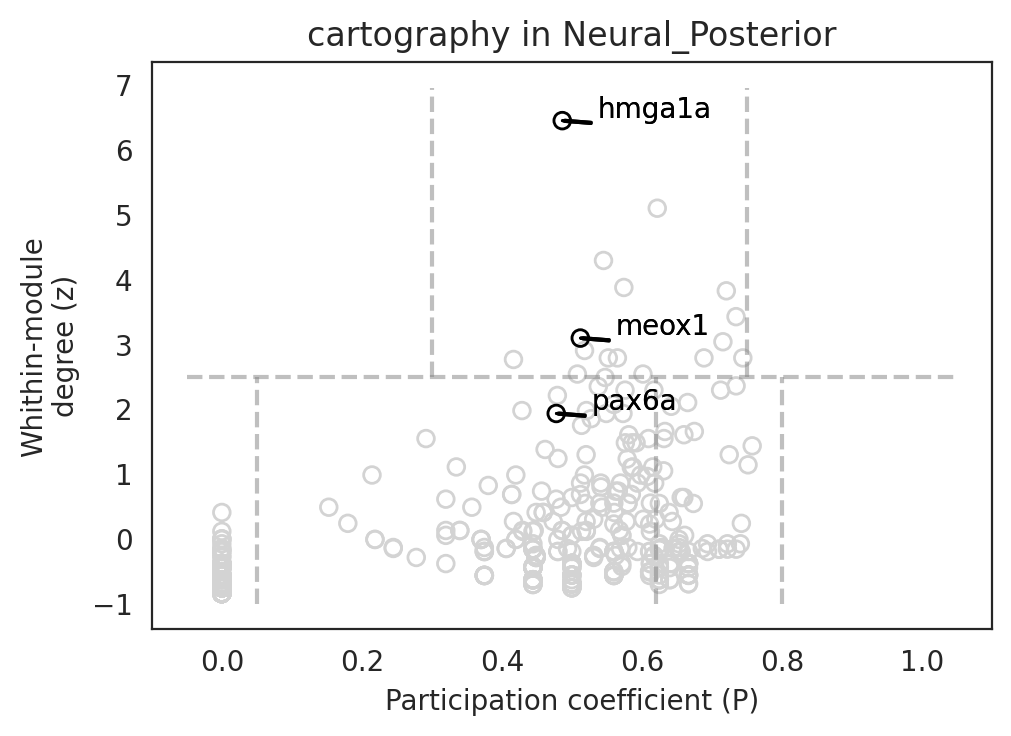

Notochord


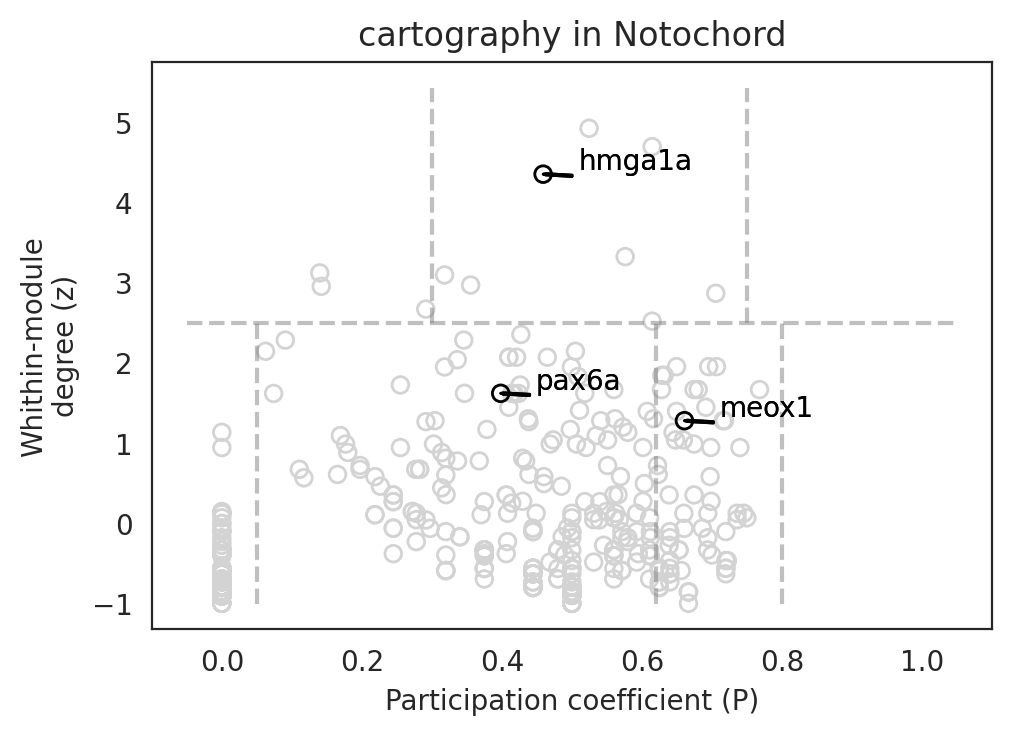

PSM


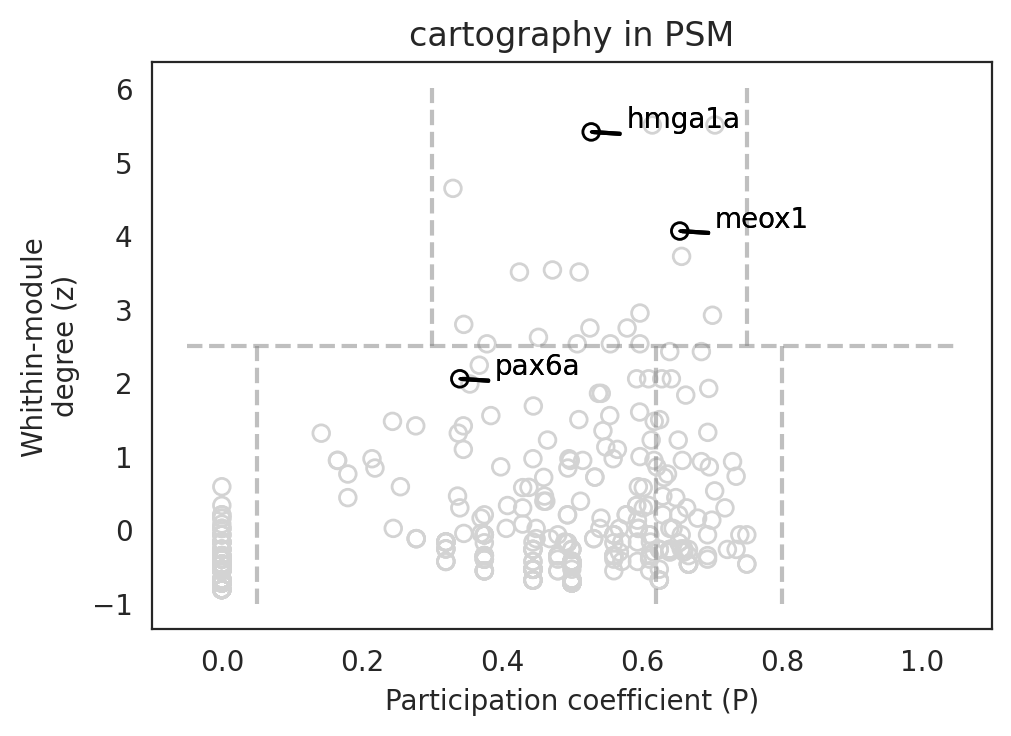

Somites


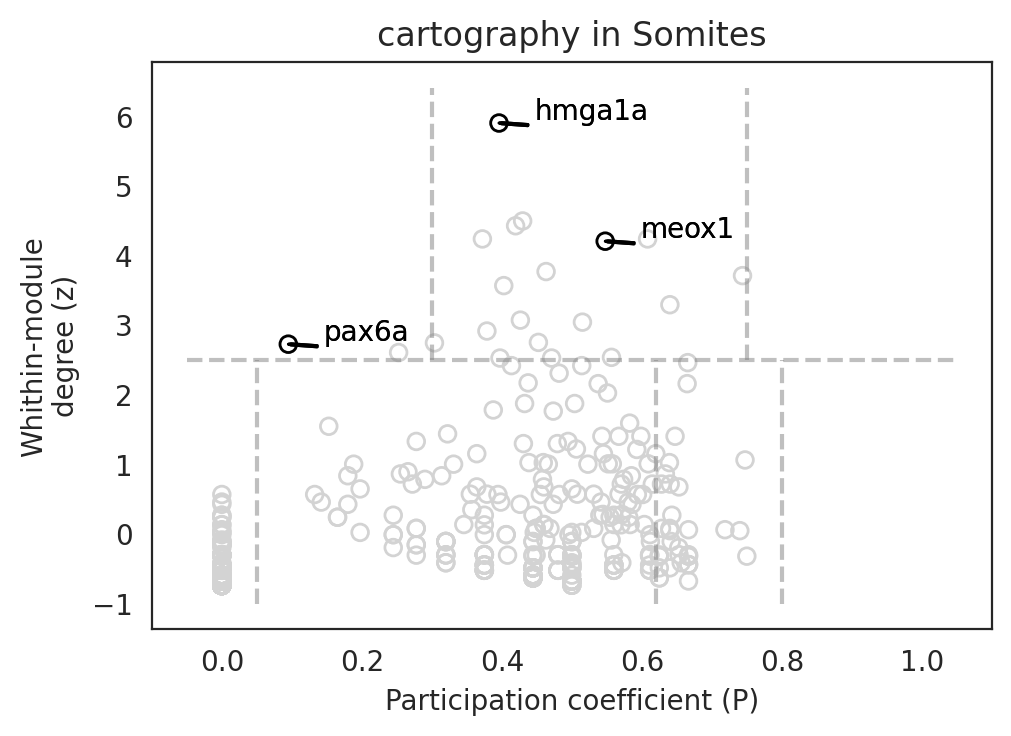

unassigned


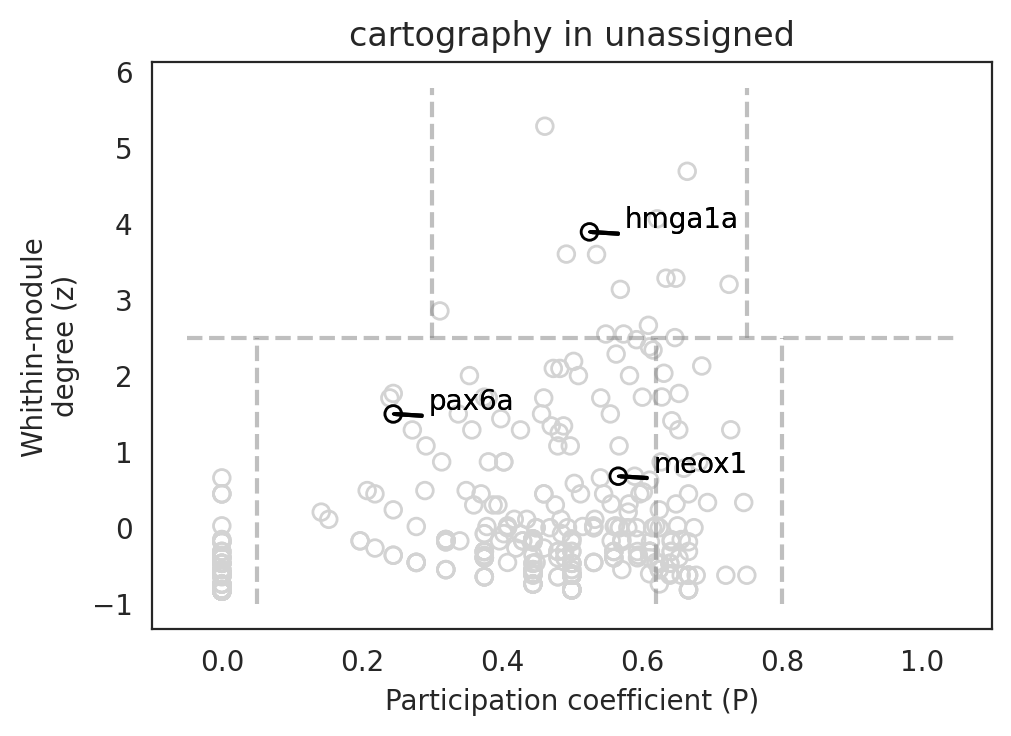

In [110]:
# Plot cartography as a scatter plot
links.plot_cartography_scatter_per_cluster(scatter=True,
                                           kde=False,
                                           gois=["hmga1a", "meox1", "pax6a"],
                                           auto_gene_annot=False,
                                           args_dot={"n_levels": 105},
                                           args_line={"c":"gray"}) #, save="TDR118_15somite_GRN_coarse_celltypes/cartography")

In [90]:
output_filepath

'/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/'

In [92]:
# # Plot the summary of cartography analysis
# links.plot_cartography_term(goi="sox3", save= output_filepath + "figures_danRer11/cartography")

# 8. Network analysis; network score distribution

Next, we visualize the distribution of network score to get insight into the global trend of the GRNs.

## 8.1. Distribution of network degree

degree_centrality_all


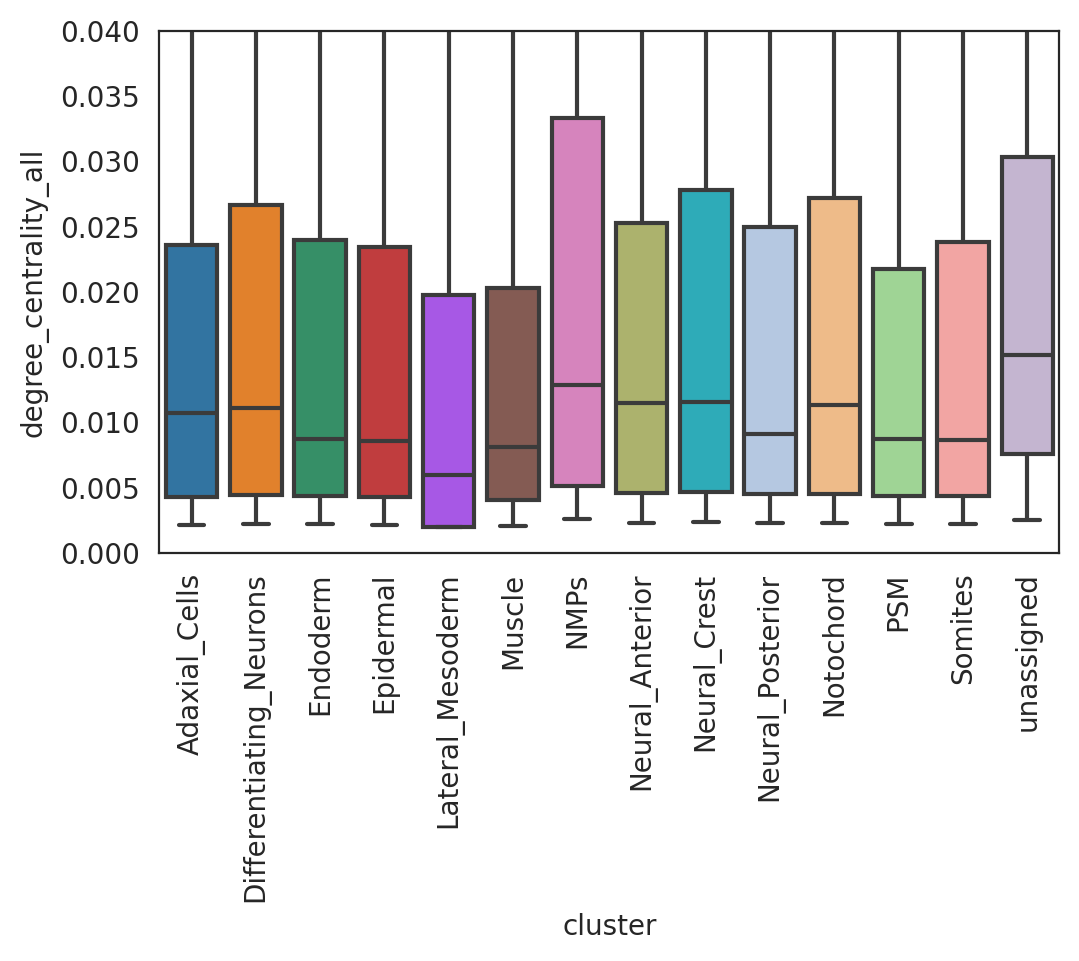

In [111]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0,0.040])
links.plot_score_discributions(values=["degree_centrality_all"], method="boxplot")#, save="TDR118_15somite_GRN_coarse_celltypes")



eigenvector_centrality


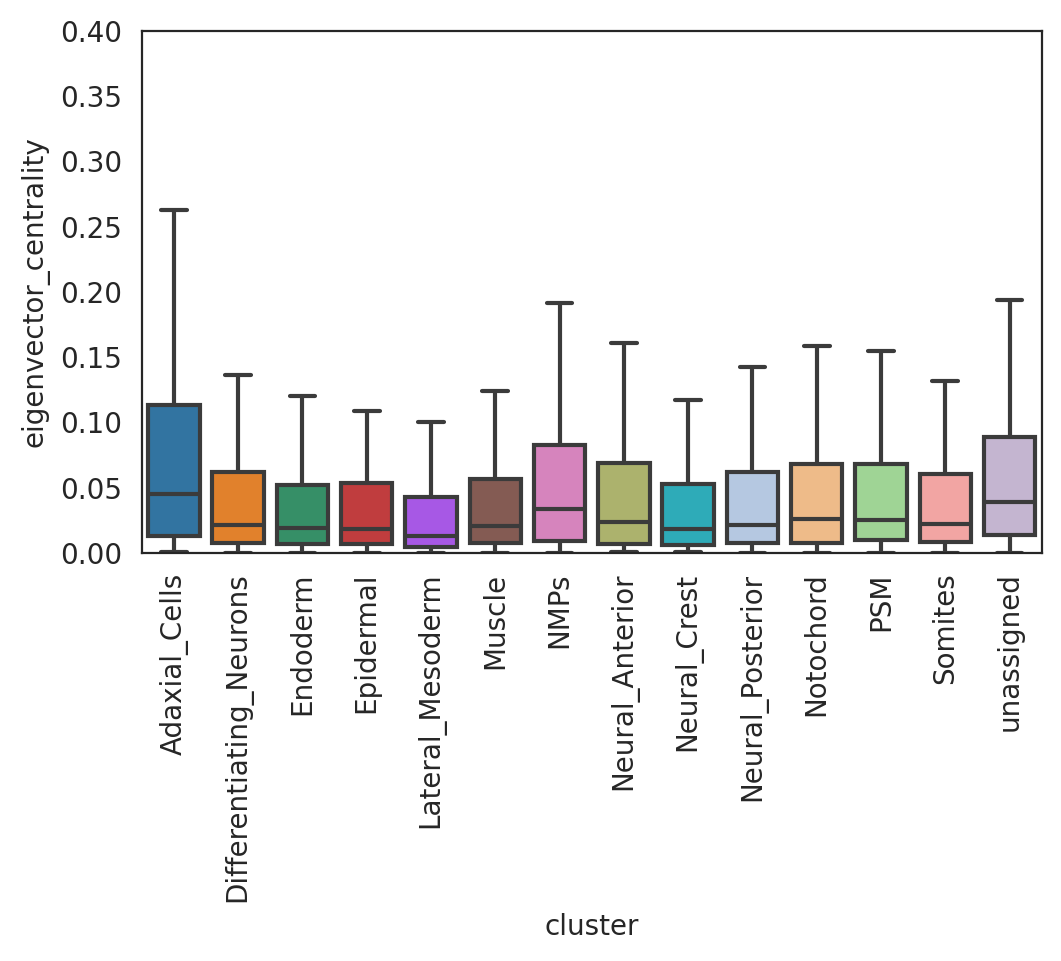

In [112]:
plt.subplots_adjust(left=0.15, bottom=0.3)
plt.ylim([0, 0.40])
links.plot_score_discributions(values=["eigenvector_centrality"], method="boxplot")# , save="TDR118_15somite_GRN_coarse_celltypes")




## 8.2. Distribution of netowrk entropy

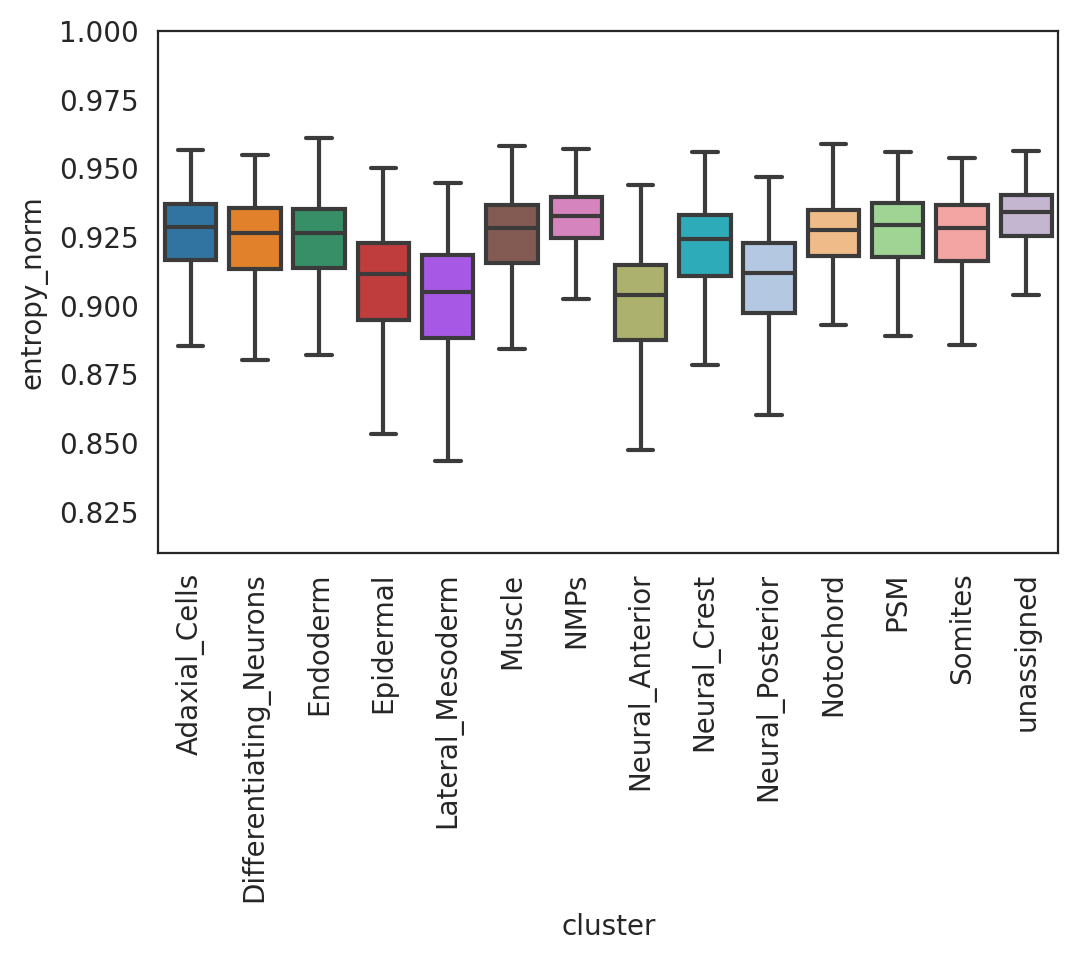

In [113]:
plt.subplots_adjust(left=0.15, bottom=0.3)
links.plot_network_entropy_distributions() #(save="TDR118_15somite_GRN_coarse_celltypes")



Using the network scores, we could pick up cluster-specific key TFs.
Gata2, Gata1, Klf1, E2f1, for example, are known to play an essential role in MEP, and these TFs showed high network score in our GRN.

However, it is important to note that network analysis alone cannot shed light on the specific functions or roles these TFs play in cell fate determination. 

In the next section, we will begin to investigate each TF’s contribution to cell fate by running GRN simulations